## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


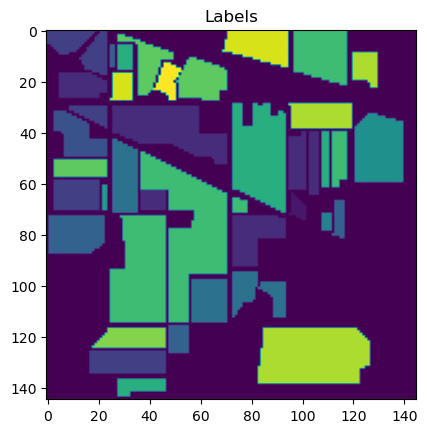

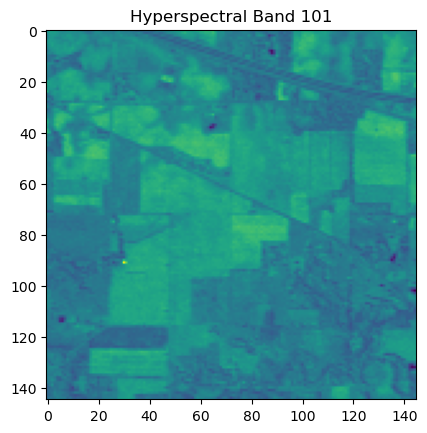

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class 


All datasets saved to the 'indices' folder.
(320, 5, 5, 200)
(75, 5, 5, 200)
(9854, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0769, PSNR: 10.9200


Epoch [1/50] Training Loss: 0.0628, PSNR: 11.5949
	[Val]   Batch [1/33] Loss: 0.0472, PSNR: 12.9216
	[Val]   Batch [10/33] Loss: 0.0466, PSNR: 12.5821
	[Val]   Batch [20/33] Loss: 0.0462, PSNR: 12.1853
	[Val]   Batch [30/33] Loss: 0.0448, PSNR: 12.5633
Epoch [1/50] Validation Loss: 0.0469, PSNR: 12.7494

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0474, PSNR: 12.6198


Epoch [2/50] Training Loss: 0.0377, PSNR: 13.8104
	[Val]   Batch [1/33] Loss: 0.0275, PSNR: 15.2652
	[Val]   Batch [10/33] Loss: 0.0270, PSNR: 14.9482
	[Val]   Batch [20/33] Loss: 0.0267, PSNR: 14.5665
	[Val]   Batch [30/33] Loss: 0.0260, PSNR: 14.9196
Epoch [2/50] Validation Loss: 0.0274, PSNR: 15.0830

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0273, PSNR: 14.9027


Epoch [3/50] Training Loss: 0.0221, PSNR: 16.1496
	[Val]   Batch [1/33] Loss: 0.0169, PSNR: 17.3822
	[Val]   Batch [10/33] Loss: 0.0164, PSNR: 17.1138
	[Val]   Batch [20/33] Loss: 0.0161, PSNR: 16.7576
	[Val]   Batch [30/33] Loss: 0.0156, PSNR: 17.1337
Epoch [3/50] Validation Loss: 0.0168, PSNR: 17.2053

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0174, PSNR: 17.3730


Epoch [4/50] Training Loss: 0.0137, PSNR: 18.1916
	[Val]   Batch [1/33] Loss: 0.0114, PSNR: 19.1012
	[Val]   Batch [10/33] Loss: 0.0109, PSNR: 18.8914
	[Val]   Batch [20/33] Loss: 0.0106, PSNR: 18.5732
	[Val]   Batch [30/33] Loss: 0.0103, PSNR: 18.9573
Epoch [4/50] Validation Loss: 0.0113, PSNR: 18.9290

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0120, PSNR: 18.5753


Epoch [5/50] Training Loss: 0.0094, PSNR: 19.7798
	[Val]   Batch [1/33] Loss: 0.0083, PSNR: 20.4972
	[Val]   Batch [10/33] Loss: 0.0078, PSNR: 20.3520
	[Val]   Batch [20/33] Loss: 0.0075, PSNR: 20.0736
	[Val]   Batch [30/33] Loss: 0.0073, PSNR: 20.4558
Epoch [5/50] Validation Loss: 0.0082, PSNR: 20.3264

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0074, PSNR: 20.5914


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0531
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6059
	[Val]   Batch [10/33] Loss: 0.0060, PSNR: 21.5207
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2863
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6820
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4382

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0053, PSNR: 22.2456


Epoch [7/50] Training Loss: 0.0057, PSNR: 22.0100
	[Val]   Batch [1/33] Loss: 0.0053, PSNR: 22.4495
	[Val]   Batch [10/33] Loss: 0.0048, PSNR: 22.4260
	[Val]   Batch [20/33] Loss: 0.0046, PSNR: 22.2290
	[Val]   Batch [30/33] Loss: 0.0044, PSNR: 22.6400
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.2925

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0048, PSNR: 23.1459


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8050
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2346
	[Val]   Batch [10/33] Loss: 0.0040, PSNR: 23.2726
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1011
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.5184
Epoch [8/50] Validation Loss: 0.0044, PSNR: 23.0842

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0050, PSNR: 22.6816


Epoch [9/50] Training Loss: 0.0040, PSNR: 23.5122
	[Val]   Batch [1/33] Loss: 0.0038, PSNR: 23.8447
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 23.9587
	[Val]   Batch [20/33] Loss: 0.0032, PSNR: 23.8264
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2733
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.7353

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0035, PSNR: 24.5490


Epoch [10/50] Training Loss: 0.0035, PSNR: 24.1479
	[Val]   Batch [1/33] Loss: 0.0033, PSNR: 24.4677
	[Val]   Batch [10/33] Loss: 0.0029, PSNR: 24.6463
	[Val]   Batch [20/33] Loss: 0.0027, PSNR: 24.5486
	[Val]   Batch [30/33] Loss: 0.0025, PSNR: 25.0341
Epoch [10/50] Validation Loss: 0.0032, PSNR: 24.3972

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0032, PSNR: 23.8076


Epoch [11/50] Training Loss: 0.0031, PSNR: 24.7192
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 25.1110
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.3709
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.2951
	[Val]   Batch [30/33] Loss: 0.0021, PSNR: 25.7649
Epoch [11/50] Validation Loss: 0.0028, PSNR: 25.0770

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0031, PSNR: 24.7265


Epoch [12/50] Training Loss: 0.0027, PSNR: 25.2513
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5528
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8210
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.7572
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2691
Epoch [12/50] Validation Loss: 0.0025, PSNR: 25.5244

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.8946


Epoch [13/50] Training Loss: 0.0024, PSNR: 25.6950
	[Val]   Batch [1/33] Loss: 0.0023, PSNR: 26.1346
	[Val]   Batch [10/33] Loss: 0.0019, PSNR: 26.4331
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.3924
	[Val]   Batch [30/33] Loss: 0.0016, PSNR: 26.9417
Epoch [13/50] Validation Loss: 0.0022, PSNR: 26.1200

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.4280


Epoch [14/50] Training Loss: 0.0022, PSNR: 26.1402
	[Val]   Batch [1/33] Loss: 0.0020, PSNR: 26.6154
	[Val]   Batch [10/33] Loss: 0.0017, PSNR: 26.9347
	[Val]   Batch [20/33] Loss: 0.0016, PSNR: 26.9115
	[Val]   Batch [30/33] Loss: 0.0014, PSNR: 27.4789
Epoch [14/50] Validation Loss: 0.0020, PSNR: 26.6132

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0019, PSNR: 26.9437


Epoch [15/50] Training Loss: 0.0020, PSNR: 26.5399
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9514
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.2570
	[Val]   Batch [20/33] Loss: 0.0014, PSNR: 27.2595
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.8784
Epoch [15/50] Validation Loss: 0.0018, PSNR: 26.9636

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0021, PSNR: 26.7737


Epoch [16/50] Training Loss: 0.0018, PSNR: 26.9297
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.3415
	[Val]   Batch [10/33] Loss: 0.0015, PSNR: 27.5896
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.5955
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.2512
Epoch [16/50] Validation Loss: 0.0017, PSNR: 27.3338

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.8077


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.2729
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.8941
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.1608
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.1926
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.8179
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.8954

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 28.0567


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.5890
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.3257
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.6038
	[Val]   Batch [20/33] Loss: 0.0010, PSNR: 28.6366
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.3101
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.3440

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 28.1267


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.9564
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.7534
	[Val]   Batch [10/33] Loss: 0.0011, PSNR: 28.9790
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.0544
	[Val]   Batch [30/33] Loss: 0.0009, PSNR: 29.7055
Epoch [19/50] Validation Loss: 0.0012, PSNR: 28.7601

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0015, PSNR: 27.8972


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.2145
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 28.8661
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.0719
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.1647
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.8938
Epoch [20/50] Validation Loss: 0.0012, PSNR: 28.8888

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.3042


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4996
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.2155
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3423
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4713
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1406
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1957

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.7724


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.7826
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.7824
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9137
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 30.0752
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.7545
Epoch [22/50] Validation Loss: 0.0009, PSNR: 29.7600

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0011, PSNR: 29.4119


Epoch [23/50] Training Loss: 0.0011, PSNR: 28.9776
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8540
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.0248
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.2079
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.9116
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.8740

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0014, PSNR: 27.7256


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.1488
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3156
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4547
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6975
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4103
Epoch [24/50] Validation Loss: 0.0008, PSNR: 30.3303

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.4277


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.3381
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3476
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4711
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.7367
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4772
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3817

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6988


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.4665
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6223
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7506
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0426
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.8304
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.6664

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.4437


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.6210
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.6115
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7307
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.9967
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7816
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.6542
Early stopping triggered at epoch 27. No improvement for 3 epochs.


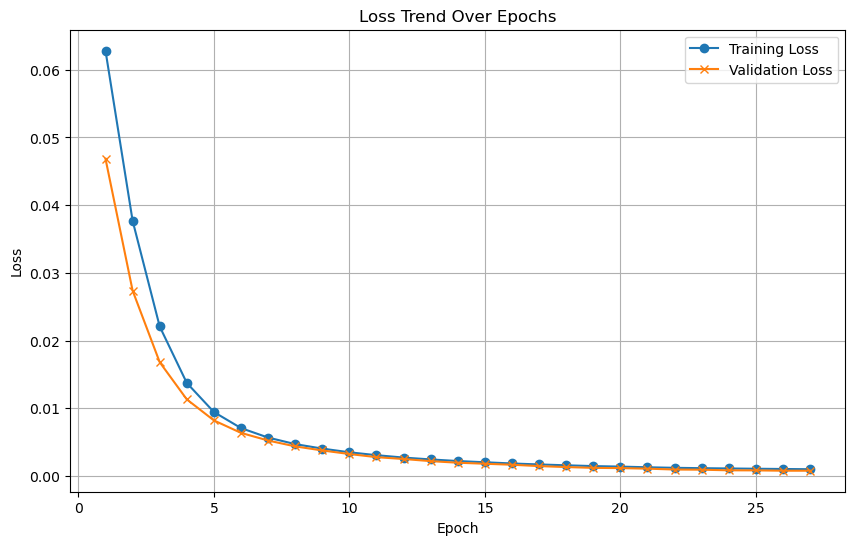

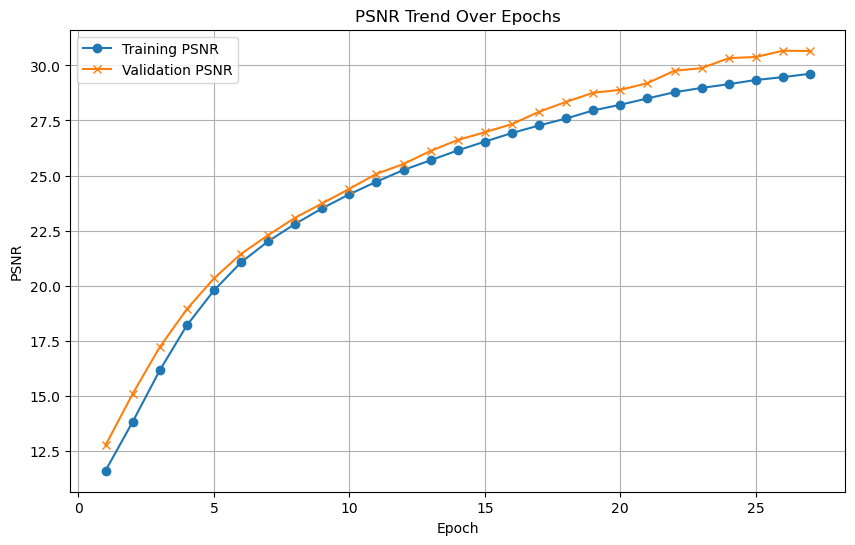

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/39 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7870
    Validation Batch [1/1], Loss: 2.7704
Validation Loss: 2.7704, Validation Accuracy: 6.67%
Validation loss improved from inf to 2.7704. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7520
    Validation Batch [1/1], Loss: 2.7704
Validation Loss: 2.7704, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7471
    Validation Batch [1/1], Loss: 2.7705
Validation Loss: 2.7705, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7264
    Validation Batch [1/1], Loss: 2.7705
Validation Loss: 2.7705, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [7/1000] completed, Average Training Loss: 2.6865
    Validation Batch [1/1], Loss: 2.7708
Validation Loss: 2.7708, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [8/1000] - Training
Epoch [8/1000] completed, Average Training Loss: 2.6691
    Validation Batch [1/1], Loss: 2.7709
Validation Loss: 2.7709, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [9/1000] - Training
Epoch [9/1000] completed, Average Training Loss: 2.6687
    Validation Batch [1/1], Loss: 2.7709
Validation Loss: 2.7709, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [10/1000] - Training
Epoch [10/1000] completed, Average Training Loss: 2.6544
    Validation Batch [1/1], Loss: 2.7710
Validation Loss: 2.7710, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6369
    Validation Batch

Epoch [17/1000] completed, Average Training Loss: 2.5820
    Validation Batch [1/1], Loss: 2.7716
Validation Loss: 2.7716, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5604
    Validation Batch [1/1], Loss: 2.7718
Validation Loss: 2.7718, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5613
    Validation Batch [1/1], Loss: 2.7717
Validation Loss: 2.7717, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.5566
    Validation Batch [1/1], Loss: 2.7717
Validation Loss: 2.7717, Validation Accuracy: 6.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5404
    Validat

Epoch [29/1000] completed, Average Training Loss: 2.4763
    Validation Batch [1/1], Loss: 2.7640
Validation Loss: 2.7640, Validation Accuracy: 13.33%
Validation loss improved from 2.7660 to 2.7640. Saving model...

LOG: Epoch [30/1000] - Training
Epoch [30/1000] completed, Average Training Loss: 2.4663
    Validation Batch [1/1], Loss: 2.7614
Validation Loss: 2.7614, Validation Accuracy: 13.33%
Validation loss improved from 2.7640 to 2.7614. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.4547
    Validation Batch [1/1], Loss: 2.7578
Validation Loss: 2.7578, Validation Accuracy: 13.33%
Validation loss improved from 2.7614 to 2.7578. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.4381
    Validation Batch [1/1], Loss: 2.7534
Validation Loss: 2.7534, Validation Accuracy: 13.33%
Validation loss improved from 2.7578 to 2.7534. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [3

    Validation Batch [1/1], Loss: 2.6969
Validation Loss: 2.6969, Validation Accuracy: 16.00%
Validation loss improved from 2.7067 to 2.6969. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3977
    Validation Batch [1/1], Loss: 2.6855
Validation Loss: 2.6855, Validation Accuracy: 18.67%
Validation loss improved from 2.6969 to 2.6855. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3841
    Validation Batch [1/1], Loss: 2.6720
Validation Loss: 2.6720, Validation Accuracy: 18.67%
Validation loss improved from 2.6855 to 2.6720. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3801
    Validation Batch [1/1], Loss: 2.6560
Validation Loss: 2.6560, Validation Accuracy: 18.67%
Validation loss improved from 2.6720 to 2.6560. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.3702
    Vali

Epoch [50/1000] completed, Average Training Loss: 2.3117
    Validation Batch [1/1], Loss: 2.5338
Validation Loss: 2.5338, Validation Accuracy: 22.67%
Validation loss improved from 2.5464 to 2.5338. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.3225
    Validation Batch [1/1], Loss: 2.5182
Validation Loss: 2.5182, Validation Accuracy: 24.00%
Validation loss improved from 2.5338 to 2.5182. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.3101
    Validation Batch [1/1], Loss: 2.5032
Validation Loss: 2.5032, Validation Accuracy: 24.00%
Validation loss improved from 2.5182 to 2.5032. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.3174
    Validation Batch [1/1], Loss: 2.4906
Validation Loss: 2.4906, Validation Accuracy: 24.00%
Validation loss improved from 2.5032 to 2.4906. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [5

Epoch [61/1000] completed, Average Training Loss: 2.2549
    Validation Batch [1/1], Loss: 2.3606
Validation Loss: 2.3606, Validation Accuracy: 24.00%
Validation loss improved from 2.3697 to 2.3606. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.2201
    Validation Batch [1/1], Loss: 2.3587
Validation Loss: 2.3587, Validation Accuracy: 24.00%
Validation loss improved from 2.3606 to 2.3587. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.2136
    Validation Batch [1/1], Loss: 2.3537
Validation Loss: 2.3537, Validation Accuracy: 25.33%
Validation loss improved from 2.3587 to 2.3537. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1996
    Validation Batch [1/1], Loss: 2.3383
Validation Loss: 2.3383, Validation Accuracy: 25.33%
Validation loss improved from 2.3537 to 2.3383. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.2539
Validation Loss: 2.2539, Validation Accuracy: 29.33%
Validation loss improved from 2.2681 to 2.2539. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 2.1520
    Validation Batch [1/1], Loss: 2.2490
Validation Loss: 2.2490, Validation Accuracy: 30.67%
Validation loss improved from 2.2539 to 2.2490. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 2.1682
    Validation Batch [1/1], Loss: 2.2368
Validation Loss: 2.2368, Validation Accuracy: 29.33%
Validation loss improved from 2.2490 to 2.2368. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.1385
    Validation Batch [1/1], Loss: 2.2164
Validation Loss: 2.2164, Validation Accuracy: 28.00%
Validation loss improved from 2.2368 to 2.2164. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.1298
    Vali

Epoch [83/1000] completed, Average Training Loss: 2.0692
    Validation Batch [1/1], Loss: 2.1741
Validation Loss: 2.1741, Validation Accuracy: 28.00%
Validation loss improved from 2.1833 to 2.1741. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.0669
    Validation Batch [1/1], Loss: 2.1660
Validation Loss: 2.1660, Validation Accuracy: 28.00%
Validation loss improved from 2.1741 to 2.1660. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 2.0678
    Validation Batch [1/1], Loss: 2.1889
Validation Loss: 2.1889, Validation Accuracy: 25.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 2.0785
    Validation Batch [1/1], Loss: 2.2052
Validation Loss: 2.2052, Validation Accuracy: 24.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Tra

Epoch [95/1000] completed, Average Training Loss: 1.9968
    Validation Batch [1/1], Loss: 2.1097
Validation Loss: 2.1097, Validation Accuracy: 29.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.9994
    Validation Batch [1/1], Loss: 2.1113
Validation Loss: 2.1113, Validation Accuracy: 28.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.9738
    Validation Batch [1/1], Loss: 2.0953
Validation Loss: 2.0953, Validation Accuracy: 28.00%
Validation loss improved from 2.1032 to 2.0953. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.9614
    Validation Batch [1/1], Loss: 2.0800
Validation Loss: 2.0800, Validation Accuracy: 28.00%
Validation loss improved from 2.0953 to 2.0800. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Tra

Epoch [104/1000] completed, Average Training Loss: 1.9094
    Validation Batch [1/1], Loss: 2.0316
Validation Loss: 2.0316, Validation Accuracy: 34.67%
Validation loss improved from 2.0541 to 2.0316. Saving model...

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.9203
    Validation Batch [1/1], Loss: 2.0517
Validation Loss: 2.0517, Validation Accuracy: 30.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.9194
    Validation Batch [1/1], Loss: 2.0643
Validation Loss: 2.0643, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.8966
    Validation Batch [1/1], Loss: 2.0593
Validation Loss: 2.0593, Validation Accuracy: 38.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.9789
Validation Loss: 1.9789, Validation Accuracy: 36.00%
Validation loss improved from 1.9793 to 1.9789. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.8253
    Validation Batch [1/1], Loss: 1.9732
Validation Loss: 1.9732, Validation Accuracy: 40.00%
Validation loss improved from 1.9789 to 1.9732. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.8062
    Validation Batch [1/1], Loss: 1.9684
Validation Loss: 1.9684, Validation Accuracy: 40.00%
Validation loss improved from 1.9732 to 1.9684. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.7975
    Validation Batch [1/1], Loss: 1.9506
Validation Loss: 1.9506, Validation Accuracy: 33.33%
Validation loss improved from 1.9684 to 1.9506. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.7957


    Validation Batch [1/1], Loss: 1.9550
Validation Loss: 1.9550, Validation Accuracy: 30.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.7341
    Validation Batch [1/1], Loss: 1.9029
Validation Loss: 1.9029, Validation Accuracy: 33.33%
Validation loss improved from 1.9045 to 1.9029. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.7107
    Validation Batch [1/1], Loss: 1.9258
Validation Loss: 1.9258, Validation Accuracy: 38.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.7086
    Validation Batch [1/1], Loss: 1.9436
Validation Loss: 1.9436, Validation Accuracy: 44.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.6843
    Validation Batch [1/1], Loss: 1.8942
Vali

Epoch [139/1000] completed, Average Training Loss: 1.6151
    Validation Batch [1/1], Loss: 1.8200
Validation Loss: 1.8200, Validation Accuracy: 50.67%
Validation loss improved from 1.8307 to 1.8200. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.6178
    Validation Batch [1/1], Loss: 1.8356
Validation Loss: 1.8356, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5804
    Validation Batch [1/1], Loss: 1.7978
Validation Loss: 1.7978, Validation Accuracy: 50.67%
Validation loss improved from 1.8200 to 1.7978. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5829
    Validation Batch [1/1], Loss: 1.7940
Validation Loss: 1.7940, Validation Accuracy: 54.67%
Validation loss improved from 1.7978 to 1.7940. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000

    Validation Batch [1/1], Loss: 1.7630
Validation Loss: 1.7630, Validation Accuracy: 61.33%
Validation loss improved from 1.7784 to 1.7630. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.5561
    Validation Batch [1/1], Loss: 1.7536
Validation Loss: 1.7536, Validation Accuracy: 54.67%
Validation loss improved from 1.7630 to 1.7536. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.5296
    Validation Batch [1/1], Loss: 1.7890
Validation Loss: 1.7890, Validation Accuracy: 57.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 1.4984
    Validation Batch [1/1], Loss: 1.7315
Validation Loss: 1.7315, Validation Accuracy: 61.33%
Validation loss improved from 1.7536 to 1.7315. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 1.4921
    Validation 

    Validation Batch [1/1], Loss: 1.6642
Validation Loss: 1.6642, Validation Accuracy: 65.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.4216
    Validation Batch [1/1], Loss: 1.6274
Validation Loss: 1.6274, Validation Accuracy: 62.67%
Validation loss improved from 1.6596 to 1.6274. Saving model...

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.3697
    Validation Batch [1/1], Loss: 1.6754
Validation Loss: 1.6754, Validation Accuracy: 58.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.3771
    Validation Batch [1/1], Loss: 1.6033
Validation Loss: 1.6033, Validation Accuracy: 65.33%
Validation loss improved from 1.6274 to 1.6033. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.3656
    Validation Batch [1/1], Lo

Epoch [168/1000] completed, Average Training Loss: 1.3373
    Validation Batch [1/1], Loss: 1.5815
Validation Loss: 1.5815, Validation Accuracy: 69.33%
Validation loss improved from 1.6012 to 1.5815. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.3223
    Validation Batch [1/1], Loss: 1.6011
Validation Loss: 1.6011, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.3007
    Validation Batch [1/1], Loss: 1.5806
Validation Loss: 1.5806, Validation Accuracy: 64.00%
Validation loss improved from 1.5815 to 1.5806. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.3193
    Validation Batch [1/1], Loss: 1.5626
Validation Loss: 1.5626, Validation Accuracy: 64.00%
Validation loss improved from 1.5806 to 1.5626. Saving model...

LOG: Epoch [172/1000] - Training
Epoch [172/1000

Epoch [185/1000] completed, Average Training Loss: 1.1659
    Validation Batch [1/1], Loss: 1.4679
Validation Loss: 1.4679, Validation Accuracy: 65.33%
Validation loss improved from 1.4960 to 1.4679. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 1.1532
    Validation Batch [1/1], Loss: 1.4508
Validation Loss: 1.4508, Validation Accuracy: 70.67%
Validation loss improved from 1.4679 to 1.4508. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.1615
    Validation Batch [1/1], Loss: 1.4927
Validation Loss: 1.4927, Validation Accuracy: 69.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.1688
    Validation Batch [1/1], Loss: 1.4953
Validation Loss: 1.4953, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Av

Epoch [192/1000] completed, Average Training Loss: 1.1130
    Validation Batch [1/1], Loss: 1.4570
Validation Loss: 1.4570, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 1.1461
    Validation Batch [1/1], Loss: 1.4258
Validation Loss: 1.4258, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 1.0788
    Validation Batch [1/1], Loss: 1.4244
Validation Loss: 1.4244, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 1.0882
    Validation Batch [1/1], Loss: 1.5001
Validation Loss: 1.5001, Validation Accuracy: 68.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.0825
  

Epoch [208/1000] completed, Average Training Loss: 0.9877
    Validation Batch [1/1], Loss: 1.3165
Validation Loss: 1.3165, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.9381
    Validation Batch [1/1], Loss: 1.3502
Validation Loss: 1.3502, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.9544
    Validation Batch [1/1], Loss: 1.3085
Validation Loss: 1.3085, Validation Accuracy: 72.00%
Validation loss improved from 1.3112 to 1.3085. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.9413
    Validation Batch [1/1], Loss: 1.3252
Validation Loss: 1.3252, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training 

Epoch [214/1000] completed, Average Training Loss: 0.8989
    Validation Batch [1/1], Loss: 1.3075
Validation Loss: 1.3075, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.8873
    Validation Batch [1/1], Loss: 1.2794
Validation Loss: 1.2794, Validation Accuracy: 73.33%
Validation loss improved from 1.2958 to 1.2794. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.8900
    Validation Batch [1/1], Loss: 1.3041
Validation Loss: 1.3041, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.8832
    Validation Batch [1/1], Loss: 1.2747
Validation Loss: 1.2747, Validation Accuracy: 80.00%
Validation loss improved from 1.2794 to 1.2747. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Av

Epoch [230/1000] completed, Average Training Loss: 0.7819
    Validation Batch [1/1], Loss: 1.1905
Validation Loss: 1.1905, Validation Accuracy: 76.00%
Validation loss improved from 1.1929 to 1.1905. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7852
    Validation Batch [1/1], Loss: 1.1962
Validation Loss: 1.1962, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7511
    Validation Batch [1/1], Loss: 1.1766
Validation Loss: 1.1766, Validation Accuracy: 76.00%
Validation loss improved from 1.1905 to 1.1766. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7584
    Validation Batch [1/1], Loss: 1.1381
Validation Loss: 1.1381, Validation Accuracy: 74.67%
Validation loss improved from 1.1766 to 1.1381. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000

Epoch [236/1000] completed, Average Training Loss: 0.7470
    Validation Batch [1/1], Loss: 1.1617
Validation Loss: 1.1617, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7288
    Validation Batch [1/1], Loss: 1.1688
Validation Loss: 1.1688, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.7299
    Validation Batch [1/1], Loss: 1.1695
Validation Loss: 1.1695, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.7153
    Validation Batch [1/1], Loss: 1.1692
Validation Loss: 1.1692, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [240/1000] - Training
Epoch [240/1000] completed, Average Training Loss: 0.7319
  

    Validation Batch [1/1], Loss: 1.1024
Validation Loss: 1.1024, Validation Accuracy: 77.33%
Validation loss improved from 1.1172 to 1.1024. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.6494
    Validation Batch [1/1], Loss: 1.1698
Validation Loss: 1.1698, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.6477
    Validation Batch [1/1], Loss: 1.0739
Validation Loss: 1.0739, Validation Accuracy: 80.00%
Validation loss improved from 1.1024 to 1.0739. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.6385
    Validation Batch [1/1], Loss: 1.0817
Validation Loss: 1.0817, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.6617
    Validation Batch [1/1], Lo

Epoch [259/1000] completed, Average Training Loss: 0.6220
    Validation Batch [1/1], Loss: 1.0570
Validation Loss: 1.0570, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6009
    Validation Batch [1/1], Loss: 1.1408
Validation Loss: 1.1408, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5999
    Validation Batch [1/1], Loss: 1.0829
Validation Loss: 1.0829, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5781
    Validation Batch [1/1], Loss: 1.0424
Validation Loss: 1.0424, Validation Accuracy: 77.33%
Validation loss improved from 1.0517 to 1.0424. Saving model...

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training 

Epoch [273/1000] completed, Average Training Loss: 0.5586
    Validation Batch [1/1], Loss: 0.9769
Validation Loss: 0.9769, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5185
    Validation Batch [1/1], Loss: 1.0284
Validation Loss: 1.0284, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.5363
    Validation Batch [1/1], Loss: 0.9780
Validation Loss: 0.9780, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.5194
    Validation Batch [1/1], Loss: 0.9731
Validation Loss: 0.9731, Validation Accuracy: 81.33%
Validation loss improved from 0.9738 to 0.9731. Saving model...

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training 

Epoch [281/1000] completed, Average Training Loss: 0.4882
    Validation Batch [1/1], Loss: 0.9819
Validation Loss: 0.9819, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4841
    Validation Batch [1/1], Loss: 0.9863
Validation Loss: 0.9863, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.4791
    Validation Batch [1/1], Loss: 0.9839
Validation Loss: 0.9839, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.4723
    Validation Batch [1/1], Loss: 0.9738
Validation Loss: 0.9738, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.4594
  

Epoch [294/1000] completed, Average Training Loss: 0.4226
    Validation Batch [1/1], Loss: 0.9544
Validation Loss: 0.9544, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.4339
    Validation Batch [1/1], Loss: 0.9248
Validation Loss: 0.9248, Validation Accuracy: 76.00%
Validation loss improved from 0.9352 to 0.9248. Saving model...

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.4358
    Validation Batch [1/1], Loss: 0.9301
Validation Loss: 0.9301, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.4132
    Validation Batch [1/1], Loss: 0.9462
Validation Loss: 0.9462, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training 

Epoch [302/1000] completed, Average Training Loss: 0.4113
    Validation Batch [1/1], Loss: 0.9223
Validation Loss: 0.9223, Validation Accuracy: 80.00%
Validation loss improved from 0.9248 to 0.9223. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4114
    Validation Batch [1/1], Loss: 0.9867
Validation Loss: 0.9867, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3795
    Validation Batch [1/1], Loss: 0.9757
Validation Loss: 0.9757, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4000
    Validation Batch [1/1], Loss: 0.9261
Validation Loss: 0.9261, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training 

Epoch [309/1000] completed, Average Training Loss: 0.3678
    Validation Batch [1/1], Loss: 0.8996
Validation Loss: 0.8996, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.3575
    Validation Batch [1/1], Loss: 0.8881
Validation Loss: 0.8881, Validation Accuracy: 80.00%
Validation loss improved from 0.8943 to 0.8881. Saving model...

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.3696
    Validation Batch [1/1], Loss: 0.9202
Validation Loss: 0.9202, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.3741
    Validation Batch [1/1], Loss: 0.9886
Validation Loss: 0.9886, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training 

Epoch [315/1000] completed, Average Training Loss: 0.3636
    Validation Batch [1/1], Loss: 0.8961
Validation Loss: 0.8961, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3631
    Validation Batch [1/1], Loss: 0.9321
Validation Loss: 0.9321, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.3343
    Validation Batch [1/1], Loss: 0.8673
Validation Loss: 0.8673, Validation Accuracy: 80.00%
Validation loss improved from 0.8881 to 0.8673. Saving model...

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.3543
    Validation Batch [1/1], Loss: 0.8729
Validation Loss: 0.8729, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training 

Epoch [330/1000] completed, Average Training Loss: 0.3125
    Validation Batch [1/1], Loss: 0.9190
Validation Loss: 0.9190, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.2946
    Validation Batch [1/1], Loss: 0.8818
Validation Loss: 0.8818, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2918
    Validation Batch [1/1], Loss: 0.8906
Validation Loss: 0.8906, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.3218
    Validation Batch [1/1], Loss: 0.8383
Validation Loss: 0.8383, Validation Accuracy: 80.00%
Validation loss improved from 0.8629 to 0.8383. Saving model...

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Traini

Epoch [337/1000] completed, Average Training Loss: 0.2707
    Validation Batch [1/1], Loss: 0.8875
Validation Loss: 0.8875, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2830
    Validation Batch [1/1], Loss: 0.9006
Validation Loss: 0.9006, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2980
    Validation Batch [1/1], Loss: 0.8726
Validation Loss: 0.8726, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2763
    Validation Batch [1/1], Loss: 0.8387
Validation Loss: 0.8387, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2717
  

    Validation Batch [1/1], Loss: 0.8339
Validation Loss: 0.8339, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.2399
    Validation Batch [1/1], Loss: 0.8643
Validation Loss: 0.8643, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.2575
    Validation Batch [1/1], Loss: 0.9591
Validation Loss: 0.9591, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.2541
    Validation Batch [1/1], Loss: 0.9025
Validation Loss: 0.9025, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.2235
    Validation Batch [1/1], Loss: 0.9074
Validation Loss: 0.

Epoch [360/1000] completed, Average Training Loss: 0.2484
    Validation Batch [1/1], Loss: 0.8166
Validation Loss: 0.8166, Validation Accuracy: 77.33%
Validation loss improved from 0.8242 to 0.8166. Saving model...

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.2452
    Validation Batch [1/1], Loss: 0.8710
Validation Loss: 0.8710, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2362
    Validation Batch [1/1], Loss: 0.8262
Validation Loss: 0.8262, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2327
    Validation Batch [1/1], Loss: 0.8508
Validation Loss: 0.8508, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training 

Epoch [375/1000] completed, Average Training Loss: 0.2164
    Validation Batch [1/1], Loss: 0.8581
Validation Loss: 0.8581, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1943
    Validation Batch [1/1], Loss: 0.9304
Validation Loss: 0.9304, Validation Accuracy: 70.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.2075
    Validation Batch [1/1], Loss: 0.8115
Validation Loss: 0.8115, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.2066
    Validation Batch [1/1], Loss: 0.8222
Validation Loss: 0.8222, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.2019


Epoch [385/1000] completed, Average Training Loss: 0.1969
    Validation Batch [1/1], Loss: 0.8213
Validation Loss: 0.8213, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [386/1000] - Training
Epoch [386/1000] completed, Average Training Loss: 0.1761
    Validation Batch [1/1], Loss: 0.8114
Validation Loss: 0.8114, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.2155
    Validation Batch [1/1], Loss: 0.8398
Validation Loss: 0.8398, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1949
    Validation Batch [1/1], Loss: 0.8549
Validation Loss: 0.8549, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.192

Epoch [397/1000] completed, Average Training Loss: 0.1763
    Validation Batch [1/1], Loss: 0.8809
Validation Loss: 0.8809, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1939
    Validation Batch [1/1], Loss: 0.8088
Validation Loss: 0.8088, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1882
    Validation Batch [1/1], Loss: 0.8623
Validation Loss: 0.8623, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1864
    Validation Batch [1/1], Loss: 0.9469
Validation Loss: 0.9469, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1737
  

Epoch [408/1000] completed, Average Training Loss: 0.1603
    Validation Batch [1/1], Loss: 0.7714
Validation Loss: 0.7714, Validation Accuracy: 81.33%
Validation loss improved from 0.7884 to 0.7714. Saving model...

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.1640
    Validation Batch [1/1], Loss: 0.7556
Validation Loss: 0.7556, Validation Accuracy: 82.67%
Validation loss improved from 0.7714 to 0.7556. Saving model...

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.1688
    Validation Batch [1/1], Loss: 0.7350
Validation Loss: 0.7350, Validation Accuracy: 81.33%
Validation loss improved from 0.7556 to 0.7350. Saving model...

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1572
    Validation Batch [1/1], Loss: 0.7337
Validation Loss: 0.7337, Validation Accuracy: 78.67%
Validation loss improved from 0.7350 to 0.7337. Saving model...

LOG: Epoch [412/1000] - Training


    Validation Batch [1/1], Loss: 0.8703
Validation Loss: 0.8703, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1551
    Validation Batch [1/1], Loss: 0.9670
Validation Loss: 0.9670, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1460
    Validation Batch [1/1], Loss: 0.9881
Validation Loss: 0.9881, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1584
    Validation Batch [1/1], Loss: 0.7813
Validation Loss: 0.7813, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1378
    Validation Batch [1/1], Loss: 0.8302
Validation Loss:

    Validation Batch [1/1], Loss: 0.8035
Validation Loss: 0.8035, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1364
    Validation Batch [1/1], Loss: 0.8604
Validation Loss: 0.8604, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1433
    Validation Batch [1/1], Loss: 0.8622
Validation Loss: 0.8622, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.1605
    Validation Batch [1/1], Loss: 0.8465
Validation Loss: 0.8465, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.1298
    Validation Batch [1/1], Loss: 0.8546
Validation Loss

Epoch [443/1000] completed, Average Training Loss: 0.1540
    Validation Batch [1/1], Loss: 0.8704
Validation Loss: 0.8704, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [444/1000] - Training
Epoch [444/1000] completed, Average Training Loss: 0.1320
    Validation Batch [1/1], Loss: 0.8195
Validation Loss: 0.8195, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.1265
    Validation Batch [1/1], Loss: 0.7976
Validation Loss: 0.7976, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.1513
    Validation Batch [1/1], Loss: 0.7932
Validation Loss: 0.7932, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.117

    Validation Batch [1/1], Loss: 0.7569
Validation Loss: 0.7569, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1284
    Validation Batch [1/1], Loss: 0.8101
Validation Loss: 0.8101, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.1384
    Validation Batch [1/1], Loss: 0.8371
Validation Loss: 0.8371, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1195
    Validation Batch [1/1], Loss: 0.9122
Validation Loss: 0.9122, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1313
    Validation Batch [1/1], Loss: 0.8034
Validation Loss

Epoch [466/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.7849
Validation Loss: 0.7849, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1113
    Validation Batch [1/1], Loss: 0.7972
Validation Loss: 0.7972, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1231
    Validation Batch [1/1], Loss: 0.8151
Validation Loss: 0.8151, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.1279
    Validation Batch [1/1], Loss: 0.7867
Validation Loss: 0.7867, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [470/1000] - Training
Epoch [470/1000] completed, Average Training Loss: 0.117

Epoch [476/1000] completed, Average Training Loss: 0.1058
    Validation Batch [1/1], Loss: 0.8253
Validation Loss: 0.8253, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.1109
    Validation Batch [1/1], Loss: 0.7337
Validation Loss: 0.7337, Validation Accuracy: 78.67%
Validation loss improved from 0.7337 to 0.7337. Saving model...

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.1007
    Validation Batch [1/1], Loss: 0.7423
Validation Loss: 0.7423, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.1192
    Validation Batch [1/1], Loss: 0.8247
Validation Loss: 0.8247, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training

Epoch [489/1000] completed, Average Training Loss: 0.1122
    Validation Batch [1/1], Loss: 0.8009
Validation Loss: 0.8009, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [490/1000] - Training
Epoch [490/1000] completed, Average Training Loss: 0.1225
    Validation Batch [1/1], Loss: 0.7830
Validation Loss: 0.7830, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.1191
    Validation Batch [1/1], Loss: 0.7702
Validation Loss: 0.7702, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0926
    Validation Batch [1/1], Loss: 0.7484
Validation Loss: 0.7484, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.093

Epoch [499/1000] completed, Average Training Loss: 0.0976
    Validation Batch [1/1], Loss: 0.8097
Validation Loss: 0.8097, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0911
    Validation Batch [1/1], Loss: 0.8398
Validation Loss: 0.8398, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.1090
    Validation Batch [1/1], Loss: 0.8503
Validation Loss: 0.8503, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [502/1000] - Training
Epoch [502/1000] completed, Average Training Loss: 0.1048
    Validation Batch [1/1], Loss: 0.7953
Validation Loss: 0.7953, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [503/1000] - Training
Epoch [503/1000] completed, Average Training Loss: 0.0873
  

    Validation Batch [1/1], Loss: 0.7457
Validation Loss: 0.7457, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0974
    Validation Batch [1/1], Loss: 0.7596
Validation Loss: 0.7596, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0933
    Validation Batch [1/1], Loss: 0.7377
Validation Loss: 0.7377, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.7587
Validation Loss: 0.7587, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0929
    Validation Batch [1/1], Loss: 0.8210
Validation Loss

    Validation Batch [1/1], Loss: 0.8070
Validation Loss: 0.8070, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0836
    Validation Batch [1/1], Loss: 0.7845
Validation Loss: 0.7845, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0850
    Validation Batch [1/1], Loss: 0.7819
Validation Loss: 0.7819, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1022
    Validation Batch [1/1], Loss: 0.7635
Validation Loss: 0.7635, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0924
    Validation Batch [1/1], Loss: 0.7257
Validation Loss

Epoch [535/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.7269
Validation Loss: 0.7269, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [536/1000] - Training
Epoch [536/1000] completed, Average Training Loss: 0.0830
    Validation Batch [1/1], Loss: 0.8042
Validation Loss: 0.8042, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [537/1000] - Training
Epoch [537/1000] completed, Average Training Loss: 0.0747
    Validation Batch [1/1], Loss: 0.7931
Validation Loss: 0.7931, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [538/1000] - Training
Epoch [538/1000] completed, Average Training Loss: 0.0749
    Validation Batch [1/1], Loss: 0.7610
Validation Loss: 0.7610, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [539/1000] - Training
Epoch [539/1000] completed, Average Training Loss: 0.078

Epoch [543/1000] completed, Average Training Loss: 0.0726
    Validation Batch [1/1], Loss: 0.7494
Validation Loss: 0.7494, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Loss: 0.8197
Validation Loss: 0.8197, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.8124
Validation Loss: 0.8124, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0810
    Validation Batch [1/1], Loss: 0.7781
Validation Loss: 0.7781, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.074

Epoch [558/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.8616
Validation Loss: 0.8616, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 0.7771
Validation Loss: 0.7771, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0754
    Validation Batch [1/1], Loss: 0.7770
Validation Loss: 0.7770, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0676
    Validation Batch [1/1], Loss: 0.7816
Validation Loss: 0.7816, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.071

    Validation Batch [1/1], Loss: 0.7570
Validation Loss: 0.7570, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [567/1000] - Training
Epoch [567/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.7892
Validation Loss: 0.7892, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [568/1000] - Training
Epoch [568/1000] completed, Average Training Loss: 0.0567
    Validation Batch [1/1], Loss: 0.7984
Validation Loss: 0.7984, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0722
    Validation Batch [1/1], Loss: 0.8177
Validation Loss: 0.8177, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.8535
Validation Loss

Epoch [580/1000] completed, Average Training Loss: 0.0680
    Validation Batch [1/1], Loss: 0.8481
Validation Loss: 0.8481, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.0638
    Validation Batch [1/1], Loss: 0.8704
Validation Loss: 0.8704, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0651
    Validation Batch [1/1], Loss: 0.8684
Validation Loss: 0.8684, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 0.8254
Validation Loss: 0.8254, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.065

    Validation Batch [1/1], Loss: 0.8882
Validation Loss: 0.8882, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.9048
Validation Loss: 0.9048, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.8268
Validation Loss: 0.8268, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 66/100

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0616
    Validation Batch [1/1], Loss: 0.7555
Validation Loss: 0.7555, Validation Accuracy: 82.67%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0705
    Validation Batch [1/1], Loss: 0.7202
Validation Loss

Epoch [603/1000] completed, Average Training Loss: 0.0543
    Validation Batch [1/1], Loss: 0.8293
Validation Loss: 0.8293, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.0613
    Validation Batch [1/1], Loss: 0.8324
Validation Loss: 0.8324, Validation Accuracy: 74.67%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0707
    Validation Batch [1/1], Loss: 0.7671
Validation Loss: 0.7671, Validation Accuracy: 76.00%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.7906
Validation Loss: 0.7906, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.062

Epoch [613/1000] completed, Average Training Loss: 0.0557
    Validation Batch [1/1], Loss: 0.7709
Validation Loss: 0.7709, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0640
    Validation Batch [1/1], Loss: 0.7850
Validation Loss: 0.7850, Validation Accuracy: 81.33%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0523
    Validation Batch [1/1], Loss: 0.8667
Validation Loss: 0.8667, Validation Accuracy: 77.33%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.8737
Validation Loss: 0.8737, Validation Accuracy: 73.33%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.058

Epoch [625/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.8145
Validation Loss: 0.8145, Validation Accuracy: 78.67%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 625. No improvement for 100 epochs.
Loading the best model weights...


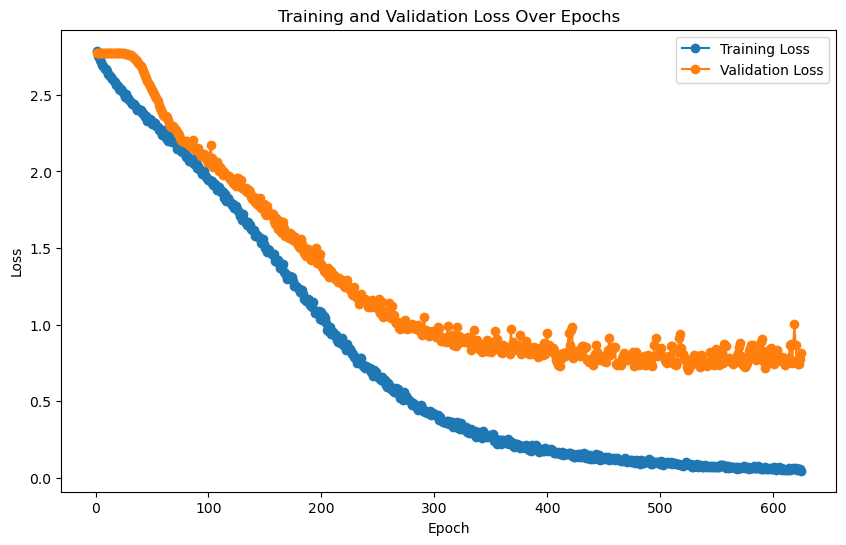

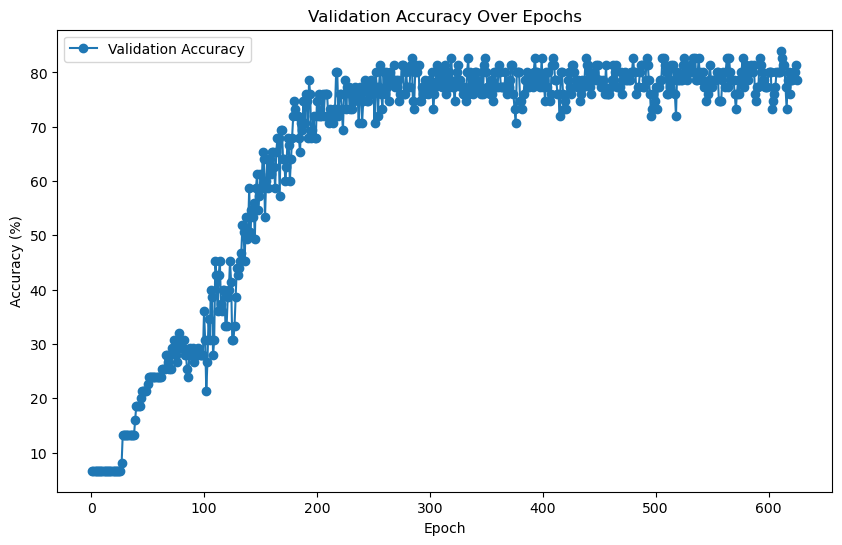


Evaluating on the test set...
    Test Batch [1/39], Loss: 1.9302



Final Test Loss: 1.3507, Test Accuracy: 59.59%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/39 for test dataset.
  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (75, 64), Validation labels shape: (75,)
LOG: Test features shape: (9854, 64), Test labels shape: (9854,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 54.67%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.33      0.20      0.25         5
           2       0.00      0.00      0.00         5
           3       0.33      0.60      0.43         5
           4       0.67      0.40      0.50         5
           5       0.67      0.80      0.73         5
           6       0.50      0.80      0.62         5
           7       0.80      0.80      0.80         5
           8       0.00      0.00  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (75, 64)
Val labels shape: (75,)
Test reps shape: (9854, 64)
Test labels shape: (9854,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7570  |  Val Loss: 2.6966
Validation loss improved from inf to 2.6966.
[Epoch 2/1000] Train Loss: 2.6583  |  Val Loss: 2.6331
Validation loss improved from 2.6966 to 2.6331.
[Epoch 3/1000] Train Loss: 2.5884  |  Val Loss: 2.5721
Validation loss improved from 2.6331 to 2.5721.
[Epoch 4/1000] Train Loss: 2.5300  |  Val Loss: 2.5167
Validation loss improved from 2.5721 to 2.5167.
[Epoch 5/1000] Train Loss: 2.4725  |  Val Loss: 2.4540
Validation loss improved from 2.5167 to 2.4540.
[Epoch 6/1000] Train Loss: 2.4096  |  Val Loss: 2.4074
Validation loss improved from 2.4540 to 2.4074.
[Epoch 7/1000] Train Loss: 2.3526  |  Val Loss: 2.3624
Validation loss improved from 2.4074 to 2.3624.
[Epoch 8/1000] Train Loss: 2.2876  |  Val Loss: 2.3141
Validation loss improved from 2.3624 to 2.3141.
[Epoch 9/1000] Train Loss: 2.2251  |  Val Loss: 2.2593
Validation loss improved from 2.3141 to 2.2593.
[Epoch 10/1000] Train Loss: 2.1617  |  Val Loss: 2.1999
Validation loss impr

[Epoch 13/1000] Train Loss: 1.9390  |  Val Loss: 2.0272
Validation loss improved from 2.0707 to 2.0272.
[Epoch 14/1000] Train Loss: 1.8611  |  Val Loss: 1.9594
Validation loss improved from 2.0272 to 1.9594.
[Epoch 15/1000] Train Loss: 1.7876  |  Val Loss: 1.8978
Validation loss improved from 1.9594 to 1.8978.
[Epoch 16/1000] Train Loss: 1.7258  |  Val Loss: 1.8591
Validation loss improved from 1.8978 to 1.8591.
[Epoch 17/1000] Train Loss: 1.6614  |  Val Loss: 1.7850
Validation loss improved from 1.8591 to 1.7850.
[Epoch 18/1000] Train Loss: 1.5994  |  Val Loss: 1.7600
Validation loss improved from 1.7850 to 1.7600.
[Epoch 19/1000] Train Loss: 1.5322  |  Val Loss: 1.7105
Validation loss improved from 1.7600 to 1.7105.


[Epoch 20/1000] Train Loss: 1.4669  |  Val Loss: 1.6508
Validation loss improved from 1.7105 to 1.6508.
[Epoch 21/1000] Train Loss: 1.4299  |  Val Loss: 1.6213
Validation loss improved from 1.6508 to 1.6213.
[Epoch 22/1000] Train Loss: 1.3683  |  Val Loss: 1.5770
Validation loss improved from 1.6213 to 1.5770.
[Epoch 23/1000] Train Loss: 1.3384  |  Val Loss: 1.5426
Validation loss improved from 1.5770 to 1.5426.
[Epoch 24/1000] Train Loss: 1.2962  |  Val Loss: 1.5125
Validation loss improved from 1.5426 to 1.5125.
[Epoch 25/1000] Train Loss: 1.2549  |  Val Loss: 1.4883
Validation loss improved from 1.5125 to 1.4883.
[Epoch 26/1000] Train Loss: 1.2287  |  Val Loss: 1.4655
Validation loss improved from 1.4883 to 1.4655.
[Epoch 27/1000] Train Loss: 1.2044  |  Val Loss: 1.4480
Validation loss improved from 1.4655 to 1.4480.
[Epoch 28/1000] Train Loss: 1.1770  |  Val Loss: 1.4288
Validation loss improved from 1.4480 to 1.4288.
[Epoch 29/1000] Train Loss: 1.1579  |  Val Loss: 1.4080
Validati

[Epoch 31/1000] Train Loss: 1.1164  |  Val Loss: 1.3764
Validation loss improved from 1.4057 to 1.3764.
[Epoch 32/1000] Train Loss: 1.0941  |  Val Loss: 1.3535
Validation loss improved from 1.3764 to 1.3535.
[Epoch 33/1000] Train Loss: 1.0817  |  Val Loss: 1.3657
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 1.0594  |  Val Loss: 1.3530
Validation loss improved from 1.3535 to 1.3530.
[Epoch 35/1000] Train Loss: 1.0415  |  Val Loss: 1.3378
Validation loss improved from 1.3530 to 1.3378.
[Epoch 36/1000] Train Loss: 1.0385  |  Val Loss: 1.3188
Validation loss improved from 1.3378 to 1.3188.
[Epoch 37/1000] Train Loss: 1.0259  |  Val Loss: 1.3320
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 38/1000] Train Loss: 1.0023  |  Val Loss: 1.3057
Validation loss improved from 1.3188 to 1.3057.
[Epoch 39/1000] Train Loss: 0.9901  |  Val Loss: 1.2996
Validation loss improved from 1.3057 to 1.2996.
[Epoch 40/1000] Train Loss: 0.9657  |  Val Loss: 1.3151
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.9628  |  Val Loss: 1.2940
Validation loss improved from 1.2996 to 1.2940.
[Epoch 42/1000] Train Loss: 0.9524  |  Val Loss: 1.2576
Validation loss improved from 1.2940 to 1.2576.
[Epoch 43/1000] Train Loss: 0.9351  |  Val Loss: 1.2917
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.9341  |  Val Loss: 1.2689
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 0.9285  |  Val Loss: 1.2588
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 46/1000] Train Loss: 0.8996  |  Val Loss: 1.2674
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 47/1000] Train Loss: 0.9010

[Epoch 50/1000] Train Loss: 0.8615  |  Val Loss: 1.2432
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.8578  |  Val Loss: 1.2351
Validation loss improved from 1.2421 to 1.2351.
[Epoch 52/1000] Train Loss: 0.8410  |  Val Loss: 1.2280
Validation loss improved from 1.2351 to 1.2280.
[Epoch 53/1000] Train Loss: 0.8371  |  Val Loss: 1.2340
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 0.8292  |  Val Loss: 1.2161
Validation loss improved from 1.2280 to 1.2161.
[Epoch 55/1000] Train Loss: 0.8153  |  Val Loss: 1.2237
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 0.8099  |  Val Loss: 1.2207
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 57/1000] Train Loss: 0.7989  |  Val Loss: 1.2008
Validation loss improved from 1.2161 to 1.2008.
[Epoch 58/1000] Train Loss: 0.7918  |  Val Loss: 1.2086
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 0.7917  |  Val Loss: 1.2055
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 0.7819  |  Val Loss: 1.1998
Validation loss improved from 1.2008 to 1.1998.
[Epoch 61/1000] Train Loss: 0.7750  |  Val Loss: 1.2181
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.7595  |  Val Loss: 1.2165
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 0.7630  |  Val Loss: 1.1940
Validation loss improved from 1.1998 to 1.1940.
[Epoch 64/1000] Train Loss: 0.7577  |  Val Loss: 1.1950
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.7525  |  Val Loss: 1.2014
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 

[Epoch 68/1000] Train Loss: 0.7109  |  Val Loss: 1.1795
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.7209  |  Val Loss: 1.2023
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 0.6973  |  Val Loss: 1.1803
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 71/1000] Train Loss: 0.6938  |  Val Loss: 1.1681
Validation loss improved from 1.1781 to 1.1681.
[Epoch 72/1000] Train Loss: 0.6823  |  Val Loss: 1.1908
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 0.6805  |  Val Loss: 1.1743
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 0.6723  |  Val Loss: 1.1733
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 75/1000] Train Loss: 0.6715  |  Val Loss: 1.1951
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 0.6559  |  Val Loss: 1.1770
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 77/1000] Train Loss: 0.6584  |  Val Loss: 1.1735
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 78/1000] Train Loss: 0.6550  |  Val Loss: 1.1981
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 79/1000] Train Loss: 0.6435  |  Val Loss: 1.1732
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 80/1000] Train Loss: 0.6433  |  Val Loss: 1.1697
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 81/1000] Train Loss: 0.6501  |  Val Loss: 1.1935
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 82/1000] Train Loss: 0.6352  |  Val Loss: 1.2042
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 83/1000] Train Loss: 0.6245  |  Val Loss: 1.1782
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 

[Epoch 85/1000] Train Loss: 0.6121  |  Val Loss: 1.1906
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.6041  |  Val Loss: 1.1849
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 0.5920  |  Val Loss: 1.1760
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 0.5851  |  Val Loss: 1.1847
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 0.5904  |  Val Loss: 1.1703
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 0.5736  |  Val Loss: 1.1824
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] Train Loss: 0.5799  |  Val Loss: 1.1838
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 92/1000] Train Loss: 0.5746  |  Val Loss: 1.1831
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 93/1000] Train Loss: 0.5641  |  Val Loss: 1.1908
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 94/1000] Train Loss: 0.5667  |  Val Loss: 1.1841
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 95/1000] Train Loss: 0.5546  |  Val Loss: 1.1600
Validation loss improved from 1.1655 to 1.1600.
[Epoch 96/1000] Train Loss: 0.5499  |  Val Loss: 1.1957
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 0.5468  |  Val Loss: 1.2004
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 98/1000] Train Loss: 0.5384  |  Val Loss: 1.1794
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 99/1000] Train Loss: 0.5438  |  Val Loss: 1.2077
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 100/1000] Train Loss: 0.5323  |  Val Loss: 1.1860
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 101/100

[Epoch 105/1000] Train Loss: 0.5199  |  Val Loss: 1.2003
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 106/1000] Train Loss: 0.5068  |  Val Loss: 1.1986
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 107/1000] Train Loss: 0.5075  |  Val Loss: 1.1949
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 108/1000] Train Loss: 0.4959  |  Val Loss: 1.2362
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 109/1000] Train Loss: 0.4930  |  Val Loss: 1.1868
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 110/1000] Train Loss: 0.4955  |  Val Loss: 1.2206
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 111/1000] Train Loss: 0.5016  |  Val Loss: 1.2197
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 112/1000] Train Loss: 0.4854  |  Val Loss: 1.2054
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 113/1000] Train Loss: 0.4813  |  Val Loss: 1.2318
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 114/1000] Train Loss: 0.4738  |  Val Loss: 1.2091
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 115/1000] Train Loss: 0.4701  |  Val Loss: 1.2137
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 116/1000] Train Loss: 0.4611  |  Val Loss: 1.2242
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 117/1000] Train Loss: 0.4700  |  Val Loss: 1.2116
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 118/1000] Train Loss: 0.4703  |  Val Loss: 1.2176
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 119/1000] Train Loss: 0.4578  |  Val Loss: 1.2358
!! Validation loss did NOT improve !! Patience:

[Epoch 123/1000] Train Loss: 0.4493  |  Val Loss: 1.2584
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 124/1000] Train Loss: 0.4413  |  Val Loss: 1.2256
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 125/1000] Train Loss: 0.4333  |  Val Loss: 1.2360
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 126/1000] Train Loss: 0.4290  |  Val Loss: 1.2486
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 127/1000] Train Loss: 0.4336  |  Val Loss: 1.2557
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 128/1000] Train Loss: 0.4328  |  Val Loss: 1.2541
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 129/1000] Train Loss: 0.4206  |  Val Loss: 1.2581
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 130/1000] Train Loss: 0.4184  |  Val Loss: 1.2684
!! Validation loss did NOT improve !! Patience: 35/100


[Epoch 131/1000] Train Loss: 0.4142  |  Val Loss: 1.2615
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 132/1000] Train Loss: 0.4235  |  Val Loss: 1.2814
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 133/1000] Train Loss: 0.4318  |  Val Loss: 1.3012
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 134/1000] Train Loss: 0.4231  |  Val Loss: 1.3128
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 135/1000] Train Loss: 0.4062  |  Val Loss: 1.2862
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 136/1000] Train Loss: 0.4131  |  Val Loss: 1.2873
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 137/1000] Train Loss: 0.3949  |  Val Loss: 1.2620
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 138/1000] Train Loss: 0.3958  |  Val Loss: 1.2751
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 139/1000] Train Loss: 0.3866  |  Val Loss: 1.2995
!! Validation loss did NOT improve !! Patience:

[Epoch 142/1000] Train Loss: 0.3891  |  Val Loss: 1.3010
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 143/1000] Train Loss: 0.3801  |  Val Loss: 1.2901
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 144/1000] Train Loss: 0.3748  |  Val Loss: 1.3303
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 145/1000] Train Loss: 0.3760  |  Val Loss: 1.3266
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 146/1000] Train Loss: 0.3665  |  Val Loss: 1.3363
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 147/1000] Train Loss: 0.3680  |  Val Loss: 1.2966
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 148/1000] Train Loss: 0.3674  |  Val Loss: 1.3183
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 149/1000] Train Loss: 0.3616  |  Val Loss: 1.3248
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 150/1000] Train Loss: 0.3711  |  Val Loss: 1.3506
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 151/1000] Train Loss: 0.3645  |  Val Loss: 1.3240
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 152/1000] Train Loss: 0.3776  |  Val Loss: 1.3219
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 153/1000] Train Loss: 0.3656  |  Val Loss: 1.3706
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 154/1000] Train Loss: 0.3588  |  Val Loss: 1.3823
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 155/1000] Train Loss: 0.3536  |  Val Loss: 1.3276
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 156/1000] Train Loss: 0.3545  |  Val Loss: 1.3491
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 157/1000] Train Loss: 0.3615  |  Val Loss: 1.3744
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 158/1000] Train Loss: 0.3410  |  Val Loss: 1.3788
!! Validation loss did NOT improve !! Patience:

[Epoch 160/1000] Train Loss: 0.3528  |  Val Loss: 1.3654
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 161/1000] Train Loss: 0.3396  |  Val Loss: 1.3918
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 162/1000] Train Loss: 0.3287  |  Val Loss: 1.3683
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 163/1000] Train Loss: 0.3339  |  Val Loss: 1.3906
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 164/1000] Train Loss: 0.3361  |  Val Loss: 1.3494
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 165/1000] Train Loss: 0.3262  |  Val Loss: 1.3808
!! Validation loss did NOT improve !! Patience: 70/100


[Epoch 166/1000] Train Loss: 0.3254  |  Val Loss: 1.4438
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 167/1000] Train Loss: 0.3244  |  Val Loss: 1.3867
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 168/1000] Train Loss: 0.3217  |  Val Loss: 1.3739
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 169/1000] Train Loss: 0.3244  |  Val Loss: 1.4175
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 170/1000] Train Loss: 0.3165  |  Val Loss: 1.4228
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 171/1000] Train Loss: 0.3137  |  Val Loss: 1.4137
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 172/1000] Train Loss: 0.3159  |  Val Loss: 1.4155
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 173/1000] Train Loss: 0.3128  |  Val Loss: 1.3762
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 174/1000] Train Loss: 0.3124  |  Val Loss: 1.4661
!! Validation loss did NOT improve !! Patience:

[Epoch 177/1000] Train Loss: 0.3026  |  Val Loss: 1.4333
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 178/1000] Train Loss: 0.2977  |  Val Loss: 1.4384
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 179/1000] Train Loss: 0.3048  |  Val Loss: 1.4713
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 180/1000] Train Loss: 0.2874  |  Val Loss: 1.4069
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 181/1000] Train Loss: 0.2939  |  Val Loss: 1.4405
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 182/1000] Train Loss: 0.2962  |  Val Loss: 1.4762
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 183/1000] Train Loss: 0.2863  |  Val Loss: 1.4562
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 184/1000] Train Loss: 0.2894  |  Val Loss: 1.4420
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 185/1000] Train Loss: 0.2859  |  Val Loss: 1.4674
!! Validation loss did NOT improve !! Patience:

[Epoch 186/1000] Train Loss: 0.2805  |  Val Loss: 1.4645
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 187/1000] Train Loss: 0.2864  |  Val Loss: 1.4879
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 188/1000] Train Loss: 0.2828  |  Val Loss: 1.4603
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 189/1000] Train Loss: 0.2835  |  Val Loss: 1.4801
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 190/1000] Train Loss: 0.2793  |  Val Loss: 1.4899
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 191/1000] Train Loss: 0.2760  |  Val Loss: 1.4798
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 192/1000] Train Loss: 0.2735  |  Val Loss: 1.4715
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 193/1000] Train Loss: 0.2731  |  Val Loss: 1.5366
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 194/1000] Train Loss: 0.2695  |  Val Loss: 1.4681
!! Validation loss did NOT improve !! Patience:

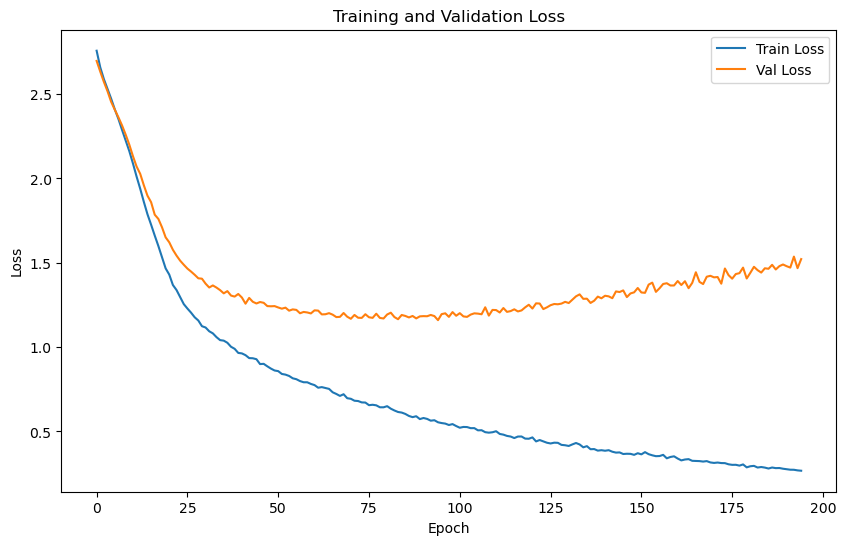

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9798 | Test Accuracy: 50.73%


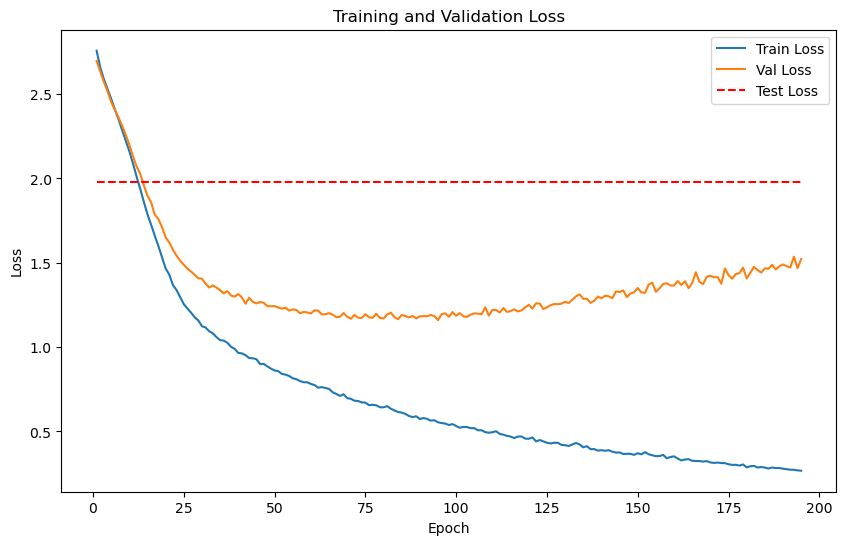

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.0011
Epoch [1/2000], Avg Train Loss: 9.0011
Epoch [1/2000], Avg Val Loss: 5.5727
Validation loss improved from inf to 5.5727. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 8.9284
Epoch [2/2000], Avg Train Loss: 8.9284
Epoch [2/2000], Avg Val Loss: 5.5062
Validation loss improved from 5.5727 to 5.5062. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.7322
Epoch [3/2000], Avg Train Loss: 8.7322
Epoch [3/2000], Avg Val Loss: 5.4417
Validation loss improved from 5.5062 to 5.4417. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.7552
Epoch [4/2000], Avg Train Loss: 8.7552
Epoch [4/2000], Avg Val Loss: 5.3788
Validation loss improved from 5.4417 to 5.3788. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.6002
Epoch [5/2000], Avg Train Loss: 8.6002
Epoch [5/2000], Avg Val Loss: 5.3175
Validation loss improved from 5.3788 to 5.3175. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.6355
Epoch [6/2000], Avg Train Loss: 8.6355
Epoch [6/2000], Avg Val Loss: 5.2577
Validation loss improved from 5.3175 to 5.2577. Saving m

    Batch [1/1], Train Loss: 8.0843
Epoch [14/2000], Avg Train Loss: 8.0843
Epoch [14/2000], Avg Val Loss: 4.8357
Validation loss improved from 4.8830 to 4.8357. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 7.8705
Epoch [15/2000], Avg Train Loss: 7.8705
Epoch [15/2000], Avg Val Loss: 4.7897
Validation loss improved from 4.8357 to 4.7897. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.8357
Epoch [16/2000], Avg Train Loss: 7.8357
Epoch [16/2000], Avg Val Loss: 4.7451
Validation loss improved from 4.7897 to 4.7451. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.7445
Epoch [17/2000], Avg Train Loss: 7.7445
Epoch [17/2000], Avg Val Loss: 4.7018
Validation loss improved from 4.7451 to 4.7018. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.7980
Epoch [18/2000], Avg Train Loss: 7.7980
Epoch [18/2000], Avg Val Loss: 4.6600
Validation loss improved from 4.7018 to 4.

    Batch [1/1], Train Loss: 7.4930
Epoch [21/2000], Avg Train Loss: 7.4930
Epoch [21/2000], Avg Val Loss: 4.5426
Validation loss improved from 4.5803 to 4.5426. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.5049
Epoch [22/2000], Avg Train Loss: 7.5049
Epoch [22/2000], Avg Val Loss: 4.5062
Validation loss improved from 4.5426 to 4.5062. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.3643
Epoch [23/2000], Avg Train Loss: 7.3643
Epoch [23/2000], Avg Val Loss: 4.4711
Validation loss improved from 4.5062 to 4.4711. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 7.3022
Epoch [24/2000], Avg Train Loss: 7.3022
Epoch [24/2000], Avg Val Loss: 4.4375
Validation loss improved from 4.4711 to 4.4375. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 7.3249
Epoch [25/2000], Avg Train Loss: 7.3249
Epoch [25/2000], Avg Val Loss: 4.4050
Validation loss improved from 4.4375 to 4.

    Batch [1/1], Train Loss: 6.8200
Epoch [34/2000], Avg Train Loss: 6.8200
Epoch [34/2000], Avg Val Loss: 4.1631
Validation loss improved from 4.1859 to 4.1631. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.7430
Epoch [35/2000], Avg Train Loss: 6.7430
Epoch [35/2000], Avg Val Loss: 4.1412
Validation loss improved from 4.1631 to 4.1412. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.7003
Epoch [36/2000], Avg Train Loss: 6.7003
Epoch [36/2000], Avg Val Loss: 4.1202
Validation loss improved from 4.1412 to 4.1202. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 6.7169
Epoch [37/2000], Avg Train Loss: 6.7169
Epoch [37/2000], Avg Val Loss: 4.1000
Validation loss improved from 4.1202 to 4.1000. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.6539
Epoch [38/2000], Avg Train Loss: 6.6539
Epoch [38/2000], Avg Val Loss: 4.0805
Validation loss improved from 4.1000 to 4.

    Batch [1/1], Train Loss: 6.3464
Epoch [45/2000], Avg Train Loss: 6.3464
Epoch [45/2000], Avg Val Loss: 3.9642
Validation loss improved from 3.9788 to 3.9642. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.3497
Epoch [46/2000], Avg Train Loss: 6.3497
Epoch [46/2000], Avg Val Loss: 3.9501
Validation loss improved from 3.9642 to 3.9501. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.2686
Epoch [47/2000], Avg Train Loss: 6.2686
Epoch [47/2000], Avg Val Loss: 3.9366
Validation loss improved from 3.9501 to 3.9366. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.3184
Epoch [48/2000], Avg Train Loss: 6.3184
Epoch [48/2000], Avg Val Loss: 3.9236
Validation loss improved from 3.9366 to 3.9236. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 6.2951
Epoch [49/2000], Avg Train Loss: 6.2951
Epoch [49/2000], Avg Val Loss: 3.9112
Validation loss improved from 3.9236 to 3.

    Batch [1/1], Train Loss: 6.0117
Epoch [55/2000], Avg Train Loss: 6.0117
Epoch [55/2000], Avg Val Loss: 3.8464
Validation loss improved from 3.8561 to 3.8464. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0878
Epoch [56/2000], Avg Train Loss: 6.0878
Epoch [56/2000], Avg Val Loss: 3.8371
Validation loss improved from 3.8464 to 3.8371. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 6.0138
Epoch [57/2000], Avg Train Loss: 6.0138
Epoch [57/2000], Avg Val Loss: 3.8282
Validation loss improved from 3.8371 to 3.8282. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.9895
Epoch [58/2000], Avg Train Loss: 5.9895
Epoch [58/2000], Avg Val Loss: 3.8198
Validation loss improved from 3.8282 to 3.8198. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 6.0344
Epoch [59/2000], Avg Train Loss: 6.0344
Epoch [59/2000], Avg Val Loss: 3.8116
Validation loss improved from 3.8198 to 3.

    Batch [1/1], Train Loss: 5.7185
Epoch [71/2000], Avg Train Loss: 5.7185
Epoch [71/2000], Avg Val Loss: 3.7350
Validation loss improved from 3.7402 to 3.7350. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.7454
Epoch [72/2000], Avg Train Loss: 5.7454
Epoch [72/2000], Avg Val Loss: 3.7299
Validation loss improved from 3.7350 to 3.7299. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.7103
Epoch [73/2000], Avg Train Loss: 5.7103
Epoch [73/2000], Avg Val Loss: 3.7251
Validation loss improved from 3.7299 to 3.7251. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.6850
Epoch [74/2000], Avg Train Loss: 5.6850
Epoch [74/2000], Avg Val Loss: 3.7204
Validation loss improved from 3.7251 to 3.7204. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7353
Epoch [75/2000], Avg Train Loss: 5.7353
Epoch [75/2000], Avg Val Loss: 3.7158
Validation loss improved from 3.7204 to 3.

Epoch [80/2000], Avg Val Loss: 3.6951
Validation loss improved from 3.6990 to 3.6951. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.6675
Epoch [81/2000], Avg Train Loss: 5.6675
Epoch [81/2000], Avg Val Loss: 3.6914
Validation loss improved from 3.6951 to 3.6914. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 5.6743
Epoch [82/2000], Avg Train Loss: 5.6743
Epoch [82/2000], Avg Val Loss: 3.6878
Validation loss improved from 3.6914 to 3.6878. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 5.6450
Epoch [83/2000], Avg Train Loss: 5.6450
Epoch [83/2000], Avg Val Loss: 3.6843
Validation loss improved from 3.6878 to 3.6843. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.5809
Epoch [84/2000], Avg Train Loss: 5.5809
Epoch [84/2000], Avg Val Loss: 3.6809
Validation loss improved from 3.6843 to 3.6809. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.5508
Epoch [93/2000], Avg Train Loss: 5.5508
Epoch [93/2000], Avg Val Loss: 3.6535
Validation loss improved from 3.6563 to 3.6535. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.5692
Epoch [94/2000], Avg Train Loss: 5.5692
Epoch [94/2000], Avg Val Loss: 3.6508
Validation loss improved from 3.6535 to 3.6508. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.5642
Epoch [95/2000], Avg Train Loss: 5.5642
Epoch [95/2000], Avg Val Loss: 3.6481
Validation loss improved from 3.6508 to 3.6481. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.5330
Epoch [96/2000], Avg Train Loss: 5.5330
Epoch [96/2000], Avg Val Loss: 3.6456
Validation loss improved from 3.6481 to 3.6456. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.4293
Epoch [97/2000], Avg Train Loss: 5.4293
Epoch [97/2000], Avg Val Loss: 3.6431
Validation loss improved from 3.6456 to 3.

    Batch [1/1], Train Loss: 5.4645
Epoch [109/2000], Avg Train Loss: 5.4645
Epoch [109/2000], Avg Val Loss: 3.6165
Validation loss improved from 3.6185 to 3.6165. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.4076
Epoch [110/2000], Avg Train Loss: 5.4076
Epoch [110/2000], Avg Val Loss: 3.6146
Validation loss improved from 3.6165 to 3.6146. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.3982
Epoch [111/2000], Avg Train Loss: 5.3982
Epoch [111/2000], Avg Val Loss: 3.6126
Validation loss improved from 3.6146 to 3.6126. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.4048
Epoch [112/2000], Avg Train Loss: 5.4048
Epoch [112/2000], Avg Val Loss: 3.6107
Validation loss improved from 3.6126 to 3.6107. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 5.4322
Epoch [113/2000], Avg Train Loss: 5.4322
Epoch [113/2000], Avg Val Loss: 3.6088
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3748
Epoch [116/2000], Avg Train Loss: 5.3748
Epoch [116/2000], Avg Val Loss: 3.6031
Validation loss improved from 3.6050 to 3.6031. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 5.4053
Epoch [117/2000], Avg Train Loss: 5.4053
Epoch [117/2000], Avg Val Loss: 3.6013
Validation loss improved from 3.6031 to 3.6013. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 5.3396
Epoch [118/2000], Avg Train Loss: 5.3396
Epoch [118/2000], Avg Val Loss: 3.5995
Validation loss improved from 3.6013 to 3.5995. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 5.3912
Epoch [119/2000], Avg Train Loss: 5.3912
Epoch [119/2000], Avg Val Loss: 3.5977
Validation loss improved from 3.5995 to 3.5977. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 5.3971
Epoch [120/2000], Avg Train Loss: 5.3971
Epoch [120/2000], Avg Val Loss: 3.5959
Validation loss improved fro

    Batch [1/1], Train Loss: 5.3087
Epoch [129/2000], Avg Train Loss: 5.3087
Epoch [129/2000], Avg Val Loss: 3.5810
Validation loss improved from 3.5826 to 3.5810. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 5.3375
Epoch [130/2000], Avg Train Loss: 5.3375
Epoch [130/2000], Avg Val Loss: 3.5794
Validation loss improved from 3.5810 to 3.5794. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 5.3753
Epoch [131/2000], Avg Train Loss: 5.3753
Epoch [131/2000], Avg Val Loss: 3.5779
Validation loss improved from 3.5794 to 3.5779. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 5.3555
Epoch [132/2000], Avg Train Loss: 5.3555
Epoch [132/2000], Avg Val Loss: 3.5763
Validation loss improved from 3.5779 to 3.5763. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 5.2919
Epoch [133/2000], Avg Train Loss: 5.2919
Epoch [133/2000], Avg Val Loss: 3.5748
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2902
Epoch [145/2000], Avg Train Loss: 5.2902
Epoch [145/2000], Avg Val Loss: 3.5575
Validation loss improved from 3.5589 to 3.5575. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 5.2875
Epoch [146/2000], Avg Train Loss: 5.2875
Epoch [146/2000], Avg Val Loss: 3.5561
Validation loss improved from 3.5575 to 3.5561. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 5.2383
Epoch [147/2000], Avg Train Loss: 5.2383
Epoch [147/2000], Avg Val Loss: 3.5548
Validation loss improved from 3.5561 to 3.5548. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 5.2292
Epoch [148/2000], Avg Train Loss: 5.2292
Epoch [148/2000], Avg Val Loss: 3.5534
Validation loss improved from 3.5548 to 3.5534. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 5.2589
Epoch [149/2000], Avg Train Loss: 5.2589
Epoch [149/2000], Avg Val Loss: 3.5521
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2201
Epoch [153/2000], Avg Train Loss: 5.2201
Epoch [153/2000], Avg Val Loss: 3.5469
Validation loss improved from 3.5481 to 3.5469. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 5.2200
Epoch [154/2000], Avg Train Loss: 5.2200
Epoch [154/2000], Avg Val Loss: 3.5456
Validation loss improved from 3.5469 to 3.5456. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 5.2063
Epoch [155/2000], Avg Train Loss: 5.2063
Epoch [155/2000], Avg Val Loss: 3.5444
Validation loss improved from 3.5456 to 3.5444. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 5.2525
Epoch [156/2000], Avg Train Loss: 5.2525
Epoch [156/2000], Avg Val Loss: 3.5431
Validation loss improved from 3.5444 to 3.5431. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 5.2001
Epoch [157/2000], Avg Train Loss: 5.2001
Epoch [157/2000], Avg Val Loss: 3.5418
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1925
Epoch [165/2000], Avg Train Loss: 5.1925
Epoch [165/2000], Avg Val Loss: 3.5324
Validation loss improved from 3.5335 to 3.5324. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.1716
Epoch [166/2000], Avg Train Loss: 5.1716
Epoch [166/2000], Avg Val Loss: 3.5312
Validation loss improved from 3.5324 to 3.5312. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.2258
Epoch [167/2000], Avg Train Loss: 5.2258
Epoch [167/2000], Avg Val Loss: 3.5301
Validation loss improved from 3.5312 to 3.5301. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2166
Epoch [168/2000], Avg Train Loss: 5.2166
Epoch [168/2000], Avg Val Loss: 3.5291
Validation loss improved from 3.5301 to 3.5291. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.1863
Epoch [169/2000], Avg Train Loss: 5.1863
Epoch [169/2000], Avg Val Loss: 3.5280
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1522
Epoch [180/2000], Avg Train Loss: 5.1522
Epoch [180/2000], Avg Val Loss: 3.5172
Validation loss improved from 3.5182 to 3.5172. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 5.1447
Epoch [181/2000], Avg Train Loss: 5.1447
Epoch [181/2000], Avg Val Loss: 3.5163
Validation loss improved from 3.5172 to 3.5163. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 5.1663
Epoch [182/2000], Avg Train Loss: 5.1663
Epoch [182/2000], Avg Val Loss: 3.5154
Validation loss improved from 3.5163 to 3.5154. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 5.1413
Epoch [183/2000], Avg Train Loss: 5.1413
Epoch [183/2000], Avg Val Loss: 3.5145
Validation loss improved from 3.5154 to 3.5145. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 5.1151
Epoch [184/2000], Avg Train Loss: 5.1151
Epoch [184/2000], Avg Val Loss: 3.5136
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1099
Epoch [187/2000], Avg Train Loss: 5.1099
Epoch [187/2000], Avg Val Loss: 3.5108
Validation loss improved from 3.5117 to 3.5108. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 5.1634
Epoch [188/2000], Avg Train Loss: 5.1634
Epoch [188/2000], Avg Val Loss: 3.5099
Validation loss improved from 3.5108 to 3.5099. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 5.1313
Epoch [189/2000], Avg Train Loss: 5.1313
Epoch [189/2000], Avg Val Loss: 3.5090
Validation loss improved from 3.5099 to 3.5090. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 5.1440
Epoch [190/2000], Avg Train Loss: 5.1440
Epoch [190/2000], Avg Val Loss: 3.5081
Validation loss improved from 3.5090 to 3.5081. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 5.1124
Epoch [191/2000], Avg Train Loss: 5.1124
Epoch [191/2000], Avg Val Loss: 3.5071
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1387
Epoch [198/2000], Avg Train Loss: 5.1387
Epoch [198/2000], Avg Val Loss: 3.5010
Validation loss improved from 3.5019 to 3.5010. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 5.1019
Epoch [199/2000], Avg Train Loss: 5.1019
Epoch [199/2000], Avg Val Loss: 3.5001
Validation loss improved from 3.5010 to 3.5001. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 5.1484
Epoch [200/2000], Avg Train Loss: 5.1484
Epoch [200/2000], Avg Val Loss: 3.4993
Validation loss improved from 3.5001 to 3.4993. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.0842
Epoch [201/2000], Avg Train Loss: 5.0842
Epoch [201/2000], Avg Val Loss: 3.4985
Validation loss improved from 3.4993 to 3.4985. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.0860
Epoch [202/2000], Avg Train Loss: 5.0860
Epoch [202/2000], Avg Val Loss: 3.4976
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0653
Epoch [216/2000], Avg Train Loss: 5.0653
Epoch [216/2000], Avg Val Loss: 3.4867
Validation loss improved from 3.4873 to 3.4867. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 5.0763
Epoch [217/2000], Avg Train Loss: 5.0763
Epoch [217/2000], Avg Val Loss: 3.4860
Validation loss improved from 3.4867 to 3.4860. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 5.0170
Epoch [218/2000], Avg Train Loss: 5.0170
Epoch [218/2000], Avg Val Loss: 3.4852
Validation loss improved from 3.4860 to 3.4852. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 5.1011
Epoch [219/2000], Avg Train Loss: 5.1011
Epoch [219/2000], Avg Val Loss: 3.4845
Validation loss improved from 3.4852 to 3.4845. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 5.0900
Epoch [220/2000], Avg Train Loss: 5.0900
Epoch [220/2000], Avg Val Loss: 3.4838
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0454
Epoch [223/2000], Avg Train Loss: 5.0454
Epoch [223/2000], Avg Val Loss: 3.4816
Validation loss improved from 3.4823 to 3.4816. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 5.0581
Epoch [224/2000], Avg Train Loss: 5.0581
Epoch [224/2000], Avg Val Loss: 3.4809
Validation loss improved from 3.4816 to 3.4809. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 5.0678
Epoch [225/2000], Avg Train Loss: 5.0678
Epoch [225/2000], Avg Val Loss: 3.4802
Validation loss improved from 3.4809 to 3.4802. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 5.0666
Epoch [226/2000], Avg Train Loss: 5.0666
Epoch [226/2000], Avg Val Loss: 3.4795
Validation loss improved from 3.4802 to 3.4795. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 5.0649
Epoch [227/2000], Avg Train Loss: 5.0649
Epoch [227/2000], Avg Val Loss: 3.4788
Validation loss improved fro

Epoch [233/2000], Avg Val Loss: 3.4747
Validation loss improved from 3.4753 to 3.4747. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 5.0472
Epoch [234/2000], Avg Train Loss: 5.0472
Epoch [234/2000], Avg Val Loss: 3.4740
Validation loss improved from 3.4747 to 3.4740. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 5.0400
Epoch [235/2000], Avg Train Loss: 5.0400
Epoch [235/2000], Avg Val Loss: 3.4733
Validation loss improved from 3.4740 to 3.4733. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 5.0536
Epoch [236/2000], Avg Train Loss: 5.0536
Epoch [236/2000], Avg Val Loss: 3.4727
Validation loss improved from 3.4733 to 3.4727. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 5.0232
Epoch [237/2000], Avg Train Loss: 5.0232
Epoch [237/2000], Avg Val Loss: 3.4720
Validation loss improved from 3.4727 to 3.4720. Saving model...

LOG: Epoch [238/2000] - Training
    Bat

Epoch [250/2000], Avg Val Loss: 3.4637
Validation loss improved from 3.4642 to 3.4637. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 5.0214
Epoch [251/2000], Avg Train Loss: 5.0214
Epoch [251/2000], Avg Val Loss: 3.4631
Validation loss improved from 3.4637 to 3.4631. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 5.0092
Epoch [252/2000], Avg Train Loss: 5.0092
Epoch [252/2000], Avg Val Loss: 3.4626
Validation loss improved from 3.4631 to 3.4626. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 5.0517
Epoch [253/2000], Avg Train Loss: 5.0517
Epoch [253/2000], Avg Val Loss: 3.4621
Validation loss improved from 3.4626 to 3.4621. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 5.0029
Epoch [254/2000], Avg Train Loss: 5.0029
Epoch [254/2000], Avg Val Loss: 3.4615
Validation loss improved from 3.4621 to 3.4615. Saving model...

LOG: Epoch [255/2000] - Training
    Bat

Epoch [256/2000], Avg Val Loss: 3.4605
Validation loss improved from 3.4610 to 3.4605. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 5.0329
Epoch [257/2000], Avg Train Loss: 5.0329
Epoch [257/2000], Avg Val Loss: 3.4599
Validation loss improved from 3.4605 to 3.4599. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 5.0236
Epoch [258/2000], Avg Train Loss: 5.0236
Epoch [258/2000], Avg Val Loss: 3.4594
Validation loss improved from 3.4599 to 3.4594. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 5.0258
Epoch [259/2000], Avg Train Loss: 5.0258
Epoch [259/2000], Avg Val Loss: 3.4589
Validation loss improved from 3.4594 to 3.4589. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 5.0105
Epoch [260/2000], Avg Train Loss: 5.0105
Epoch [260/2000], Avg Val Loss: 3.4583
Validation loss improved from 3.4589 to 3.4583. Saving model...

LOG: Epoch [261/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9659
Epoch [270/2000], Avg Train Loss: 4.9659
Epoch [270/2000], Avg Val Loss: 3.4532
Validation loss improved from 3.4537 to 3.4532. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 4.9704
Epoch [271/2000], Avg Train Loss: 4.9704
Epoch [271/2000], Avg Val Loss: 3.4527
Validation loss improved from 3.4532 to 3.4527. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 4.9541
Epoch [272/2000], Avg Train Loss: 4.9541
Epoch [272/2000], Avg Val Loss: 3.4522
Validation loss improved from 3.4527 to 3.4522. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 5.0000
Epoch [273/2000], Avg Train Loss: 5.0000
Epoch [273/2000], Avg Val Loss: 3.4517
Validation loss improved from 3.4522 to 3.4517. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.9951
Epoch [274/2000], Avg Train Loss: 4.9951
Epoch [274/2000], Avg Val Loss: 3.4512
Validation loss improved fro

Epoch [288/2000], Avg Val Loss: 3.4452
Validation loss improved from 3.4455 to 3.4452. Saving model...

LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 4.9578
Epoch [289/2000], Avg Train Loss: 4.9578
Epoch [289/2000], Avg Val Loss: 3.4449
Validation loss improved from 3.4452 to 3.4449. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.9808
Epoch [290/2000], Avg Train Loss: 4.9808
Epoch [290/2000], Avg Val Loss: 3.4446
Validation loss improved from 3.4449 to 3.4446. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.9731
Epoch [291/2000], Avg Train Loss: 4.9731
Epoch [291/2000], Avg Val Loss: 3.4443
Validation loss improved from 3.4446 to 3.4443. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.9418
Epoch [292/2000], Avg Train Loss: 4.9418
Epoch [292/2000], Avg Val Loss: 3.4440
Validation loss improved from 3.4443 to 3.4440. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.9511
Epoch [293/2000], Avg Train Loss: 4.9511
Epoch [293/2000], Avg Val Loss: 3.4437
Validation loss improved fro

Epoch [306/2000], Avg Val Loss: 3.4397
Validation loss improved from 3.4400 to 3.4397. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.9204
Epoch [307/2000], Avg Train Loss: 4.9204
Epoch [307/2000], Avg Val Loss: 3.4394
Validation loss improved from 3.4397 to 3.4394. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.9433
Epoch [308/2000], Avg Train Loss: 4.9433
Epoch [308/2000], Avg Val Loss: 3.4390
Validation loss improved from 3.4394 to 3.4390. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 4.9395
Epoch [309/2000], Avg Train Loss: 4.9395
Epoch [309/2000], Avg Val Loss: 3.4387
Validation loss improved from 3.4390 to 3.4387. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 4.8935
Epoch [310/2000], Avg Train Loss: 4.8935
Epoch [310/2000], Avg Val Loss: 3.4384
Validation loss improved from 3.4387 to 3.4384. Saving model...

LOG: Epoch [311/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8988
Epoch [325/2000], Avg Train Loss: 4.8988
Epoch [325/2000], Avg Val Loss: 3.4338
Validation loss improved from 3.4341 to 3.4338. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 4.8959
Epoch [326/2000], Avg Train Loss: 4.8959
Epoch [326/2000], Avg Val Loss: 3.4335
Validation loss improved from 3.4338 to 3.4335. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.8919
Epoch [327/2000], Avg Train Loss: 4.8919
Epoch [327/2000], Avg Val Loss: 3.4332
Validation loss improved from 3.4335 to 3.4332. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.8976
Epoch [328/2000], Avg Train Loss: 4.8976
Epoch [328/2000], Avg Val Loss: 3.4330
Validation loss improved from 3.4332 to 3.4330. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.8956
Epoch [329/2000], Avg Train Loss: 4.8956
Epoch [329/2000], Avg Val Loss: 3.4328
Validation loss improved fro

Epoch [340/2000], Avg Val Loss: 3.4298
Validation loss improved from 3.4301 to 3.4298. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 4.8835
Epoch [341/2000], Avg Train Loss: 4.8835
Epoch [341/2000], Avg Val Loss: 3.4296
Validation loss improved from 3.4298 to 3.4296. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 4.8998
Epoch [342/2000], Avg Train Loss: 4.8998
Epoch [342/2000], Avg Val Loss: 3.4293
Validation loss improved from 3.4296 to 3.4293. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 4.8844
Epoch [343/2000], Avg Train Loss: 4.8844
Epoch [343/2000], Avg Val Loss: 3.4290
Validation loss improved from 3.4293 to 3.4290. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.8994
Epoch [344/2000], Avg Train Loss: 4.8994
Epoch [344/2000], Avg Val Loss: 3.4287
Validation loss improved from 3.4290 to 3.4287. Saving model...

LOG: Epoch [345/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8560
Epoch [361/2000], Avg Train Loss: 4.8560
Epoch [361/2000], Avg Val Loss: 3.4239
Validation loss improved from 3.4242 to 3.4239. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.8447
Epoch [362/2000], Avg Train Loss: 4.8447
Epoch [362/2000], Avg Val Loss: 3.4237
Validation loss improved from 3.4239 to 3.4237. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.8659
Epoch [363/2000], Avg Train Loss: 4.8659
Epoch [363/2000], Avg Val Loss: 3.4234
Validation loss improved from 3.4237 to 3.4234. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.8657
Epoch [364/2000], Avg Train Loss: 4.8657
Epoch [364/2000], Avg Val Loss: 3.4232
Validation loss improved from 3.4234 to 3.4232. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.8540
Epoch [365/2000], Avg Train Loss: 4.8540
Epoch [365/2000], Avg Val Loss: 3.4230
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8321
Epoch [378/2000], Avg Train Loss: 4.8321
Epoch [378/2000], Avg Val Loss: 3.4198
Validation loss improved from 3.4201 to 3.4198. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.8309
Epoch [379/2000], Avg Train Loss: 4.8309
Epoch [379/2000], Avg Val Loss: 3.4196
Validation loss improved from 3.4198 to 3.4196. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.8486
Epoch [380/2000], Avg Train Loss: 4.8486
Epoch [380/2000], Avg Val Loss: 3.4193
Validation loss improved from 3.4196 to 3.4193. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 4.8402
Epoch [381/2000], Avg Train Loss: 4.8402
Epoch [381/2000], Avg Val Loss: 3.4191
Validation loss improved from 3.4193 to 3.4191. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 4.8619
Epoch [382/2000], Avg Train Loss: 4.8619
Epoch [382/2000], Avg Val Loss: 3.4189
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8105
Epoch [397/2000], Avg Train Loss: 4.8105
Epoch [397/2000], Avg Val Loss: 3.4159
Validation loss improved from 3.4162 to 3.4159. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.8191
Epoch [398/2000], Avg Train Loss: 4.8191
Epoch [398/2000], Avg Val Loss: 3.4157
Validation loss improved from 3.4159 to 3.4157. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 4.8272
Epoch [399/2000], Avg Train Loss: 4.8272
Epoch [399/2000], Avg Val Loss: 3.4155
Validation loss improved from 3.4157 to 3.4155. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 4.8555
Epoch [400/2000], Avg Train Loss: 4.8555
Epoch [400/2000], Avg Val Loss: 3.4153
Validation loss improved from 3.4155 to 3.4153. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 4.8557
Epoch [401/2000], Avg Train Loss: 4.8557
Epoch [401/2000], Avg Val Loss: 3.4151
Validation loss improved fro

Epoch [416/2000], Avg Val Loss: 3.4118
Validation loss improved from 3.4120 to 3.4118. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.8159
Epoch [417/2000], Avg Train Loss: 4.8159
Epoch [417/2000], Avg Val Loss: 3.4116
Validation loss improved from 3.4118 to 3.4116. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 4.8269
Epoch [418/2000], Avg Train Loss: 4.8269
Epoch [418/2000], Avg Val Loss: 3.4113
Validation loss improved from 3.4116 to 3.4113. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.7903
Epoch [419/2000], Avg Train Loss: 4.7903
Epoch [419/2000], Avg Val Loss: 3.4111
Validation loss improved from 3.4113 to 3.4111. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 4.7938
Epoch [420/2000], Avg Train Loss: 4.7938
Epoch [420/2000], Avg Val Loss: 3.4109
Validation loss improved from 3.4111 to 3.4109. Saving model...

LOG: Epoch [421/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7840
Epoch [434/2000], Avg Train Loss: 4.7840
Epoch [434/2000], Avg Val Loss: 3.4087
Validation loss improved from 3.4089 to 3.4087. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.7984
Epoch [435/2000], Avg Train Loss: 4.7984
Epoch [435/2000], Avg Val Loss: 3.4085
Validation loss improved from 3.4087 to 3.4085. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.7862
Epoch [436/2000], Avg Train Loss: 4.7862
Epoch [436/2000], Avg Val Loss: 3.4083
Validation loss improved from 3.4085 to 3.4083. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.8041
Epoch [437/2000], Avg Train Loss: 4.8041
Epoch [437/2000], Avg Val Loss: 3.4081
Validation loss improved from 3.4083 to 3.4081. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.7912
Epoch [438/2000], Avg Train Loss: 4.7912
Epoch [438/2000], Avg Val Loss: 3.4078
Validation loss improved fro

Epoch [451/2000], Avg Val Loss: 3.4053
Validation loss improved from 3.4055 to 3.4053. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 4.7761
Epoch [452/2000], Avg Train Loss: 4.7761
Epoch [452/2000], Avg Val Loss: 3.4052
Validation loss improved from 3.4053 to 3.4052. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.7558
Epoch [453/2000], Avg Train Loss: 4.7558
Epoch [453/2000], Avg Val Loss: 3.4051
Validation loss improved from 3.4052 to 3.4051. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.7512
Epoch [454/2000], Avg Train Loss: 4.7512
Epoch [454/2000], Avg Val Loss: 3.4051
Validation loss improved from 3.4051 to 3.4051. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.8034
Epoch [455/2000], Avg Train Loss: 4.8034
Epoch [455/2000], Avg Val Loss: 3.4049
Validation loss improved from 3.4051 to 3.4049. Saving model...

LOG: Epoch [456/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7839
Epoch [471/2000], Avg Train Loss: 4.7839
Epoch [471/2000], Avg Val Loss: 3.4028
Validation loss improved from 3.4030 to 3.4028. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 4.7850
Epoch [472/2000], Avg Train Loss: 4.7850
Epoch [472/2000], Avg Val Loss: 3.4027
Validation loss improved from 3.4028 to 3.4027. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.7513
Epoch [473/2000], Avg Train Loss: 4.7513
Epoch [473/2000], Avg Val Loss: 3.4025
Validation loss improved from 3.4027 to 3.4025. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.7355
Epoch [474/2000], Avg Train Loss: 4.7355
Epoch [474/2000], Avg Val Loss: 3.4023
Validation loss improved from 3.4025 to 3.4023. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.7880
Epoch [475/2000], Avg Train Loss: 4.7880
Epoch [475/2000], Avg Val Loss: 3.4022
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7731
Epoch [489/2000], Avg Train Loss: 4.7731
Epoch [489/2000], Avg Val Loss: 3.3997
Validation loss improved from 3.4000 to 3.3997. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 4.7470
Epoch [490/2000], Avg Train Loss: 4.7470
Epoch [490/2000], Avg Val Loss: 3.3994
Validation loss improved from 3.3997 to 3.3994. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.7579
Epoch [491/2000], Avg Train Loss: 4.7579
Epoch [491/2000], Avg Val Loss: 3.3991
Validation loss improved from 3.3994 to 3.3991. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.7296
Epoch [492/2000], Avg Train Loss: 4.7296
Epoch [492/2000], Avg Val Loss: 3.3989
Validation loss improved from 3.3991 to 3.3989. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.7521
Epoch [493/2000], Avg Train Loss: 4.7521
Epoch [493/2000], Avg Val Loss: 3.3987
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7165
Epoch [508/2000], Avg Train Loss: 4.7165
Epoch [508/2000], Avg Val Loss: 3.3961
Validation loss improved from 3.3962 to 3.3961. Saving model...

LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 4.7614
Epoch [509/2000], Avg Train Loss: 4.7614
Epoch [509/2000], Avg Val Loss: 3.3960
Validation loss improved from 3.3961 to 3.3960. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 4.7232
Epoch [510/2000], Avg Train Loss: 4.7232
Epoch [510/2000], Avg Val Loss: 3.3959
Validation loss improved from 3.3960 to 3.3959. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 4.7676
Epoch [511/2000], Avg Train Loss: 4.7676
Epoch [511/2000], Avg Val Loss: 3.3958
Validation loss improved from 3.3959 to 3.3958. Saving model...

LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 4.7357
Epoch [512/2000], Avg Train Loss: 4.7357
Epoch [512/2000], Avg Val Loss: 3.3958
Validation loss improved fro

Epoch [529/2000], Avg Val Loss: 3.3940
Validation loss improved from 3.3942 to 3.3940. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.7237
Epoch [530/2000], Avg Train Loss: 4.7237
Epoch [530/2000], Avg Val Loss: 3.3938
Validation loss improved from 3.3940 to 3.3938. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.7462
Epoch [531/2000], Avg Train Loss: 4.7462
Epoch [531/2000], Avg Val Loss: 3.3936
Validation loss improved from 3.3938 to 3.3936. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.7079
Epoch [532/2000], Avg Train Loss: 4.7079
Epoch [532/2000], Avg Val Loss: 3.3934
Validation loss improved from 3.3936 to 3.3934. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.7220
Epoch [533/2000], Avg Train Loss: 4.7220
Epoch [533/2000], Avg Val Loss: 3.3932
Validation loss improved from 3.3934 to 3.3932. Saving model...

LOG: Epoch [534/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7394
Epoch [547/2000], Avg Train Loss: 4.7394
Epoch [547/2000], Avg Val Loss: 3.3908
Validation loss improved from 3.3911 to 3.3908. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 4.6833
Epoch [548/2000], Avg Train Loss: 4.6833
Epoch [548/2000], Avg Val Loss: 3.3906
Validation loss improved from 3.3908 to 3.3906. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.6922
Epoch [549/2000], Avg Train Loss: 4.6922
Epoch [549/2000], Avg Val Loss: 3.3904
Validation loss improved from 3.3906 to 3.3904. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.7007
Epoch [550/2000], Avg Train Loss: 4.7007
Epoch [550/2000], Avg Val Loss: 3.3903
Validation loss improved from 3.3904 to 3.3903. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.7302
Epoch [551/2000], Avg Train Loss: 4.7302
Epoch [551/2000], Avg Val Loss: 3.3901
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6733
Epoch [568/2000], Avg Train Loss: 4.6733
Epoch [568/2000], Avg Val Loss: 3.3873
Validation loss improved from 3.3875 to 3.3873. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.7053
Epoch [569/2000], Avg Train Loss: 4.7053
Epoch [569/2000], Avg Val Loss: 3.3870
Validation loss improved from 3.3873 to 3.3870. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 4.7127
Epoch [570/2000], Avg Train Loss: 4.7127
Epoch [570/2000], Avg Val Loss: 3.3867
Validation loss improved from 3.3870 to 3.3867. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.7133
Epoch [571/2000], Avg Train Loss: 4.7133
Epoch [571/2000], Avg Val Loss: 3.3864
Validation loss improved from 3.3867 to 3.3864. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.6657
Epoch [572/2000], Avg Train Loss: 4.6657
Epoch [572/2000], Avg Val Loss: 3.3862
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6926
Epoch [584/2000], Avg Train Loss: 4.6926
Epoch [584/2000], Avg Val Loss: 3.3846
Validation loss improved from 3.3848 to 3.3846. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 4.6429
Epoch [585/2000], Avg Train Loss: 4.6429
Epoch [585/2000], Avg Val Loss: 3.3845
Validation loss improved from 3.3846 to 3.3845. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.6857
Epoch [586/2000], Avg Train Loss: 4.6857
Epoch [586/2000], Avg Val Loss: 3.3843
Validation loss improved from 3.3845 to 3.3843. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.6746
Epoch [587/2000], Avg Train Loss: 4.6746
Epoch [587/2000], Avg Val Loss: 3.3841
Validation loss improved from 3.3843 to 3.3841. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.6790
Epoch [588/2000], Avg Train Loss: 4.6790
Epoch [588/2000], Avg Val Loss: 3.3840
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6388
Epoch [606/2000], Avg Train Loss: 4.6388
Epoch [606/2000], Avg Val Loss: 3.3811
Validation loss improved from 3.3812 to 3.3811. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 4.6465
Epoch [607/2000], Avg Train Loss: 4.6465
Epoch [607/2000], Avg Val Loss: 3.3810
Validation loss improved from 3.3811 to 3.3810. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 4.6751
Epoch [608/2000], Avg Train Loss: 4.6751
Epoch [608/2000], Avg Val Loss: 3.3809
Validation loss improved from 3.3810 to 3.3809. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 4.6336
Epoch [609/2000], Avg Train Loss: 4.6336
Epoch [609/2000], Avg Val Loss: 3.3809
Validation loss improved from 3.3809 to 3.3809. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 4.6589
Epoch [610/2000], Avg Train Loss: 4.6589
Epoch [610/2000], Avg Val Loss: 3.3807
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6831
Epoch [623/2000], Avg Train Loss: 4.6831
Epoch [623/2000], Avg Val Loss: 3.3764
Validation loss improved from 3.3766 to 3.3764. Saving model...

LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 4.6536
Epoch [624/2000], Avg Train Loss: 4.6536
Epoch [624/2000], Avg Val Loss: 3.3761
Validation loss improved from 3.3764 to 3.3761. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 4.6537
Epoch [625/2000], Avg Train Loss: 4.6537
Epoch [625/2000], Avg Val Loss: 3.3758
Validation loss improved from 3.3761 to 3.3758. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.6417
Epoch [626/2000], Avg Train Loss: 4.6417
Epoch [626/2000], Avg Val Loss: 3.3756
Validation loss improved from 3.3758 to 3.3756. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.6608
Epoch [627/2000], Avg Train Loss: 4.6608
Epoch [627/2000], Avg Val Loss: 3.3754
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6409
Epoch [644/2000], Avg Train Loss: 4.6409
Epoch [644/2000], Avg Val Loss: 3.3731
Validation loss improved from 3.3732 to 3.3731. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.6751
Epoch [645/2000], Avg Train Loss: 4.6751
Epoch [645/2000], Avg Val Loss: 3.3731
Validation loss improved from 3.3731 to 3.3731. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.6357
Epoch [646/2000], Avg Train Loss: 4.6357
Epoch [646/2000], Avg Val Loss: 3.3730
Validation loss improved from 3.3731 to 3.3730. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 4.6637
Epoch [647/2000], Avg Train Loss: 4.6637
Epoch [647/2000], Avg Val Loss: 3.3729
Validation loss improved from 3.3730 to 3.3729. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 4.6098
Epoch [648/2000], Avg Train Loss: 4.6098
Epoch [648/2000], Avg Val Loss: 3.3727
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6366
Epoch [662/2000], Avg Train Loss: 4.6366
Epoch [662/2000], Avg Val Loss: 3.3699
Validation loss improved from 3.3702 to 3.3699. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.5951
Epoch [663/2000], Avg Train Loss: 4.5951
Epoch [663/2000], Avg Val Loss: 3.3696
Validation loss improved from 3.3699 to 3.3696. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.6409
Epoch [664/2000], Avg Train Loss: 4.6409
Epoch [664/2000], Avg Val Loss: 3.3693
Validation loss improved from 3.3696 to 3.3693. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.6324
Epoch [665/2000], Avg Train Loss: 4.6324
Epoch [665/2000], Avg Val Loss: 3.3690
Validation loss improved from 3.3693 to 3.3690. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.6323
Epoch [666/2000], Avg Train Loss: 4.6323
Epoch [666/2000], Avg Val Loss: 3.3688
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6193
Epoch [680/2000], Avg Train Loss: 4.6193
Epoch [680/2000], Avg Val Loss: 3.3657
Validation loss improved from 3.3659 to 3.3657. Saving model...

LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 4.6246
Epoch [681/2000], Avg Train Loss: 4.6246
Epoch [681/2000], Avg Val Loss: 3.3654
Validation loss improved from 3.3657 to 3.3654. Saving model...

LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 4.6305
Epoch [682/2000], Avg Train Loss: 4.6305
Epoch [682/2000], Avg Val Loss: 3.3652
Validation loss improved from 3.3654 to 3.3652. Saving model...

LOG: Epoch [683/2000] - Training
    Batch [1/1], Train Loss: 4.6365
Epoch [683/2000], Avg Train Loss: 4.6365
Epoch [683/2000], Avg Val Loss: 3.3650
Validation loss improved from 3.3652 to 3.3650. Saving model...

LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 4.6460
Epoch [684/2000], Avg Train Loss: 4.6460
Epoch [684/2000], Avg Val Loss: 3.3648
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5900
Epoch [701/2000], Avg Train Loss: 4.5900
Epoch [701/2000], Avg Val Loss: 3.3632
Validation loss did not improve. Patience: 3/100

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 4.6106
Epoch [702/2000], Avg Train Loss: 4.6106
Epoch [702/2000], Avg Val Loss: 3.3632
Validation loss did not improve. Patience: 4/100

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 4.5917
Epoch [703/2000], Avg Train Loss: 4.5917
Epoch [703/2000], Avg Val Loss: 3.3632
Validation loss did not improve. Patience: 5/100

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.6070
Epoch [704/2000], Avg Train Loss: 4.6070
Epoch [704/2000], Avg Val Loss: 3.3631
Validation loss did not improve. Patience: 6/100

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.6152
Epoch [705/2000], Avg Train Loss: 4.6152
Epoch [705/2000], Avg Val Loss: 3.3629
Validation loss improved from 3.3630 to 3.3629. Saving model...

LOG: Epoch [706/2000] -

    Batch [1/1], Train Loss: 4.5907
Epoch [714/2000], Avg Train Loss: 4.5907
Epoch [714/2000], Avg Val Loss: 3.3602
Validation loss improved from 3.3605 to 3.3602. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 4.6373
Epoch [715/2000], Avg Train Loss: 4.6373
Epoch [715/2000], Avg Val Loss: 3.3599
Validation loss improved from 3.3602 to 3.3599. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 4.6096
Epoch [716/2000], Avg Train Loss: 4.6096
Epoch [716/2000], Avg Val Loss: 3.3597
Validation loss improved from 3.3599 to 3.3597. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 4.6362
Epoch [717/2000], Avg Train Loss: 4.6362
Epoch [717/2000], Avg Val Loss: 3.3594
Validation loss improved from 3.3597 to 3.3594. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.5928
Epoch [718/2000], Avg Train Loss: 4.5928
Epoch [718/2000], Avg Val Loss: 3.3591
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5807
Epoch [739/2000], Avg Train Loss: 4.5807
Epoch [739/2000], Avg Val Loss: 3.3539
Validation loss improved from 3.3542 to 3.3539. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 4.5778
Epoch [740/2000], Avg Train Loss: 4.5778
Epoch [740/2000], Avg Val Loss: 3.3535
Validation loss improved from 3.3539 to 3.3535. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 4.5677
Epoch [741/2000], Avg Train Loss: 4.5677
Epoch [741/2000], Avg Val Loss: 3.3532
Validation loss improved from 3.3535 to 3.3532. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 4.5967
Epoch [742/2000], Avg Train Loss: 4.5967
Epoch [742/2000], Avg Val Loss: 3.3529
Validation loss improved from 3.3532 to 3.3529. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.6055
Epoch [743/2000], Avg Train Loss: 4.6055
Epoch [743/2000], Avg Val Loss: 3.3525
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5728
Epoch [750/2000], Avg Train Loss: 4.5728
Epoch [750/2000], Avg Val Loss: 3.3506
Validation loss improved from 3.3510 to 3.3506. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 4.5838
Epoch [751/2000], Avg Train Loss: 4.5838
Epoch [751/2000], Avg Val Loss: 3.3502
Validation loss improved from 3.3506 to 3.3502. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 4.5622
Epoch [752/2000], Avg Train Loss: 4.5622
Epoch [752/2000], Avg Val Loss: 3.3497
Validation loss improved from 3.3502 to 3.3497. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 4.6015
Epoch [753/2000], Avg Train Loss: 4.6015
Epoch [753/2000], Avg Val Loss: 3.3492
Validation loss improved from 3.3497 to 3.3492. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 4.5652
Epoch [754/2000], Avg Train Loss: 4.5652
Epoch [754/2000], Avg Val Loss: 3.3486
Validation loss improved fro

Epoch [760/2000], Avg Val Loss: 3.3457
Validation loss improved from 3.3460 to 3.3457. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 4.5945
Epoch [761/2000], Avg Train Loss: 4.5945
Epoch [761/2000], Avg Val Loss: 3.3454
Validation loss improved from 3.3457 to 3.3454. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 4.5605
Epoch [762/2000], Avg Train Loss: 4.5605
Epoch [762/2000], Avg Val Loss: 3.3452
Validation loss improved from 3.3454 to 3.3452. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 4.5336
Epoch [763/2000], Avg Train Loss: 4.5336
Epoch [763/2000], Avg Val Loss: 3.3450
Validation loss improved from 3.3452 to 3.3450. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.5566
Epoch [764/2000], Avg Train Loss: 4.5566
Epoch [764/2000], Avg Val Loss: 3.3448
Validation loss improved from 3.3450 to 3.3448. Saving model...

LOG: Epoch [765/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5402
Epoch [788/2000], Avg Train Loss: 4.5402
Epoch [788/2000], Avg Val Loss: 3.3387
Validation loss improved from 3.3391 to 3.3387. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 4.5423
Epoch [789/2000], Avg Train Loss: 4.5423
Epoch [789/2000], Avg Val Loss: 3.3383
Validation loss improved from 3.3387 to 3.3383. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 4.5882
Epoch [790/2000], Avg Train Loss: 4.5882
Epoch [790/2000], Avg Val Loss: 3.3380
Validation loss improved from 3.3383 to 3.3380. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 4.5409
Epoch [791/2000], Avg Train Loss: 4.5409
Epoch [791/2000], Avg Val Loss: 3.3376
Validation loss improved from 3.3380 to 3.3376. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 4.5350
Epoch [792/2000], Avg Train Loss: 4.5350
Epoch [792/2000], Avg Val Loss: 3.3373
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5424
Epoch [798/2000], Avg Train Loss: 4.5424
Epoch [798/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3360 to 3.3357. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 4.5031
Epoch [799/2000], Avg Train Loss: 4.5031
Epoch [799/2000], Avg Val Loss: 3.3354
Validation loss improved from 3.3357 to 3.3354. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 4.5284
Epoch [800/2000], Avg Train Loss: 4.5284
Epoch [800/2000], Avg Val Loss: 3.3351
Validation loss improved from 3.3354 to 3.3351. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 4.5364
Epoch [801/2000], Avg Train Loss: 4.5364
Epoch [801/2000], Avg Val Loss: 3.3347
Validation loss improved from 3.3351 to 3.3347. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 4.5153
Epoch [802/2000], Avg Train Loss: 4.5153
Epoch [802/2000], Avg Val Loss: 3.3344
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5395
Epoch [826/2000], Avg Train Loss: 4.5395
Epoch [826/2000], Avg Val Loss: 3.3277
Validation loss improved from 3.3278 to 3.3277. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 4.5252
Epoch [827/2000], Avg Train Loss: 4.5252
Epoch [827/2000], Avg Val Loss: 3.3276
Validation loss improved from 3.3277 to 3.3276. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 4.5142
Epoch [828/2000], Avg Train Loss: 4.5142
Epoch [828/2000], Avg Val Loss: 3.3274
Validation loss improved from 3.3276 to 3.3274. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 4.5031
Epoch [829/2000], Avg Train Loss: 4.5031
Epoch [829/2000], Avg Val Loss: 3.3272
Validation loss improved from 3.3274 to 3.3272. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 4.5681
Epoch [830/2000], Avg Train Loss: 4.5681
Epoch [830/2000], Avg Val Loss: 3.3270
Validation loss improved fro

Epoch [835/2000], Avg Val Loss: 3.3254
Validation loss improved from 3.3257 to 3.3254. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 4.5560
Epoch [836/2000], Avg Train Loss: 4.5560
Epoch [836/2000], Avg Val Loss: 3.3251
Validation loss improved from 3.3254 to 3.3251. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.4917
Epoch [837/2000], Avg Train Loss: 4.4917
Epoch [837/2000], Avg Val Loss: 3.3249
Validation loss improved from 3.3251 to 3.3249. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 4.4952
Epoch [838/2000], Avg Train Loss: 4.4952
Epoch [838/2000], Avg Val Loss: 3.3246
Validation loss improved from 3.3249 to 3.3246. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 4.5208
Epoch [839/2000], Avg Train Loss: 4.5208
Epoch [839/2000], Avg Val Loss: 3.3244
Validation loss improved from 3.3246 to 3.3244. Saving model...

LOG: Epoch [840/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4949
Epoch [864/2000], Avg Train Loss: 4.4949
Epoch [864/2000], Avg Val Loss: 3.3199
Validation loss improved from 3.3201 to 3.3199. Saving model...

LOG: Epoch [865/2000] - Training
    Batch [1/1], Train Loss: 4.4879
Epoch [865/2000], Avg Train Loss: 4.4879
Epoch [865/2000], Avg Val Loss: 3.3196
Validation loss improved from 3.3199 to 3.3196. Saving model...

LOG: Epoch [866/2000] - Training
    Batch [1/1], Train Loss: 4.5202
Epoch [866/2000], Avg Train Loss: 4.5202
Epoch [866/2000], Avg Val Loss: 3.3194
Validation loss improved from 3.3196 to 3.3194. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 4.4855
Epoch [867/2000], Avg Train Loss: 4.4855
Epoch [867/2000], Avg Val Loss: 3.3191
Validation loss improved from 3.3194 to 3.3191. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 4.5120
Epoch [868/2000], Avg Train Loss: 4.5120
Epoch [868/2000], Avg Val Loss: 3.3189
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5263
Epoch [874/2000], Avg Train Loss: 4.5263
Epoch [874/2000], Avg Val Loss: 3.3180
Validation loss improved from 3.3183 to 3.3180. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 4.4898
Epoch [875/2000], Avg Train Loss: 4.4898
Epoch [875/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3180 to 3.3176. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.4680
Epoch [876/2000], Avg Train Loss: 4.4680
Epoch [876/2000], Avg Val Loss: 3.3172
Validation loss improved from 3.3176 to 3.3172. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.5166
Epoch [877/2000], Avg Train Loss: 4.5166
Epoch [877/2000], Avg Val Loss: 3.3169
Validation loss improved from 3.3172 to 3.3169. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.4906
Epoch [878/2000], Avg Train Loss: 4.4906
Epoch [878/2000], Avg Val Loss: 3.3166
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4957
Epoch [903/2000], Avg Train Loss: 4.4957
Epoch [903/2000], Avg Val Loss: 3.3090
Validation loss improved from 3.3092 to 3.3090. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 4.5150
Epoch [904/2000], Avg Train Loss: 4.5150
Epoch [904/2000], Avg Val Loss: 3.3087
Validation loss improved from 3.3090 to 3.3087. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 4.4978
Epoch [905/2000], Avg Train Loss: 4.4978
Epoch [905/2000], Avg Val Loss: 3.3085
Validation loss improved from 3.3087 to 3.3085. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 4.4780
Epoch [906/2000], Avg Train Loss: 4.4780
Epoch [906/2000], Avg Val Loss: 3.3083
Validation loss improved from 3.3085 to 3.3083. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 4.4936
Epoch [907/2000], Avg Train Loss: 4.4936
Epoch [907/2000], Avg Val Loss: 3.3081
Validation loss improved fro

Epoch [910/2000], Avg Val Loss: 3.3074
Validation loss improved from 3.3076 to 3.3074. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 4.4761
Epoch [911/2000], Avg Train Loss: 4.4761
Epoch [911/2000], Avg Val Loss: 3.3071
Validation loss improved from 3.3074 to 3.3071. Saving model...

LOG: Epoch [912/2000] - Training
    Batch [1/1], Train Loss: 4.4966
Epoch [912/2000], Avg Train Loss: 4.4966
Epoch [912/2000], Avg Val Loss: 3.3069
Validation loss improved from 3.3071 to 3.3069. Saving model...

LOG: Epoch [913/2000] - Training
    Batch [1/1], Train Loss: 4.4778
Epoch [913/2000], Avg Train Loss: 4.4778
Epoch [913/2000], Avg Val Loss: 3.3065
Validation loss improved from 3.3069 to 3.3065. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.4707
Epoch [914/2000], Avg Train Loss: 4.4707
Epoch [914/2000], Avg Val Loss: 3.3063
Validation loss improved from 3.3065 to 3.3063. Saving model...

LOG: Epoch [915/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4874
Epoch [939/2000], Avg Train Loss: 4.4874
Epoch [939/2000], Avg Val Loss: 3.3020
Validation loss improved from 3.3023 to 3.3020. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 4.4830
Epoch [940/2000], Avg Train Loss: 4.4830
Epoch [940/2000], Avg Val Loss: 3.3017
Validation loss improved from 3.3020 to 3.3017. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 4.4727
Epoch [941/2000], Avg Train Loss: 4.4727
Epoch [941/2000], Avg Val Loss: 3.3015
Validation loss improved from 3.3017 to 3.3015. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 4.4783
Epoch [942/2000], Avg Train Loss: 4.4783
Epoch [942/2000], Avg Val Loss: 3.3013
Validation loss improved from 3.3015 to 3.3013. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 4.4682
Epoch [943/2000], Avg Train Loss: 4.4682
Epoch [943/2000], Avg Val Loss: 3.3011
Validation loss improved fro

Epoch [946/2000], Avg Val Loss: 3.3006
Validation loss improved from 3.3008 to 3.3006. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 4.4493
Epoch [947/2000], Avg Train Loss: 4.4493
Epoch [947/2000], Avg Val Loss: 3.3004
Validation loss improved from 3.3006 to 3.3004. Saving model...

LOG: Epoch [948/2000] - Training
    Batch [1/1], Train Loss: 4.4705
Epoch [948/2000], Avg Train Loss: 4.4705
Epoch [948/2000], Avg Val Loss: 3.3003
Validation loss improved from 3.3004 to 3.3003. Saving model...

LOG: Epoch [949/2000] - Training
    Batch [1/1], Train Loss: 4.4796
Epoch [949/2000], Avg Train Loss: 4.4796
Epoch [949/2000], Avg Val Loss: 3.3001
Validation loss improved from 3.3003 to 3.3001. Saving model...

LOG: Epoch [950/2000] - Training
    Batch [1/1], Train Loss: 4.4916
Epoch [950/2000], Avg Train Loss: 4.4916
Epoch [950/2000], Avg Val Loss: 3.2999
Validation loss improved from 3.3001 to 3.2999. Saving model...

LOG: Epoch [951/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4366
Epoch [977/2000], Avg Train Loss: 4.4366
Epoch [977/2000], Avg Val Loss: 3.2892
Validation loss improved from 3.2896 to 3.2892. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 4.4295
Epoch [978/2000], Avg Train Loss: 4.4295
Epoch [978/2000], Avg Val Loss: 3.2887
Validation loss improved from 3.2892 to 3.2887. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 4.4722
Epoch [979/2000], Avg Train Loss: 4.4722
Epoch [979/2000], Avg Val Loss: 3.2882
Validation loss improved from 3.2887 to 3.2882. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 4.4207
Epoch [980/2000], Avg Train Loss: 4.4207
Epoch [980/2000], Avg Val Loss: 3.2876
Validation loss improved from 3.2882 to 3.2876. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 4.4394
Epoch [981/2000], Avg Train Loss: 4.4394
Epoch [981/2000], Avg Val Loss: 3.2872
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4655
Epoch [985/2000], Avg Train Loss: 4.4655
Epoch [985/2000], Avg Val Loss: 3.2856
Validation loss improved from 3.2860 to 3.2856. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 4.4082
Epoch [986/2000], Avg Train Loss: 4.4082
Epoch [986/2000], Avg Val Loss: 3.2853
Validation loss improved from 3.2856 to 3.2853. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 4.4443
Epoch [987/2000], Avg Train Loss: 4.4443
Epoch [987/2000], Avg Val Loss: 3.2850
Validation loss improved from 3.2853 to 3.2850. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 4.4198
Epoch [988/2000], Avg Train Loss: 4.4198
Epoch [988/2000], Avg Val Loss: 3.2846
Validation loss improved from 3.2850 to 3.2846. Saving model...

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 4.4457
Epoch [989/2000], Avg Train Loss: 4.4457
Epoch [989/2000], Avg Val Loss: 3.2842
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4485
Epoch [1012/2000], Avg Train Loss: 4.4485
Epoch [1012/2000], Avg Val Loss: 3.2822
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 4.4265
Epoch [1013/2000], Avg Train Loss: 4.4265
Epoch [1013/2000], Avg Val Loss: 3.2821
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 4.4435
Epoch [1014/2000], Avg Train Loss: 4.4435
Epoch [1014/2000], Avg Val Loss: 3.2820
Validation loss improved from 3.2820 to 3.2820. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 4.4265
Epoch [1015/2000], Avg Train Loss: 4.4265
Epoch [1015/2000], Avg Val Loss: 3.2818
Validation loss improved from 3.2820 to 3.2818. Saving model...

LOG: Epoch [1016/2000] - Training
    Batch [1/1], Train Loss: 4.4090
Epoch [1016/2000], Avg Train Loss: 4.4090
Epoch [1016/2000], Avg Val Loss: 3.2817
Validation loss improved from 3.2818 to 3.2

    Batch [1/1], Train Loss: 4.4489
Epoch [1022/2000], Avg Train Loss: 4.4489
Epoch [1022/2000], Avg Val Loss: 3.2806
Validation loss improved from 3.2808 to 3.2806. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 4.3896
Epoch [1023/2000], Avg Train Loss: 4.3896
Epoch [1023/2000], Avg Val Loss: 3.2804
Validation loss improved from 3.2806 to 3.2804. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 4.4605
Epoch [1024/2000], Avg Train Loss: 4.4605
Epoch [1024/2000], Avg Val Loss: 3.2803
Validation loss improved from 3.2804 to 3.2803. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 4.4170
Epoch [1025/2000], Avg Train Loss: 4.4170
Epoch [1025/2000], Avg Val Loss: 3.2801
Validation loss improved from 3.2803 to 3.2801. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 4.4187
Epoch [1026/2000], Avg Train Loss: 4.4187
Epoch [1026/2000], Avg Val Loss: 3.2800
Validation los

    Batch [1/1], Train Loss: 4.4189
Epoch [1046/2000], Avg Train Loss: 4.4189
Epoch [1046/2000], Avg Val Loss: 3.2750
Validation loss improved from 3.2753 to 3.2750. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 4.4107
Epoch [1047/2000], Avg Train Loss: 4.4107
Epoch [1047/2000], Avg Val Loss: 3.2746
Validation loss improved from 3.2750 to 3.2746. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 4.3928
Epoch [1048/2000], Avg Train Loss: 4.3928
Epoch [1048/2000], Avg Val Loss: 3.2742
Validation loss improved from 3.2746 to 3.2742. Saving model...

LOG: Epoch [1049/2000] - Training
    Batch [1/1], Train Loss: 4.4199
Epoch [1049/2000], Avg Train Loss: 4.4199
Epoch [1049/2000], Avg Val Loss: 3.2739
Validation loss improved from 3.2742 to 3.2739. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 4.3823
Epoch [1050/2000], Avg Train Loss: 4.3823
Epoch [1050/2000], Avg Val Loss: 3.2734
Validation los

    Batch [1/1], Train Loss: 4.4109
Epoch [1059/2000], Avg Train Loss: 4.4109
Epoch [1059/2000], Avg Val Loss: 3.2689
Validation loss improved from 3.2693 to 3.2689. Saving model...

LOG: Epoch [1060/2000] - Training
    Batch [1/1], Train Loss: 4.4064
Epoch [1060/2000], Avg Train Loss: 4.4064
Epoch [1060/2000], Avg Val Loss: 3.2686
Validation loss improved from 3.2689 to 3.2686. Saving model...

LOG: Epoch [1061/2000] - Training
    Batch [1/1], Train Loss: 4.4300
Epoch [1061/2000], Avg Train Loss: 4.4300
Epoch [1061/2000], Avg Val Loss: 3.2683
Validation loss improved from 3.2686 to 3.2683. Saving model...

LOG: Epoch [1062/2000] - Training
    Batch [1/1], Train Loss: 4.4532
Epoch [1062/2000], Avg Train Loss: 4.4532
Epoch [1062/2000], Avg Val Loss: 3.2680
Validation loss improved from 3.2683 to 3.2680. Saving model...

LOG: Epoch [1063/2000] - Training
    Batch [1/1], Train Loss: 4.4223
Epoch [1063/2000], Avg Train Loss: 4.4223
Epoch [1063/2000], Avg Val Loss: 3.2677
Validation los

Epoch [1084/2000], Avg Val Loss: 3.2626
Validation loss improved from 3.2629 to 3.2626. Saving model...

LOG: Epoch [1085/2000] - Training
    Batch [1/1], Train Loss: 4.3857
Epoch [1085/2000], Avg Train Loss: 4.3857
Epoch [1085/2000], Avg Val Loss: 3.2624
Validation loss improved from 3.2626 to 3.2624. Saving model...

LOG: Epoch [1086/2000] - Training
    Batch [1/1], Train Loss: 4.4000
Epoch [1086/2000], Avg Train Loss: 4.4000
Epoch [1086/2000], Avg Val Loss: 3.2621
Validation loss improved from 3.2624 to 3.2621. Saving model...

LOG: Epoch [1087/2000] - Training
    Batch [1/1], Train Loss: 4.3572
Epoch [1087/2000], Avg Train Loss: 4.3572
Epoch [1087/2000], Avg Val Loss: 3.2619
Validation loss improved from 3.2621 to 3.2619. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 4.3773
Epoch [1088/2000], Avg Train Loss: 4.3773
Epoch [1088/2000], Avg Val Loss: 3.2618
Validation loss improved from 3.2619 to 3.2618. Saving model...

LOG: Epoch [1089/2000] - Tr

    Batch [1/1], Train Loss: 4.3937
Epoch [1097/2000], Avg Train Loss: 4.3937
Epoch [1097/2000], Avg Val Loss: 3.2592
Validation loss improved from 3.2594 to 3.2592. Saving model...

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 4.4511
Epoch [1098/2000], Avg Train Loss: 4.4511
Epoch [1098/2000], Avg Val Loss: 3.2591
Validation loss improved from 3.2592 to 3.2591. Saving model...

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 4.3710
Epoch [1099/2000], Avg Train Loss: 4.3710
Epoch [1099/2000], Avg Val Loss: 3.2592
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 4.3582
Epoch [1100/2000], Avg Train Loss: 4.3582
Epoch [1100/2000], Avg Val Loss: 3.2593
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 4.4014
Epoch [1101/2000], Avg Train Loss: 4.4014
Epoch [1101/2000], Avg Val Loss: 3.2595
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 4.3532
Epoch [1122/2000], Avg Train Loss: 4.3532
Epoch [1122/2000], Avg Val Loss: 3.2592
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1123/2000] - Training
    Batch [1/1], Train Loss: 4.3685
Epoch [1123/2000], Avg Train Loss: 4.3685
Epoch [1123/2000], Avg Val Loss: 3.2592
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 4.3937
Epoch [1124/2000], Avg Train Loss: 4.3937
Epoch [1124/2000], Avg Val Loss: 3.2590
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 4.3601
Epoch [1125/2000], Avg Train Loss: 4.3601
Epoch [1125/2000], Avg Val Loss: 3.2587
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 4.3869
Epoch [1126/2000], Avg Train Loss: 4.3869
Epoch [1126/2000], Avg Val Loss: 3.2581
Validation loss improved from 3.2587 to 3.2581. Saving model...

LOG: Epoc

    Batch [1/1], Train Loss: 4.3916
Epoch [1135/2000], Avg Train Loss: 4.3916
Epoch [1135/2000], Avg Val Loss: 3.2570
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 4.3795
Epoch [1136/2000], Avg Train Loss: 4.3795
Epoch [1136/2000], Avg Val Loss: 3.2570
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 4.3773
Epoch [1137/2000], Avg Train Loss: 4.3773
Epoch [1137/2000], Avg Val Loss: 3.2572
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1138/2000] - Training
    Batch [1/1], Train Loss: 4.3574
Epoch [1138/2000], Avg Train Loss: 4.3574
Epoch [1138/2000], Avg Val Loss: 3.2572
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 4.3356
Epoch [1139/2000], Avg Train Loss: 4.3356
Epoch [1139/2000], Avg Val Loss: 3.2572
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1140/2000] -

    Batch [1/1], Train Loss: 4.3595
Epoch [1163/2000], Avg Train Loss: 4.3595
Epoch [1163/2000], Avg Val Loss: 3.2471
Validation loss improved from 3.2474 to 3.2471. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 4.3598
Epoch [1164/2000], Avg Train Loss: 4.3598
Epoch [1164/2000], Avg Val Loss: 3.2467
Validation loss improved from 3.2471 to 3.2467. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 4.3695
Epoch [1165/2000], Avg Train Loss: 4.3695
Epoch [1165/2000], Avg Val Loss: 3.2463
Validation loss improved from 3.2467 to 3.2463. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 4.3490
Epoch [1166/2000], Avg Train Loss: 4.3490
Epoch [1166/2000], Avg Val Loss: 3.2459
Validation loss improved from 3.2463 to 3.2459. Saving model...

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 4.3622
Epoch [1167/2000], Avg Train Loss: 4.3622
Epoch [1167/2000], Avg Val Loss: 3.2456
Validation los

    Batch [1/1], Train Loss: 4.3197
Epoch [1174/2000], Avg Train Loss: 4.3197
Epoch [1174/2000], Avg Val Loss: 3.2434
Validation loss improved from 3.2439 to 3.2434. Saving model...

LOG: Epoch [1175/2000] - Training
    Batch [1/1], Train Loss: 4.3221
Epoch [1175/2000], Avg Train Loss: 4.3221
Epoch [1175/2000], Avg Val Loss: 3.2430
Validation loss improved from 3.2434 to 3.2430. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 4.3379
Epoch [1176/2000], Avg Train Loss: 4.3379
Epoch [1176/2000], Avg Val Loss: 3.2427
Validation loss improved from 3.2430 to 3.2427. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 4.3617
Epoch [1177/2000], Avg Train Loss: 4.3617
Epoch [1177/2000], Avg Val Loss: 3.2423
Validation loss improved from 3.2427 to 3.2423. Saving model...

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 4.3443
Epoch [1178/2000], Avg Train Loss: 4.3443
Epoch [1178/2000], Avg Val Loss: 3.2420
Validation los

    Batch [1/1], Train Loss: 4.3365
Epoch [1201/2000], Avg Train Loss: 4.3365
Epoch [1201/2000], Avg Val Loss: 3.2403
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 4.3196
Epoch [1202/2000], Avg Train Loss: 4.3196
Epoch [1202/2000], Avg Val Loss: 3.2404
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 4.3352
Epoch [1203/2000], Avg Train Loss: 4.3352
Epoch [1203/2000], Avg Val Loss: 3.2405
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 4.3300
Epoch [1204/2000], Avg Train Loss: 4.3300
Epoch [1204/2000], Avg Val Loss: 3.2405
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 4.3375
Epoch [1205/2000], Avg Train Loss: 4.3375
Epoch [1205/2000], Avg Val Loss: 3.2406
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1206/200

    Batch [1/1], Train Loss: 4.3465
Epoch [1208/2000], Avg Train Loss: 4.3465
Epoch [1208/2000], Avg Val Loss: 3.2405
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 4.3554
Epoch [1209/2000], Avg Train Loss: 4.3554
Epoch [1209/2000], Avg Val Loss: 3.2403
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1210/2000] - Training
    Batch [1/1], Train Loss: 4.3234
Epoch [1210/2000], Avg Train Loss: 4.3234
Epoch [1210/2000], Avg Val Loss: 3.2402
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1211/2000] - Training
    Batch [1/1], Train Loss: 4.3505
Epoch [1211/2000], Avg Train Loss: 4.3505
Epoch [1211/2000], Avg Val Loss: 3.2402
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1212/2000] - Training
    Batch [1/1], Train Loss: 4.3398
Epoch [1212/2000], Avg Train Loss: 4.3398
Epoch [1212/2000], Avg Val Loss: 3.2401
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1213/20

    Batch [1/1], Train Loss: 4.3093
Epoch [1237/2000], Avg Train Loss: 4.3093
Epoch [1237/2000], Avg Val Loss: 3.2304
Validation loss improved from 3.2308 to 3.2304. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 4.3086
Epoch [1238/2000], Avg Train Loss: 4.3086
Epoch [1238/2000], Avg Val Loss: 3.2301
Validation loss improved from 3.2304 to 3.2301. Saving model...

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 4.3102
Epoch [1239/2000], Avg Train Loss: 4.3102
Epoch [1239/2000], Avg Val Loss: 3.2297
Validation loss improved from 3.2301 to 3.2297. Saving model...

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 4.3377
Epoch [1240/2000], Avg Train Loss: 4.3377
Epoch [1240/2000], Avg Val Loss: 3.2293
Validation loss improved from 3.2297 to 3.2293. Saving model...

LOG: Epoch [1241/2000] - Training
    Batch [1/1], Train Loss: 4.3325
Epoch [1241/2000], Avg Train Loss: 4.3325
Epoch [1241/2000], Avg Val Loss: 3.2288
Validation los

    Batch [1/1], Train Loss: 4.3208
Epoch [1247/2000], Avg Train Loss: 4.3208
Epoch [1247/2000], Avg Val Loss: 3.2235
Validation loss improved from 3.2245 to 3.2235. Saving model...

LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 4.3048
Epoch [1248/2000], Avg Train Loss: 4.3048
Epoch [1248/2000], Avg Val Loss: 3.2226
Validation loss improved from 3.2235 to 3.2226. Saving model...

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 4.3608
Epoch [1249/2000], Avg Train Loss: 4.3608
Epoch [1249/2000], Avg Val Loss: 3.2216
Validation loss improved from 3.2226 to 3.2216. Saving model...

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 4.3508
Epoch [1250/2000], Avg Train Loss: 4.3508
Epoch [1250/2000], Avg Val Loss: 3.2208
Validation loss improved from 3.2216 to 3.2208. Saving model...

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 4.2897
Epoch [1251/2000], Avg Train Loss: 4.2897
Epoch [1251/2000], Avg Val Loss: 3.2201
Validation los

    Batch [1/1], Train Loss: 4.3412
Epoch [1271/2000], Avg Train Loss: 4.3412
Epoch [1271/2000], Avg Val Loss: 3.2235
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 4.2871
Epoch [1272/2000], Avg Train Loss: 4.2871
Epoch [1272/2000], Avg Val Loss: 3.2235
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 4.2918
Epoch [1273/2000], Avg Train Loss: 4.2918
Epoch [1273/2000], Avg Val Loss: 3.2237
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 4.2896
Epoch [1274/2000], Avg Train Loss: 4.2896
Epoch [1274/2000], Avg Val Loss: 3.2237
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 4.3144
Epoch [1275/2000], Avg Train Loss: 4.3144
Epoch [1275/2000], Avg Val Loss: 3.2239
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1276/20

    Batch [1/1], Train Loss: 4.3020
Epoch [1282/2000], Avg Train Loss: 4.3020
Epoch [1282/2000], Avg Val Loss: 3.2248
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 4.2997
Epoch [1283/2000], Avg Train Loss: 4.2997
Epoch [1283/2000], Avg Val Loss: 3.2246
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 4.3370
Epoch [1284/2000], Avg Train Loss: 4.3370
Epoch [1284/2000], Avg Val Loss: 3.2245
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1285/2000] - Training
    Batch [1/1], Train Loss: 4.2997
Epoch [1285/2000], Avg Train Loss: 4.2997
Epoch [1285/2000], Avg Val Loss: 3.2243
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 4.3021
Epoch [1286/2000], Avg Train Loss: 4.3021
Epoch [1286/2000], Avg Val Loss: 3.2239
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1287/20

Epoch [1308/2000], Avg Val Loss: 3.2157
Validation loss improved from 3.2160 to 3.2157. Saving model...

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 4.2807
Epoch [1309/2000], Avg Train Loss: 4.2807
Epoch [1309/2000], Avg Val Loss: 3.2154
Validation loss improved from 3.2157 to 3.2154. Saving model...

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 4.2580
Epoch [1310/2000], Avg Train Loss: 4.2580
Epoch [1310/2000], Avg Val Loss: 3.2152
Validation loss improved from 3.2154 to 3.2152. Saving model...

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 4.3527
Epoch [1311/2000], Avg Train Loss: 4.3527
Epoch [1311/2000], Avg Val Loss: 3.2149
Validation loss improved from 3.2152 to 3.2149. Saving model...

LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 4.3166
Epoch [1312/2000], Avg Train Loss: 4.3166
Epoch [1312/2000], Avg Val Loss: 3.2143
Validation loss improved from 3.2149 to 3.2143. Saving model...

LOG: Epoch [1313/2000] - Tr

Epoch [1318/2000], Avg Val Loss: 3.2123
Validation loss improved from 3.2124 to 3.2123. Saving model...

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 4.3112
Epoch [1319/2000], Avg Train Loss: 4.3112
Epoch [1319/2000], Avg Val Loss: 3.2123
Validation loss improved from 3.2123 to 3.2123. Saving model...

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 4.2776
Epoch [1320/2000], Avg Train Loss: 4.2776
Epoch [1320/2000], Avg Val Loss: 3.2123
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 4.3010
Epoch [1321/2000], Avg Train Loss: 4.3010
Epoch [1321/2000], Avg Val Loss: 3.2123
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 4.2767
Epoch [1322/2000], Avg Train Loss: 4.2767
Epoch [1322/2000], Avg Val Loss: 3.2123
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 4.3040
Ep

    Batch [1/1], Train Loss: 4.3040
Epoch [1345/2000], Avg Train Loss: 4.3040
Epoch [1345/2000], Avg Val Loss: 3.2117
Validation loss improved from 3.2121 to 3.2117. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 4.3226
Epoch [1346/2000], Avg Train Loss: 4.3226
Epoch [1346/2000], Avg Val Loss: 3.2112
Validation loss improved from 3.2117 to 3.2112. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 4.2820
Epoch [1347/2000], Avg Train Loss: 4.2820
Epoch [1347/2000], Avg Val Loss: 3.2108
Validation loss improved from 3.2112 to 3.2108. Saving model...

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 4.2531
Epoch [1348/2000], Avg Train Loss: 4.2531
Epoch [1348/2000], Avg Val Loss: 3.2104
Validation loss improved from 3.2108 to 3.2104. Saving model...

LOG: Epoch [1349/2000] - Training
    Batch [1/1], Train Loss: 4.2750
Epoch [1349/2000], Avg Train Loss: 4.2750
Epoch [1349/2000], Avg Val Loss: 3.2100
Validation los

    Batch [1/1], Train Loss: 4.2564
Epoch [1350/2000], Avg Train Loss: 4.2564
Epoch [1350/2000], Avg Val Loss: 3.2098
Validation loss improved from 3.2100 to 3.2098. Saving model...

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 4.2924
Epoch [1351/2000], Avg Train Loss: 4.2924
Epoch [1351/2000], Avg Val Loss: 3.2097
Validation loss improved from 3.2098 to 3.2097. Saving model...

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 4.3052
Epoch [1352/2000], Avg Train Loss: 4.3052
Epoch [1352/2000], Avg Val Loss: 3.2098
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 4.2911
Epoch [1353/2000], Avg Train Loss: 4.2911
Epoch [1353/2000], Avg Val Loss: 3.2098
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 4.2781
Epoch [1354/2000], Avg Train Loss: 4.2781
Epoch [1354/2000], Avg Val Loss: 3.2097
Validation loss improved from 3.2097 to 3.20

    Batch [1/1], Train Loss: 4.2474
Epoch [1382/2000], Avg Train Loss: 4.2474
Epoch [1382/2000], Avg Val Loss: 3.2052
Validation loss improved from 3.2053 to 3.2052. Saving model...

LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 4.2976
Epoch [1383/2000], Avg Train Loss: 4.2976
Epoch [1383/2000], Avg Val Loss: 3.2052
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 4.2855
Epoch [1384/2000], Avg Train Loss: 4.2855
Epoch [1384/2000], Avg Val Loss: 3.2054
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 4.2757
Epoch [1385/2000], Avg Train Loss: 4.2757
Epoch [1385/2000], Avg Val Loss: 3.2055
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1386/2000] - Training
    Batch [1/1], Train Loss: 4.2791
Epoch [1386/2000], Avg Train Loss: 4.2791
Epoch [1386/2000], Avg Val Loss: 3.2055
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 4.2598
Epoch [1419/2000], Avg Train Loss: 4.2598
Epoch [1419/2000], Avg Val Loss: 3.2030
Validation loss improved from 3.2033 to 3.2030. Saving model...

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 4.2362
Epoch [1420/2000], Avg Train Loss: 4.2362
Epoch [1420/2000], Avg Val Loss: 3.2029
Validation loss improved from 3.2030 to 3.2029. Saving model...

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 4.2739
Epoch [1421/2000], Avg Train Loss: 4.2739
Epoch [1421/2000], Avg Val Loss: 3.2027
Validation loss improved from 3.2029 to 3.2027. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 4.2538
Epoch [1422/2000], Avg Train Loss: 4.2538
Epoch [1422/2000], Avg Val Loss: 3.2026
Validation loss improved from 3.2027 to 3.2026. Saving model...

LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 4.2942
Epoch [1423/2000], Avg Train Loss: 4.2942
Epoch [1423/2000], Avg Val Loss: 3.2025
Validation los

    Batch [1/1], Train Loss: 4.2349
Epoch [1452/2000], Avg Train Loss: 4.2349
Epoch [1452/2000], Avg Val Loss: 3.2013
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 4.2461
Epoch [1453/2000], Avg Train Loss: 4.2461
Epoch [1453/2000], Avg Val Loss: 3.2011
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1454/2000] - Training
    Batch [1/1], Train Loss: 4.2726
Epoch [1454/2000], Avg Train Loss: 4.2726
Epoch [1454/2000], Avg Val Loss: 3.2008
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1455/2000] - Training
    Batch [1/1], Train Loss: 4.2403
Epoch [1455/2000], Avg Train Loss: 4.2403
Epoch [1455/2000], Avg Val Loss: 3.2005
Validation loss improved from 3.2006 to 3.2005. Saving model...

LOG: Epoch [1456/2000] - Training
    Batch [1/1], Train Loss: 4.2634
Epoch [1456/2000], Avg Train Loss: 4.2634
Epoch [1456/2000], Avg Val Loss: 3.2003
Validation loss improved from 3.2005 to 3.2003. Saving m

    Batch [1/1], Train Loss: 4.2362
Epoch [1490/2000], Avg Train Loss: 4.2362
Epoch [1490/2000], Avg Val Loss: 3.1860
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1491/2000] - Training
    Batch [1/1], Train Loss: 4.2324
Epoch [1491/2000], Avg Train Loss: 4.2324
Epoch [1491/2000], Avg Val Loss: 3.1863
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1492/2000] - Training
    Batch [1/1], Train Loss: 4.2230
Epoch [1492/2000], Avg Train Loss: 4.2230
Epoch [1492/2000], Avg Val Loss: 3.1865
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 4.2273
Epoch [1493/2000], Avg Train Loss: 4.2273
Epoch [1493/2000], Avg Val Loss: 3.1866
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 4.2249
Epoch [1494/2000], Avg Train Loss: 4.2249
Epoch [1494/2000], Avg Val Loss: 3.1867
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1495/2000] -

Epoch [1527/2000], Avg Train Loss: 4.1960
Epoch [1527/2000], Avg Val Loss: 3.1924
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 4.2647
Epoch [1528/2000], Avg Train Loss: 4.2647
Epoch [1528/2000], Avg Val Loss: 3.1921
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 4.2256
Epoch [1529/2000], Avg Train Loss: 4.2256
Epoch [1529/2000], Avg Val Loss: 3.1918
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 4.2097
Epoch [1530/2000], Avg Train Loss: 4.2097
Epoch [1530/2000], Avg Val Loss: 3.1915
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 4.2312
Epoch [1531/2000], Avg Train Loss: 4.2312
Epoch [1531/2000], Avg Val Loss: 3.1912
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1532/2000] - Training
    Batch [1/1], Trai

Epoch [1565/2000], Avg Val Loss: 3.1883
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 4.2181
Epoch [1566/2000], Avg Train Loss: 4.2181
Epoch [1566/2000], Avg Val Loss: 3.1880
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1567/2000] - Training
    Batch [1/1], Train Loss: 4.2492
Epoch [1567/2000], Avg Train Loss: 4.2492
Epoch [1567/2000], Avg Val Loss: 3.1880
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 4.2108
Epoch [1568/2000], Avg Train Loss: 4.2108
Epoch [1568/2000], Avg Val Loss: 3.1880
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 4.2297
Epoch [1569/2000], Avg Train Loss: 4.2297
Epoch [1569/2000], Avg Val Loss: 3.1882
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 4.2372
Epoch [1570/2000], Avg Trai

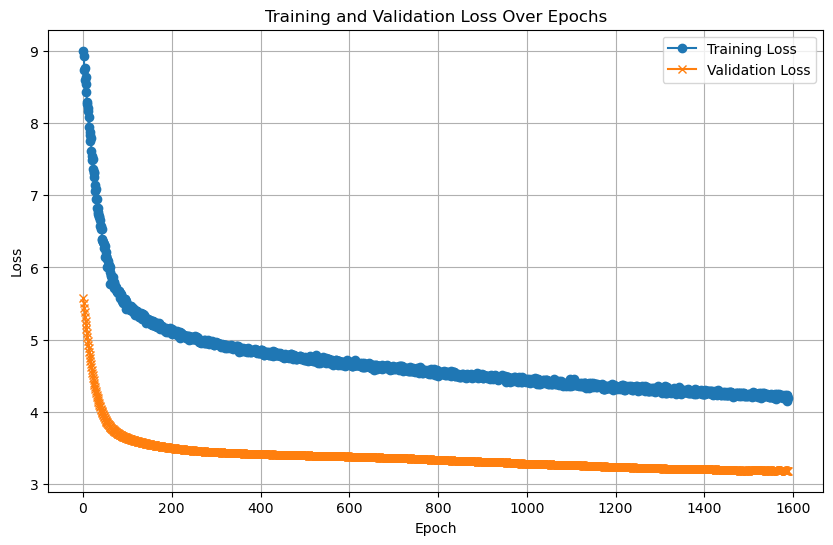

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/39], Loss: 4.7918
Test Batch [20/39], Loss: 5.3962
Test Batch [30/39], Loss: 5.8031

Test Loss: 5.1217


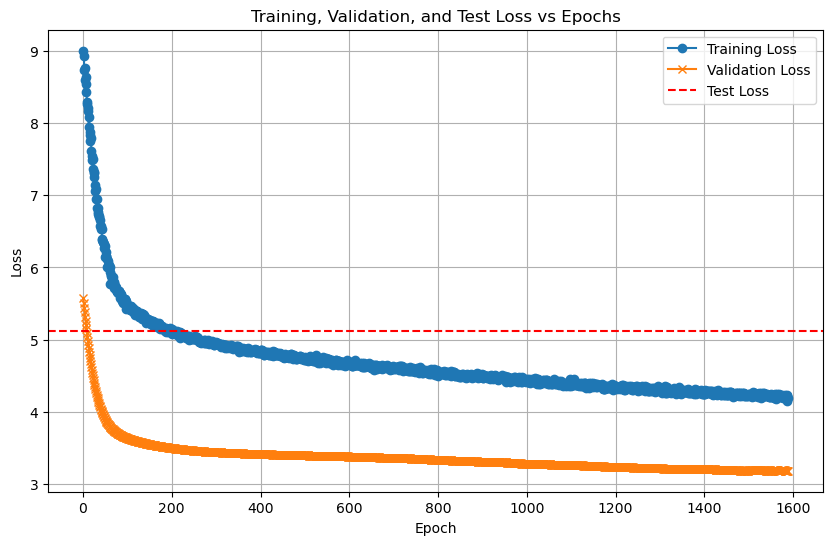

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/39 for test dataset.


  Processed batch 20/39 for test dataset.
  Processed batch 30/39 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.33      0.20      0.25         5
           2       0.00      0.00      0.00         5
           3       0.44      0.80      0.57         5
           4       0.75      0.60      0.67         5
           5       0.71      1.00      0.83         5
           6       1.00      0.80      0.89         5
           7       0.83      1.00      0.91         5
           9       0.75      0.60      0.67         5
          10       0.40      0.40      0.40         5
          11       0.43      0.60      0.50         5
          12       1.00      1.00      1.00         5
          13       0.80      0.80      0.80         5
          14       0.7

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9784  |  Val Loss: 2.9090
Validation loss improved from inf to 2.9090.


[Epoch 2/1000] Train Loss: 2.9336  |  Val Loss: 2.8686
Validation loss improved from 2.9090 to 2.8686.


[Epoch 3/1000] Train Loss: 2.8925  |  Val Loss: 2.8316
Validation loss improved from 2.8686 to 2.8316.
[Epoch 4/1000] Train Loss: 2.8527  |  Val Loss: 2.7985
Validation loss improved from 2.8316 to 2.7985.
[Epoch 5/1000] Train Loss: 2.8190  |  Val Loss: 2.7671
Validation loss improved from 2.7985 to 2.7671.
[Epoch 6/1000] Train Loss: 2.7856  |  Val Loss: 2.7388
Validation loss improved from 2.7671 to 2.7388.
[Epoch 7/1000] Train Loss: 2.7558  |  Val Loss: 2.7122
Validation loss improved from 2.7388 to 2.7122.
[Epoch 8/1000] Train Loss: 2.7297  |  Val Loss: 2.6865
Validation loss improved from 2.7122 to 2.6865.
[Epoch 9/1000] Train Loss: 2.7030  |  Val Loss: 2.6625
Validation loss improved from 2.6865 to 2.6625.
[Epoch 10/1000] Train Loss: 2.6799  |  Val Loss: 2.6404
Validation loss improved from 2.6625 to 2.6404.
[Epoch 11/1000] Train Loss: 2.6573  |  Val Loss: 2.6208
Validation loss improved from 2.6404 to 2.6208.
[Epoch 12/1000] Train Loss: 2.6378  |  Val Loss: 2.6039
Validation loss

[Epoch 16/1000] Train Loss: 2.5682  |  Val Loss: 2.5411
Validation loss improved from 2.5566 to 2.5411.
[Epoch 17/1000] Train Loss: 2.5519  |  Val Loss: 2.5263
Validation loss improved from 2.5411 to 2.5263.
[Epoch 18/1000] Train Loss: 2.5365  |  Val Loss: 2.5122
Validation loss improved from 2.5263 to 2.5122.
[Epoch 19/1000] Train Loss: 2.5216  |  Val Loss: 2.4977
Validation loss improved from 2.5122 to 2.4977.
[Epoch 20/1000] Train Loss: 2.5063  |  Val Loss: 2.4830
Validation loss improved from 2.4977 to 2.4830.
[Epoch 21/1000] Train Loss: 2.4904  |  Val Loss: 2.4687
Validation loss improved from 2.4830 to 2.4687.


[Epoch 22/1000] Train Loss: 2.4743  |  Val Loss: 2.4535
Validation loss improved from 2.4687 to 2.4535.
[Epoch 23/1000] Train Loss: 2.4580  |  Val Loss: 2.4387
Validation loss improved from 2.4535 to 2.4387.
[Epoch 24/1000] Train Loss: 2.4418  |  Val Loss: 2.4238
Validation loss improved from 2.4387 to 2.4238.
[Epoch 25/1000] Train Loss: 2.4262  |  Val Loss: 2.4086
Validation loss improved from 2.4238 to 2.4086.
[Epoch 26/1000] Train Loss: 2.4099  |  Val Loss: 2.3933
Validation loss improved from 2.4086 to 2.3933.
[Epoch 27/1000] Train Loss: 2.3937  |  Val Loss: 2.3779
Validation loss improved from 2.3933 to 2.3779.
[Epoch 28/1000] Train Loss: 2.3767  |  Val Loss: 2.3634
Validation loss improved from 2.3779 to 2.3634.
[Epoch 29/1000] Train Loss: 2.3612  |  Val Loss: 2.3484
Validation loss improved from 2.3634 to 2.3484.
[Epoch 30/1000] Train Loss: 2.3439  |  Val Loss: 2.3329
Validation loss improved from 2.3484 to 2.3329.
[Epoch 31/1000] Train Loss: 2.3272  |  Val Loss: 2.3169
Validati

[Epoch 35/1000] Train Loss: 2.2603  |  Val Loss: 2.2543
Validation loss improved from 2.2697 to 2.2543.
[Epoch 36/1000] Train Loss: 2.2427  |  Val Loss: 2.2397
Validation loss improved from 2.2543 to 2.2397.
[Epoch 37/1000] Train Loss: 2.2261  |  Val Loss: 2.2252
Validation loss improved from 2.2397 to 2.2252.
[Epoch 38/1000] Train Loss: 2.2106  |  Val Loss: 2.2108
Validation loss improved from 2.2252 to 2.2108.
[Epoch 39/1000] Train Loss: 2.1936  |  Val Loss: 2.1964
Validation loss improved from 2.2108 to 2.1964.
[Epoch 40/1000] Train Loss: 2.1776  |  Val Loss: 2.1825
Validation loss improved from 2.1964 to 2.1825.
[Epoch 41/1000] Train Loss: 2.1621  |  Val Loss: 2.1684
Validation loss improved from 2.1825 to 2.1684.


[Epoch 42/1000] Train Loss: 2.1457  |  Val Loss: 2.1542
Validation loss improved from 2.1684 to 2.1542.
[Epoch 43/1000] Train Loss: 2.1298  |  Val Loss: 2.1401
Validation loss improved from 2.1542 to 2.1401.
[Epoch 44/1000] Train Loss: 2.1137  |  Val Loss: 2.1261
Validation loss improved from 2.1401 to 2.1261.
[Epoch 45/1000] Train Loss: 2.0983  |  Val Loss: 2.1131
Validation loss improved from 2.1261 to 2.1131.
[Epoch 46/1000] Train Loss: 2.0819  |  Val Loss: 2.1001
Validation loss improved from 2.1131 to 2.1001.
[Epoch 47/1000] Train Loss: 2.0664  |  Val Loss: 2.0870
Validation loss improved from 2.1001 to 2.0870.
[Epoch 48/1000] Train Loss: 2.0506  |  Val Loss: 2.0739
Validation loss improved from 2.0870 to 2.0739.
[Epoch 49/1000] Train Loss: 2.0361  |  Val Loss: 2.0612
Validation loss improved from 2.0739 to 2.0612.
[Epoch 50/1000] Train Loss: 2.0210  |  Val Loss: 2.0491
Validation loss improved from 2.0612 to 2.0491.
[Epoch 51/1000] Train Loss: 2.0067  |  Val Loss: 2.0368
Validati

[Epoch 55/1000] Train Loss: 1.9497  |  Val Loss: 1.9893
Validation loss improved from 2.0012 to 1.9893.
[Epoch 56/1000] Train Loss: 1.9354  |  Val Loss: 1.9770
Validation loss improved from 1.9893 to 1.9770.
[Epoch 57/1000] Train Loss: 1.9219  |  Val Loss: 1.9645
Validation loss improved from 1.9770 to 1.9645.
[Epoch 58/1000] Train Loss: 1.9075  |  Val Loss: 1.9523
Validation loss improved from 1.9645 to 1.9523.
[Epoch 59/1000] Train Loss: 1.8943  |  Val Loss: 1.9415
Validation loss improved from 1.9523 to 1.9415.
[Epoch 60/1000] Train Loss: 1.8800  |  Val Loss: 1.9300
Validation loss improved from 1.9415 to 1.9300.
[Epoch 61/1000] Train Loss: 1.8672  |  Val Loss: 1.9187
Validation loss improved from 1.9300 to 1.9187.
[Epoch 62/1000] Train Loss: 1.8531  |  Val Loss: 1.9070
Validation loss improved from 1.9187 to 1.9070.


[Epoch 63/1000] Train Loss: 1.8402  |  Val Loss: 1.8956
Validation loss improved from 1.9070 to 1.8956.
[Epoch 64/1000] Train Loss: 1.8272  |  Val Loss: 1.8841
Validation loss improved from 1.8956 to 1.8841.
[Epoch 65/1000] Train Loss: 1.8140  |  Val Loss: 1.8727
Validation loss improved from 1.8841 to 1.8727.
[Epoch 66/1000] Train Loss: 1.8009  |  Val Loss: 1.8614
Validation loss improved from 1.8727 to 1.8614.
[Epoch 67/1000] Train Loss: 1.7884  |  Val Loss: 1.8503
Validation loss improved from 1.8614 to 1.8503.
[Epoch 68/1000] Train Loss: 1.7752  |  Val Loss: 1.8389
Validation loss improved from 1.8503 to 1.8389.
[Epoch 69/1000] Train Loss: 1.7632  |  Val Loss: 1.8282
Validation loss improved from 1.8389 to 1.8282.
[Epoch 70/1000] Train Loss: 1.7496  |  Val Loss: 1.8177
Validation loss improved from 1.8282 to 1.8177.
[Epoch 71/1000] Train Loss: 1.7372  |  Val Loss: 1.8070
Validation loss improved from 1.8177 to 1.8070.
[Epoch 72/1000] Train Loss: 1.7244  |  Val Loss: 1.7962
Validati

[Epoch 75/1000] Train Loss: 1.6852  |  Val Loss: 1.7644
Validation loss improved from 1.7752 to 1.7644.
[Epoch 76/1000] Train Loss: 1.6721  |  Val Loss: 1.7540
Validation loss improved from 1.7644 to 1.7540.
[Epoch 77/1000] Train Loss: 1.6595  |  Val Loss: 1.7435
Validation loss improved from 1.7540 to 1.7435.
[Epoch 78/1000] Train Loss: 1.6472  |  Val Loss: 1.7335
Validation loss improved from 1.7435 to 1.7335.
[Epoch 79/1000] Train Loss: 1.6340  |  Val Loss: 1.7226
Validation loss improved from 1.7335 to 1.7226.
[Epoch 80/1000] Train Loss: 1.6214  |  Val Loss: 1.7121
Validation loss improved from 1.7226 to 1.7121.


[Epoch 81/1000] Train Loss: 1.6089  |  Val Loss: 1.7017
Validation loss improved from 1.7121 to 1.7017.
[Epoch 82/1000] Train Loss: 1.5969  |  Val Loss: 1.6918
Validation loss improved from 1.7017 to 1.6918.
[Epoch 83/1000] Train Loss: 1.5847  |  Val Loss: 1.6817
Validation loss improved from 1.6918 to 1.6817.
[Epoch 84/1000] Train Loss: 1.5726  |  Val Loss: 1.6719
Validation loss improved from 1.6817 to 1.6719.
[Epoch 85/1000] Train Loss: 1.5606  |  Val Loss: 1.6616
Validation loss improved from 1.6719 to 1.6616.
[Epoch 86/1000] Train Loss: 1.5480  |  Val Loss: 1.6514
Validation loss improved from 1.6616 to 1.6514.
[Epoch 87/1000] Train Loss: 1.5359  |  Val Loss: 1.6415
Validation loss improved from 1.6514 to 1.6415.
[Epoch 88/1000] Train Loss: 1.5238  |  Val Loss: 1.6322
Validation loss improved from 1.6415 to 1.6322.
[Epoch 89/1000] Train Loss: 1.5122  |  Val Loss: 1.6230
Validation loss improved from 1.6322 to 1.6230.
[Epoch 90/1000] Train Loss: 1.5016  |  Val Loss: 1.6139
Validati

[Epoch 93/1000] Train Loss: 1.4660  |  Val Loss: 1.5853
Validation loss improved from 1.5943 to 1.5853.
[Epoch 94/1000] Train Loss: 1.4548  |  Val Loss: 1.5763
Validation loss improved from 1.5853 to 1.5763.
[Epoch 95/1000] Train Loss: 1.4436  |  Val Loss: 1.5670
Validation loss improved from 1.5763 to 1.5670.
[Epoch 96/1000] Train Loss: 1.4330  |  Val Loss: 1.5585
Validation loss improved from 1.5670 to 1.5585.
[Epoch 97/1000] Train Loss: 1.4210  |  Val Loss: 1.5495
Validation loss improved from 1.5585 to 1.5495.


[Epoch 98/1000] Train Loss: 1.4104  |  Val Loss: 1.5403
Validation loss improved from 1.5495 to 1.5403.
[Epoch 99/1000] Train Loss: 1.3996  |  Val Loss: 1.5313
Validation loss improved from 1.5403 to 1.5313.
[Epoch 100/1000] Train Loss: 1.3897  |  Val Loss: 1.5223
Validation loss improved from 1.5313 to 1.5223.
[Epoch 101/1000] Train Loss: 1.3786  |  Val Loss: 1.5136
Validation loss improved from 1.5223 to 1.5136.
[Epoch 102/1000] Train Loss: 1.3686  |  Val Loss: 1.5050
Validation loss improved from 1.5136 to 1.5050.
[Epoch 103/1000] Train Loss: 1.3584  |  Val Loss: 1.4974
Validation loss improved from 1.5050 to 1.4974.
[Epoch 104/1000] Train Loss: 1.3481  |  Val Loss: 1.4899
Validation loss improved from 1.4974 to 1.4899.
[Epoch 105/1000] Train Loss: 1.3386  |  Val Loss: 1.4818
Validation loss improved from 1.4899 to 1.4818.
[Epoch 106/1000] Train Loss: 1.3290  |  Val Loss: 1.4740
Validation loss improved from 1.4818 to 1.4740.
[Epoch 107/1000] Train Loss: 1.3196  |  Val Loss: 1.4660


[Epoch 111/1000] Train Loss: 1.2827  |  Val Loss: 1.4372
Validation loss improved from 1.4439 to 1.4372.
[Epoch 112/1000] Train Loss: 1.2738  |  Val Loss: 1.4307
Validation loss improved from 1.4372 to 1.4307.
[Epoch 113/1000] Train Loss: 1.2659  |  Val Loss: 1.4233
Validation loss improved from 1.4307 to 1.4233.
[Epoch 114/1000] Train Loss: 1.2565  |  Val Loss: 1.4168
Validation loss improved from 1.4233 to 1.4168.
[Epoch 115/1000] Train Loss: 1.2483  |  Val Loss: 1.4107
Validation loss improved from 1.4168 to 1.4107.


[Epoch 116/1000] Train Loss: 1.2398  |  Val Loss: 1.4037
Validation loss improved from 1.4107 to 1.4037.
[Epoch 117/1000] Train Loss: 1.2318  |  Val Loss: 1.3976
Validation loss improved from 1.4037 to 1.3976.
[Epoch 118/1000] Train Loss: 1.2244  |  Val Loss: 1.3914
Validation loss improved from 1.3976 to 1.3914.
[Epoch 119/1000] Train Loss: 1.2162  |  Val Loss: 1.3863
Validation loss improved from 1.3914 to 1.3863.
[Epoch 120/1000] Train Loss: 1.2088  |  Val Loss: 1.3810
Validation loss improved from 1.3863 to 1.3810.
[Epoch 121/1000] Train Loss: 1.2016  |  Val Loss: 1.3748
Validation loss improved from 1.3810 to 1.3748.
[Epoch 122/1000] Train Loss: 1.1941  |  Val Loss: 1.3684
Validation loss improved from 1.3748 to 1.3684.
[Epoch 123/1000] Train Loss: 1.1856  |  Val Loss: 1.3628
Validation loss improved from 1.3684 to 1.3628.
[Epoch 124/1000] Train Loss: 1.1784  |  Val Loss: 1.3569
Validation loss improved from 1.3628 to 1.3569.
[Epoch 125/1000] Train Loss: 1.1717  |  Val Loss: 1.352

[Epoch 130/1000] Train Loss: 1.1372  |  Val Loss: 1.3275
Validation loss improved from 1.3332 to 1.3275.
[Epoch 131/1000] Train Loss: 1.1315  |  Val Loss: 1.3241
Validation loss improved from 1.3275 to 1.3241.
[Epoch 132/1000] Train Loss: 1.1230  |  Val Loss: 1.3190
Validation loss improved from 1.3241 to 1.3190.
[Epoch 133/1000] Train Loss: 1.1170  |  Val Loss: 1.3143
Validation loss improved from 1.3190 to 1.3143.


[Epoch 134/1000] Train Loss: 1.1094  |  Val Loss: 1.3093
Validation loss improved from 1.3143 to 1.3093.
[Epoch 135/1000] Train Loss: 1.1030  |  Val Loss: 1.3045
Validation loss improved from 1.3093 to 1.3045.
[Epoch 136/1000] Train Loss: 1.0958  |  Val Loss: 1.2992
Validation loss improved from 1.3045 to 1.2992.
[Epoch 137/1000] Train Loss: 1.0895  |  Val Loss: 1.2954
Validation loss improved from 1.2992 to 1.2954.
[Epoch 138/1000] Train Loss: 1.0832  |  Val Loss: 1.2906
Validation loss improved from 1.2954 to 1.2906.
[Epoch 139/1000] Train Loss: 1.0774  |  Val Loss: 1.2869
Validation loss improved from 1.2906 to 1.2869.
[Epoch 140/1000] Train Loss: 1.0711  |  Val Loss: 1.2825
Validation loss improved from 1.2869 to 1.2825.
[Epoch 141/1000] Train Loss: 1.0652  |  Val Loss: 1.2780
Validation loss improved from 1.2825 to 1.2780.
[Epoch 142/1000] Train Loss: 1.0597  |  Val Loss: 1.2740
Validation loss improved from 1.2780 to 1.2740.
[Epoch 143/1000] Train Loss: 1.0567  |  Val Loss: 1.269

[Epoch 149/1000] Train Loss: 1.0226  |  Val Loss: 1.2490
Validation loss improved from 1.2524 to 1.2490.
[Epoch 150/1000] Train Loss: 1.0170  |  Val Loss: 1.2459
Validation loss improved from 1.2490 to 1.2459.
[Epoch 151/1000] Train Loss: 1.0126  |  Val Loss: 1.2431
Validation loss improved from 1.2459 to 1.2431.
[Epoch 152/1000] Train Loss: 1.0074  |  Val Loss: 1.2396
Validation loss improved from 1.2431 to 1.2396.
[Epoch 153/1000] Train Loss: 1.0023  |  Val Loss: 1.2365
Validation loss improved from 1.2396 to 1.2365.
[Epoch 154/1000] Train Loss: 0.9975  |  Val Loss: 1.2338
Validation loss improved from 1.2365 to 1.2338.


[Epoch 155/1000] Train Loss: 0.9929  |  Val Loss: 1.2296
Validation loss improved from 1.2338 to 1.2296.
[Epoch 156/1000] Train Loss: 0.9879  |  Val Loss: 1.2271
Validation loss improved from 1.2296 to 1.2271.
[Epoch 157/1000] Train Loss: 0.9833  |  Val Loss: 1.2241
Validation loss improved from 1.2271 to 1.2241.
[Epoch 158/1000] Train Loss: 0.9789  |  Val Loss: 1.2209
Validation loss improved from 1.2241 to 1.2209.
[Epoch 159/1000] Train Loss: 0.9748  |  Val Loss: 1.2183
Validation loss improved from 1.2209 to 1.2183.
[Epoch 160/1000] Train Loss: 0.9721  |  Val Loss: 1.2160
Validation loss improved from 1.2183 to 1.2160.
[Epoch 161/1000] Train Loss: 0.9658  |  Val Loss: 1.2135
Validation loss improved from 1.2160 to 1.2135.
[Epoch 162/1000] Train Loss: 0.9640  |  Val Loss: 1.2131
Validation loss improved from 1.2135 to 1.2131.
[Epoch 163/1000] Train Loss: 0.9582  |  Val Loss: 1.2084
Validation loss improved from 1.2131 to 1.2084.
[Epoch 164/1000] Train Loss: 0.9528  |  Val Loss: 1.205

[Epoch 169/1000] Train Loss: 0.9332  |  Val Loss: 1.1927
Validation loss improved from 1.1958 to 1.1927.
[Epoch 170/1000] Train Loss: 0.9302  |  Val Loss: 1.1909
Validation loss improved from 1.1927 to 1.1909.
[Epoch 171/1000] Train Loss: 0.9259  |  Val Loss: 1.1888
Validation loss improved from 1.1909 to 1.1888.


[Epoch 172/1000] Train Loss: 0.9221  |  Val Loss: 1.1871
Validation loss improved from 1.1888 to 1.1871.
[Epoch 173/1000] Train Loss: 0.9186  |  Val Loss: 1.1833
Validation loss improved from 1.1871 to 1.1833.
[Epoch 174/1000] Train Loss: 0.9151  |  Val Loss: 1.1823
Validation loss improved from 1.1833 to 1.1823.
[Epoch 175/1000] Train Loss: 0.9113  |  Val Loss: 1.1802
Validation loss improved from 1.1823 to 1.1802.
[Epoch 176/1000] Train Loss: 0.9076  |  Val Loss: 1.1781
Validation loss improved from 1.1802 to 1.1781.
[Epoch 177/1000] Train Loss: 0.9039  |  Val Loss: 1.1746
Validation loss improved from 1.1781 to 1.1746.
[Epoch 178/1000] Train Loss: 0.9012  |  Val Loss: 1.1729
Validation loss improved from 1.1746 to 1.1729.
[Epoch 179/1000] Train Loss: 0.8978  |  Val Loss: 1.1713
Validation loss improved from 1.1729 to 1.1713.
[Epoch 180/1000] Train Loss: 0.8944  |  Val Loss: 1.1683
Validation loss improved from 1.1713 to 1.1683.
[Epoch 181/1000] Train Loss: 0.8910  |  Val Loss: 1.166

[Epoch 187/1000] Train Loss: 0.8716  |  Val Loss: 1.1568
Validation loss improved from 1.1589 to 1.1568.
[Epoch 188/1000] Train Loss: 0.8685  |  Val Loss: 1.1545
Validation loss improved from 1.1568 to 1.1545.
[Epoch 189/1000] Train Loss: 0.8651  |  Val Loss: 1.1525
Validation loss improved from 1.1545 to 1.1525.
[Epoch 190/1000] Train Loss: 0.8646  |  Val Loss: 1.1496
Validation loss improved from 1.1525 to 1.1496.
[Epoch 191/1000] Train Loss: 0.8603  |  Val Loss: 1.1469
Validation loss improved from 1.1496 to 1.1469.
[Epoch 192/1000] Train Loss: 0.8564  |  Val Loss: 1.1457
Validation loss improved from 1.1469 to 1.1457.
[Epoch 193/1000] Train Loss: 0.8539  |  Val Loss: 1.1454
Validation loss improved from 1.1457 to 1.1454.
[Epoch 194/1000] Train Loss: 0.8515  |  Val Loss: 1.1438
Validation loss improved from 1.1454 to 1.1438.
[Epoch 195/1000] Train Loss: 0.8479  |  Val Loss: 1.1430
Validation loss improved from 1.1438 to 1.1430.
[Epoch 196/1000] Train Loss: 0.8456  |  Val Loss: 1.139

[Epoch 207/1000] Train Loss: 0.8169  |  Val Loss: 1.1237
Validation loss improved from 1.1248 to 1.1237.
[Epoch 208/1000] Train Loss: 0.8138  |  Val Loss: 1.1224
Validation loss improved from 1.1237 to 1.1224.
[Epoch 209/1000] Train Loss: 0.8125  |  Val Loss: 1.1201
Validation loss improved from 1.1224 to 1.1201.
[Epoch 210/1000] Train Loss: 0.8097  |  Val Loss: 1.1198
Validation loss improved from 1.1201 to 1.1198.
[Epoch 211/1000] Train Loss: 0.8072  |  Val Loss: 1.1187
Validation loss improved from 1.1198 to 1.1187.
[Epoch 212/1000] Train Loss: 0.8056  |  Val Loss: 1.1170
Validation loss improved from 1.1187 to 1.1170.
[Epoch 213/1000] Train Loss: 0.8025  |  Val Loss: 1.1156
Validation loss improved from 1.1170 to 1.1156.
[Epoch 214/1000] Train Loss: 0.8012  |  Val Loss: 1.1134
Validation loss improved from 1.1156 to 1.1134.
[Epoch 215/1000] Train Loss: 0.7984  |  Val Loss: 1.1135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 216/1000] Train Loss: 0.7969  |  Val Loss:

[Epoch 226/1000] Train Loss: 0.7762  |  Val Loss: 1.1004
Validation loss improved from 1.1020 to 1.1004.
[Epoch 227/1000] Train Loss: 0.7749  |  Val Loss: 1.0993
Validation loss improved from 1.1004 to 1.0993.
[Epoch 228/1000] Train Loss: 0.7745  |  Val Loss: 1.1000
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 0.7704  |  Val Loss: 1.0974
Validation loss improved from 1.0993 to 1.0974.
[Epoch 230/1000] Train Loss: 0.7687  |  Val Loss: 1.0965
Validation loss improved from 1.0974 to 1.0965.
[Epoch 231/1000] Train Loss: 0.7670  |  Val Loss: 1.0949
Validation loss improved from 1.0965 to 1.0949.
[Epoch 232/1000] Train Loss: 0.7649  |  Val Loss: 1.0942
Validation loss improved from 1.0949 to 1.0942.
[Epoch 233/1000] Train Loss: 0.7651  |  Val Loss: 1.0951
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 0.7617  |  Val Loss: 1.0915
Validation loss improved from 1.0942 to 1.0915.
[Epoch 235/1000] Train Loss: 0.7599  |  Val

[Epoch 245/1000] Train Loss: 0.7431  |  Val Loss: 1.0838
Validation loss improved from 1.0841 to 1.0838.
[Epoch 246/1000] Train Loss: 0.7422  |  Val Loss: 1.0820
Validation loss improved from 1.0838 to 1.0820.
[Epoch 247/1000] Train Loss: 0.7400  |  Val Loss: 1.0803
Validation loss improved from 1.0820 to 1.0803.
[Epoch 248/1000] Train Loss: 0.7396  |  Val Loss: 1.0793
Validation loss improved from 1.0803 to 1.0793.
[Epoch 249/1000] Train Loss: 0.7379  |  Val Loss: 1.0792
Validation loss improved from 1.0793 to 1.0792.
[Epoch 250/1000] Train Loss: 0.7369  |  Val Loss: 1.0779
Validation loss improved from 1.0792 to 1.0779.
[Epoch 251/1000] Train Loss: 0.7362  |  Val Loss: 1.0790
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 0.7340  |  Val Loss: 1.0769
Validation loss improved from 1.0779 to 1.0769.
[Epoch 253/1000] Train Loss: 0.7316  |  Val Loss: 1.0751
Validation loss improved from 1.0769 to 1.0751.
[Epoch 254/1000] Train Loss: 0.7298  |  Val Loss:

[Epoch 262/1000] Train Loss: 0.7192  |  Val Loss: 1.0690
Validation loss improved from 1.0692 to 1.0690.
[Epoch 263/1000] Train Loss: 0.7197  |  Val Loss: 1.0686
Validation loss improved from 1.0690 to 1.0686.
[Epoch 264/1000] Train Loss: 0.7175  |  Val Loss: 1.0686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 0.7151  |  Val Loss: 1.0671
Validation loss improved from 1.0686 to 1.0671.
[Epoch 266/1000] Train Loss: 0.7138  |  Val Loss: 1.0647
Validation loss improved from 1.0671 to 1.0647.
[Epoch 267/1000] Train Loss: 0.7125  |  Val Loss: 1.0634
Validation loss improved from 1.0647 to 1.0634.
[Epoch 268/1000] Train Loss: 0.7112  |  Val Loss: 1.0643
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 269/1000] Train Loss: 0.7105  |  Val Loss: 1.0651
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 270/1000] Train Loss: 0.7095  |  Val Loss: 1.0634
Validation loss improved from 1.0634 to 1.0634.
[Epoch 271/1000] Train Loss: 0.7082  

[Epoch 278/1000] Train Loss: 0.7001  |  Val Loss: 1.0587
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 279/1000] Train Loss: 0.6993  |  Val Loss: 1.0590
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 0.6973  |  Val Loss: 1.0573
Validation loss improved from 1.0587 to 1.0573.
[Epoch 281/1000] Train Loss: 0.6970  |  Val Loss: 1.0566
Validation loss improved from 1.0573 to 1.0566.
[Epoch 282/1000] Train Loss: 0.6955  |  Val Loss: 1.0552
Validation loss improved from 1.0566 to 1.0552.
[Epoch 283/1000] Train Loss: 0.6939  |  Val Loss: 1.0548
Validation loss improved from 1.0552 to 1.0548.
[Epoch 284/1000] Train Loss: 0.6931  |  Val Loss: 1.0554
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 285/1000] Train Loss: 0.6930  |  Val Loss: 1.0564
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 286/1000] Train Loss: 0.6914  |  Val Loss: 1.0555
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 287/1000] Train Lo

[Epoch 299/1000] Train Loss: 0.6793  |  Val Loss: 1.0468
Validation loss improved from 1.0480 to 1.0468.
[Epoch 300/1000] Train Loss: 0.6779  |  Val Loss: 1.0454
Validation loss improved from 1.0468 to 1.0454.
[Epoch 301/1000] Train Loss: 0.6767  |  Val Loss: 1.0464
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 0.6760  |  Val Loss: 1.0459
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.6756  |  Val Loss: 1.0475
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 0.6751  |  Val Loss: 1.0447
Validation loss improved from 1.0454 to 1.0447.
[Epoch 305/1000] Train Loss: 0.6738  |  Val Loss: 1.0434
Validation loss improved from 1.0447 to 1.0434.
[Epoch 306/1000] Train Loss: 0.6722  |  Val Loss: 1.0440
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 307/1000] Train Loss: 0.6710  |  Val Loss: 1.0448
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 308/1000] Train Lo

[Epoch 317/1000] Train Loss: 0.6634  |  Val Loss: 1.0421
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 318/1000] Train Loss: 0.6629  |  Val Loss: 1.0418
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 319/1000] Train Loss: 0.6618  |  Val Loss: 1.0404
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 320/1000] Train Loss: 0.6609  |  Val Loss: 1.0408
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 321/1000] Train Loss: 0.6604  |  Val Loss: 1.0398
Validation loss improved from 1.0401 to 1.0398.
[Epoch 322/1000] Train Loss: 0.6602  |  Val Loss: 1.0384
Validation loss improved from 1.0398 to 1.0384.
[Epoch 323/1000] Train Loss: 0.6583  |  Val Loss: 1.0396
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 324/1000] Train Loss: 0.6576  |  Val Loss: 1.0406
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 325/1000] Train Loss: 0.6578  |  Val Loss: 1.0409
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 326/10

[Epoch 337/1000] Train Loss: 0.6484  |  Val Loss: 1.0360
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 338/1000] Train Loss: 0.6475  |  Val Loss: 1.0352
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 339/1000] Train Loss: 0.6470  |  Val Loss: 1.0363
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 340/1000] Train Loss: 0.6458  |  Val Loss: 1.0336
Validation loss improved from 1.0345 to 1.0336.
[Epoch 341/1000] Train Loss: 0.6470  |  Val Loss: 1.0336
Validation loss improved from 1.0336 to 1.0336.
[Epoch 342/1000] Train Loss: 0.6453  |  Val Loss: 1.0329
Validation loss improved from 1.0336 to 1.0329.
[Epoch 343/1000] Train Loss: 0.6447  |  Val Loss: 1.0356
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 344/1000] Train Loss: 0.6440  |  Val Loss: 1.0333
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 345/1000] Train Loss: 0.6442  |  Val Loss: 1.0328
Validation loss improved from 1.0329 to 1.0328.
[Epoch 346/1000] Train Lo

[Epoch 353/1000] Train Loss: 0.6388  |  Val Loss: 1.0288
Validation loss improved from 1.0318 to 1.0288.
[Epoch 354/1000] Train Loss: 0.6371  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 355/1000] Train Loss: 0.6361  |  Val Loss: 1.0307
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 356/1000] Train Loss: 0.6361  |  Val Loss: 1.0330
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 357/1000] Train Loss: 0.6357  |  Val Loss: 1.0314
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 358/1000] Train Loss: 0.6349  |  Val Loss: 1.0320
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 359/1000] Train Loss: 0.6335  |  Val Loss: 1.0313
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 360/1000] Train Loss: 0.6332  |  Val Loss: 1.0299
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 361/1000] Train Loss: 0.6322  |  Val Loss: 1.0305
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 371/1000] Train Loss: 0.6264  |  Val Loss: 1.0301
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 372/1000] Train Loss: 0.6260  |  Val Loss: 1.0286
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 373/1000] Train Loss: 0.6255  |  Val Loss: 1.0281
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 374/1000] Train Loss: 0.6259  |  Val Loss: 1.0305
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 375/1000] Train Loss: 0.6242  |  Val Loss: 1.0295
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 376/1000] Train Loss: 0.6256  |  Val Loss: 1.0304
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 377/1000] Train Loss: 0.6238  |  Val Loss: 1.0284
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 378/1000] Train Loss: 0.6221  |  Val Loss: 1.0273
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 379/1000] Train Loss: 0.6226  |  Val Loss: 1.0295
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 389/1000] Train Loss: 0.6168  |  Val Loss: 1.0293
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 390/1000] Train Loss: 0.6161  |  Val Loss: 1.0255
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 391/1000] Train Loss: 0.6157  |  Val Loss: 1.0252
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 392/1000] Train Loss: 0.6152  |  Val Loss: 1.0271
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 393/1000] Train Loss: 0.6144  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 394/1000] Train Loss: 0.6140  |  Val Loss: 1.0270
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 395/1000] Train Loss: 0.6137  |  Val Loss: 1.0253
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 396/1000] Train Loss: 0.6127  |  Val Loss: 1.0241
Validation loss improved from 1.0250 to 1.0241.
[Epoch 397/1000] Train Loss: 0.6126  |  Val Loss: 1.0238
Validation loss improved from 1.0241 to 1.0238.
[Epoch 39

[Epoch 409/1000] Train Loss: 0.6069  |  Val Loss: 1.0258
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 410/1000] Train Loss: 0.6066  |  Val Loss: 1.0266
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 411/1000] Train Loss: 0.6057  |  Val Loss: 1.0271
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 412/1000] Train Loss: 0.6049  |  Val Loss: 1.0258
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 413/1000] Train Loss: 0.6047  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 414/1000] Train Loss: 0.6042  |  Val Loss: 1.0242
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 415/1000] Train Loss: 0.6033  |  Val Loss: 1.0235
Validation loss improved from 1.0238 to 1.0235.
[Epoch 416/1000] Train Loss: 0.6036  |  Val Loss: 1.0255
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 417/1000] Train Loss: 0.6027  |  Val Loss: 1.0253
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 429/1000] Train Loss: 0.5978  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 430/1000] Train Loss: 0.5976  |  Val Loss: 1.0241
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 431/1000] Train Loss: 0.5964  |  Val Loss: 1.0252
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 432/1000] Train Loss: 0.5956  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 433/1000] Train Loss: 0.5974  |  Val Loss: 1.0238
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 434/1000] Train Loss: 0.5959  |  Val Loss: 1.0237
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 435/1000] Train Loss: 0.5961  |  Val Loss: 1.0250
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 436/1000] Train Loss: 0.5949  |  Val Loss: 1.0241
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 437/1000] Train Loss: 0.5944  |  Val Loss: 1.0243
!! Validation loss did NOT improve !! Patience:

[Epoch 445/1000] Train Loss: 0.5912  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 446/1000] Train Loss: 0.5901  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 447/1000] Train Loss: 0.5906  |  Val Loss: 1.0242
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 448/1000] Train Loss: 0.5891  |  Val Loss: 1.0237
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 449/1000] Train Loss: 0.5893  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 450/1000] Train Loss: 0.5893  |  Val Loss: 1.0245
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 451/1000] Train Loss: 0.5906  |  Val Loss: 1.0257
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 452/1000] Train Loss: 0.5894  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 453/1000] Train Loss: 0.5881  |  Val Loss: 1.0229
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 464/1000] Train Loss: 0.5840  |  Val Loss: 1.0277
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 465/1000] Train Loss: 0.5836  |  Val Loss: 1.0272
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 466/1000] Train Loss: 0.5825  |  Val Loss: 1.0239
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 467/1000] Train Loss: 0.5828  |  Val Loss: 1.0230
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 468/1000] Train Loss: 0.5823  |  Val Loss: 1.0239
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 469/1000] Train Loss: 0.5824  |  Val Loss: 1.0246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 470/1000] Train Loss: 0.5811  |  Val Loss: 1.0257
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 471/1000] Train Loss: 0.5810  |  Val Loss: 1.0267
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 472/1000] Train Loss: 0.5815  |  Val Loss: 1.0262
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 485/1000] Train Loss: 0.5757  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 486/1000] Train Loss: 0.5759  |  Val Loss: 1.0240
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 487/1000] Train Loss: 0.5757  |  Val Loss: 1.0228
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 488/1000] Train Loss: 0.5743  |  Val Loss: 1.0241
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 489/1000] Train Loss: 0.5743  |  Val Loss: 1.0262
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 490/1000] Train Loss: 0.5741  |  Val Loss: 1.0261
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 491/1000] Train Loss: 0.5741  |  Val Loss: 1.0256
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 492/1000] Train Loss: 0.5728  |  Val Loss: 1.0247
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 493/1000] Train Loss: 0.5727  |  Val Loss: 1.0253
!! Validation loss did NOT improve !! Patience:

[Epoch 505/1000] Train Loss: 0.5688  |  Val Loss: 1.0261
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 506/1000] Train Loss: 0.5681  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 507/1000] Train Loss: 0.5684  |  Val Loss: 1.0269
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 508/1000] Train Loss: 0.5690  |  Val Loss: 1.0263
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 509/1000] Train Loss: 0.5686  |  Val Loss: 1.0254
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 510/1000] Train Loss: 0.5668  |  Val Loss: 1.0253
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 511/1000] Train Loss: 0.5667  |  Val Loss: 1.0263
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 512/1000] Train Loss: 0.5659  |  Val Loss: 1.0268
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 513/1000] Train Loss: 0.5672  |  Val Loss: 1.0264
!! Validation loss did NOT improve !! Patience:

[Epoch 523/1000] Train Loss: 0.5625  |  Val Loss: 1.0270
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 524/1000] Train Loss: 0.5619  |  Val Loss: 1.0281
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 525/1000] Train Loss: 0.5621  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 526/1000] Train Loss: 0.5623  |  Val Loss: 1.0290
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 527/1000] Train Loss: 0.5614  |  Val Loss: 1.0270
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 528/1000] Train Loss: 0.5601  |  Val Loss: 1.0265
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 529/1000] Train Loss: 0.5619  |  Val Loss: 1.0290
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 530/1000] Train Loss: 0.5608  |  Val Loss: 1.0278
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 531/1000] Train Loss: 0.5598  |  Val Loss: 1.0273
!! Validation loss did NOT improve !! Patience:

[Epoch 539/1000] Train Loss: 0.5580  |  Val Loss: 1.0274
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 540/1000] Train Loss: 0.5576  |  Val Loss: 1.0289
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 541/1000] Train Loss: 0.5586  |  Val Loss: 1.0274
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 542/1000] Train Loss: 0.5565  |  Val Loss: 1.0280
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 543/1000] Train Loss: 0.5565  |  Val Loss: 1.0298
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 544/1000] Train Loss: 0.5567  |  Val Loss: 1.0317
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 545/1000] Train Loss: 0.5564  |  Val Loss: 1.0298
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 546/1000] Train Loss: 0.5567  |  Val Loss: 1.0284
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 547/1000] Train Loss: 0.5558  |  Val Loss: 1.0287
!! Validation loss did NOT improve !! Patience:

[Epoch 558/1000] Train Loss: 0.5517  |  Val Loss: 1.0319
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 559/1000] Train Loss: 0.5521  |  Val Loss: 1.0317
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 560/1000] Train Loss: 0.5522  |  Val Loss: 1.0311
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 561/1000] Train Loss: 0.5513  |  Val Loss: 1.0329
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 562/1000] Train Loss: 0.5510  |  Val Loss: 1.0312
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 563/1000] Train Loss: 0.5508  |  Val Loss: 1.0309
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 564/1000] Train Loss: 0.5504  |  Val Loss: 1.0321
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 565/1000] Train Loss: 0.5509  |  Val Loss: 1.0303
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 566/1000] Train Loss: 0.5498  |  Val Loss: 1.0312
!! Validation loss did NOT improve !! Patience:

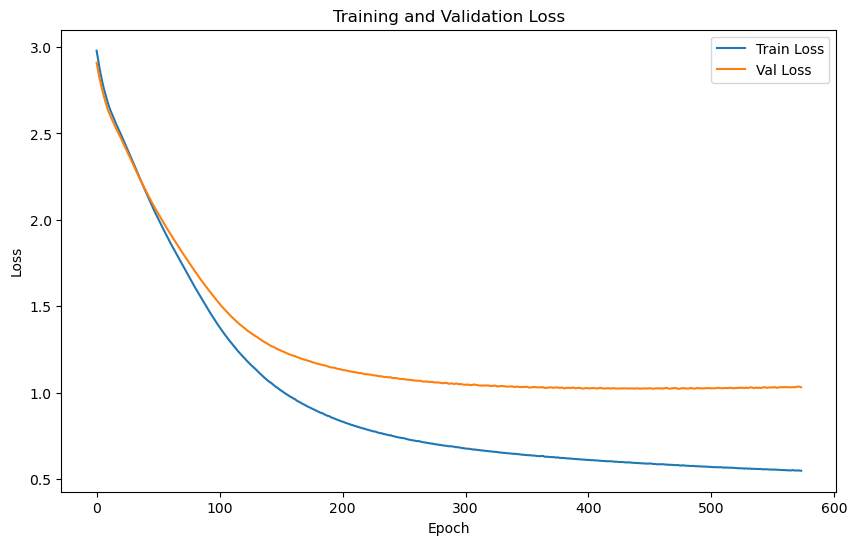

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.6494 | Test Accuracy: 56.42%


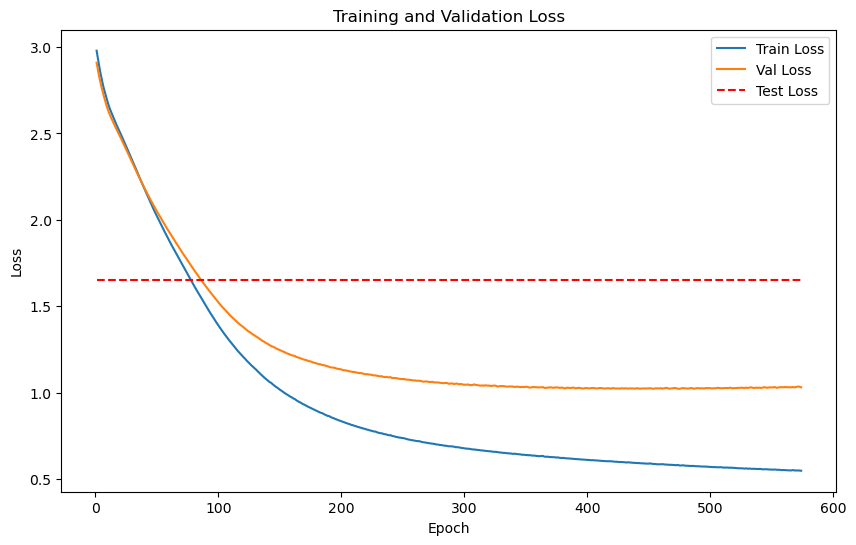

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 75 samples with 64 features each
LOG: Labels shape: (75,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 9854 samples with 64 features each
LOG: Labels shape: (9854,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (75, 64), 
Val labels shape: (75,)


Test embeddings shape: (9854, 64), 
Test labels shape: (9854,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5440
    Batch [2/2], Val Loss: 0.3058
Epoch [1/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.4249

Validation loss improved from inf to 0.4249. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5010
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5422
    Batch [2/2], Val Loss: 0.3086
Epoch [2/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.4254

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5002
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5405
    Batch [2/2], Val Loss: 0.3116
Epoch [3/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.4261

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5388
    Batch [2/2], Val Loss: 0.3145
Epoch [4/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.4267

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5372
    Batch [2/2], Val Loss: 0.3172
Epoch [5/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.4272

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5356
    Batch [2/2], Val Loss: 0.3192
Epoch [6/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.4274

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5338
    Batch [2/2], Val Loss: 0.3208
Epoch [7/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.4273

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.3219
Epoch [8/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4270

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4934
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5308
    Batch [2/2], Val Loss: 0.3222
Epoch [9/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.4265

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.3224
Epoch [10/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4261

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.3227
Epoch [11/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.4257

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4928
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.3230
Epoch [12/2000], Avg Train Loss: 0.4928, Avg Val Loss: 0.4254

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.3233
Epoch [13/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.4250

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5257
    Batch [2/2], Val Loss: 0.3235
Epoch [14/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4246

Validation loss improved from 0.4249 to 0.4246. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5246
    Batch [2/2], Val Loss: 0.3239
Epoch [15/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.4242

Validation loss improved from 0.4246 to 0.4242. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5235
    Batch [2/2], Val Loss: 0.3243
Epoch [16/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4239

Validation loss improved from 0.4242 to 0.4239. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5226
    Batch [2/2], Val Loss: 0.3246
Epoch [17/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.4236

Validation loss improved from 0.4239 to 0.4236. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4926
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.3251
Epoch [18/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4235

Validation loss improved from 0.4236 to 0.4235. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.3253
Epoch [19/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4233

Validation loss improved from 0.4235 to 0.4233. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.3256
Epoch [20/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4231

Validation loss improved from 0.4233 to 0.4231. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.3257
Epoch [21/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4231

Validation loss improved from 0.4231 to 0.4231. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5203
    Batch [2/2], Val Loss: 0.3258
Epoch [22/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4231

Validation loss improved from 0.4231 to 0.4231. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.3260
Epoch [23/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4230

Validation loss improved from 0.4231 to 0.4230. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.3261
Epoch [24/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4231

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.3262
Epoch [25/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4231

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.3262
Epoch [26/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4231

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.3262
Epoch [27/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4230

Validation loss improved from 0.4230 to 0.4230. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4883
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.3260
Epoch [28/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4229

Validation loss improved from 0.4230 to 0.4229. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4874
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.3259
Epoch [29/2000], Avg Train Loss: 0.4874, Avg Val Loss: 0.4229

Validation loss improved from 0.4229 to 0.4229. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4872
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.3257
Epoch [30/2000], Avg Train Loss: 0.4872, Avg Val Loss: 0.4228

Validation loss improved from 0.4229 to 0.4228. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.3255
Epoch [31/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4226

Validation loss improved from 0.4228 to 0.4226. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.3252
Epoch [32/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.4224

Validation loss improved from 0.4226 to 0.4224. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4866
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.3249
Epoch [33/2000], Avg Train Loss: 0.4866, Avg Val Loss: 0.4222

Validation loss improved from 0.4224 to 0.4222. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.3246
Epoch [34/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4220

Validation loss improved from 0.4222 to 0.4220. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.3243
Epoch [35/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4218

Validation loss improved from 0.4220 to 0.4218. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.3238
Epoch [36/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4215

Validation loss improved from 0.4218 to 0.4215. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4857
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.3234
Epoch [37/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4213

Validation loss improved from 0.4215 to 0.4213. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.3230
Epoch [38/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4210

Validation loss improved from 0.4213 to 0.4210. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.3225
Epoch [39/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4207

Validation loss improved from 0.4210 to 0.4207. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.3220
Epoch [40/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4203

Validation loss improved from 0.4207 to 0.4203. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.3215
Epoch [41/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4200

Validation loss improved from 0.4203 to 0.4200. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5183
    Batch [2/2], Val Loss: 0.3210
Epoch [42/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4196

Validation loss improved from 0.4200 to 0.4196. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.3205
Epoch [43/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4193

Validation loss improved from 0.4196 to 0.4193. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.3201
Epoch [44/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.4190

Validation loss improved from 0.4193 to 0.4190. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.3196
Epoch [45/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.4187

Validation loss improved from 0.4190 to 0.4187. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.3191
Epoch [46/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4183

Validation loss improved from 0.4187 to 0.4183. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5173
    Batch [2/2], Val Loss: 0.3186
Epoch [47/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.4179

Validation loss improved from 0.4183 to 0.4179. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.3181
Epoch [48/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4176

Validation loss improved from 0.4179 to 0.4176. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.3176
Epoch [49/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4172

Validation loss improved from 0.4176 to 0.4172. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.3170
Epoch [50/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4168

Validation loss improved from 0.4172 to 0.4168. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.3164
Epoch [51/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4164

Validation loss improved from 0.4168 to 0.4164. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5161
    Batch [2/2], Val Loss: 0.3158
Epoch [52/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.4160

Validation loss improved from 0.4164 to 0.4160. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.3153
Epoch [53/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4155

Validation loss improved from 0.4160 to 0.4155. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5156
    Batch [2/2], Val Loss: 0.3147
Epoch [54/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4151

Validation loss improved from 0.4155 to 0.4151. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4815
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.3142
Epoch [55/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4148

Validation loss improved from 0.4151 to 0.4148. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.3137
Epoch [56/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4144

Validation loss improved from 0.4148 to 0.4144. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.3132
Epoch [57/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.4140

Validation loss improved from 0.4144 to 0.4140. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.3126
Epoch [58/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4136

Validation loss improved from 0.4140 to 0.4136. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.3119
Epoch [59/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.4132

Validation loss improved from 0.4136 to 0.4132. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.3113
Epoch [60/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4128

Validation loss improved from 0.4132 to 0.4128. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.3108
Epoch [61/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4123

Validation loss improved from 0.4128 to 0.4123. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.3102
Epoch [62/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4120

Validation loss improved from 0.4123 to 0.4120. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.3098
Epoch [63/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4116

Validation loss improved from 0.4120 to 0.4116. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.3093
Epoch [64/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.4113

Validation loss improved from 0.4116 to 0.4113. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4751
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.3088
Epoch [65/2000], Avg Train Loss: 0.4751, Avg Val Loss: 0.4109

Validation loss improved from 0.4113 to 0.4109. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5128
    Batch [2/2], Val Loss: 0.3084
Epoch [66/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.4106

Validation loss improved from 0.4109 to 0.4106. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.3080
Epoch [67/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4103

Validation loss improved from 0.4106 to 0.4103. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5123
    Batch [2/2], Val Loss: 0.3076
Epoch [68/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4099

Validation loss improved from 0.4103 to 0.4099. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.3072
Epoch [69/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4096

Validation loss improved from 0.4099 to 0.4096. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.3068
Epoch [70/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4093

Validation loss improved from 0.4096 to 0.4093. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.3063
Epoch [71/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4089

Validation loss improved from 0.4093 to 0.4089. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.3058
Epoch [72/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4086

Validation loss improved from 0.4089 to 0.4086. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4721
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.3054
Epoch [73/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4083

Validation loss improved from 0.4086 to 0.4083. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4722
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.3051
Epoch [74/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4080

Validation loss improved from 0.4083 to 0.4080. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.3047
Epoch [75/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4077

Validation loss improved from 0.4080 to 0.4077. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.3043
Epoch [76/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4074

Validation loss improved from 0.4077 to 0.4074. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4733
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.3040
Epoch [77/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4071

Validation loss improved from 0.4074 to 0.4071. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.3036
Epoch [78/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4068

Validation loss improved from 0.4071 to 0.4068. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5097
    Batch [2/2], Val Loss: 0.3031
Epoch [79/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.4064

Validation loss improved from 0.4068 to 0.4064. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.3027
Epoch [80/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4061

Validation loss improved from 0.4064 to 0.4061. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.3022
Epoch [81/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4057

Validation loss improved from 0.4061 to 0.4057. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.3016
Epoch [82/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4053

Validation loss improved from 0.4057 to 0.4053. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.3011
Epoch [83/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4048

Validation loss improved from 0.4053 to 0.4048. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5083
    Batch [2/2], Val Loss: 0.3004
Epoch [84/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4044

Validation loss improved from 0.4048 to 0.4044. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5080
    Batch [2/2], Val Loss: 0.2998
Epoch [85/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4039

Validation loss improved from 0.4044 to 0.4039. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.2991
Epoch [86/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4034

Validation loss improved from 0.4039 to 0.4034. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.2985
Epoch [87/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4029

Validation loss improved from 0.4034 to 0.4029. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.2978
Epoch [88/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4024

Validation loss improved from 0.4029 to 0.4024. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.2972
Epoch [89/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4019

Validation loss improved from 0.4024 to 0.4019. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.2966
Epoch [90/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4015

Validation loss improved from 0.4019 to 0.4015. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.2961
Epoch [91/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4011

Validation loss improved from 0.4015 to 0.4011. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.2957
Epoch [92/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4007

Validation loss improved from 0.4011 to 0.4007. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.2953
Epoch [93/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4004

Validation loss improved from 0.4007 to 0.4004. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.2950
Epoch [94/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4000

Validation loss improved from 0.4004 to 0.4000. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.2945
Epoch [95/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3997

Validation loss improved from 0.4000 to 0.3997. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.2941
Epoch [96/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3993

Validation loss improved from 0.3997 to 0.3993. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.2937
Epoch [97/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3990

Validation loss improved from 0.3993 to 0.3990. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5039
    Batch [2/2], Val Loss: 0.2933
Epoch [98/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.3986

Validation loss improved from 0.3990 to 0.3986. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.2930
Epoch [99/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3983

Validation loss improved from 0.3986 to 0.3983. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.2927
Epoch [100/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3980

Validation loss improved from 0.3983 to 0.3980. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.2924
Epoch [101/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.3978

Validation loss improved from 0.3980 to 0.3978. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.2922
Epoch [102/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.3975

Validation loss improved from 0.3978 to 0.3975. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.2918
Epoch [103/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.3972

Validation loss improved from 0.3975 to 0.3972. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.2916
Epoch [104/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.3970

Validation loss improved from 0.3972 to 0.3970. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.2914
Epoch [105/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3968

Validation loss improved from 0.3970 to 0.3968. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5019
    Batch [2/2], Val Loss: 0.2911
Epoch [106/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.3965

Validation loss improved from 0.3968 to 0.3965. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.2907
Epoch [107/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.3962

Validation loss improved from 0.3965 to 0.3962. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.2903
Epoch [108/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.3959

Validation loss improved from 0.3962 to 0.3959. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.2900
Epoch [109/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.3956

Validation loss improved from 0.3959 to 0.3956. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.2896
Epoch [110/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3952

Validation loss improved from 0.3956 to 0.3952. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.2891
Epoch [111/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.3949

Validation loss improved from 0.3952 to 0.3949. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.2885
Epoch [112/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3945

Validation loss improved from 0.3949 to 0.3945. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.2881
Epoch [113/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3941

Validation loss improved from 0.3945 to 0.3941. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.2876
Epoch [114/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.3938

Validation loss improved from 0.3941 to 0.3938. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.2871
Epoch [115/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.3934

Validation loss improved from 0.3938 to 0.3934. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.2865
Epoch [116/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3930

Validation loss improved from 0.3934 to 0.3930. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.2860
Epoch [117/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3926

Validation loss improved from 0.3930 to 0.3926. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.2856
Epoch [118/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.3923

Validation loss improved from 0.3926 to 0.3923. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.2852
Epoch [119/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3920

Validation loss improved from 0.3923 to 0.3920. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.2847
Epoch [120/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3916

Validation loss improved from 0.3920 to 0.3916. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4622
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.2843
Epoch [121/2000], Avg Train Loss: 0.4622, Avg Val Loss: 0.3913

Validation loss improved from 0.3916 to 0.3913. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4979
    Batch [2/2], Val Loss: 0.2838
Epoch [122/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3909

Validation loss improved from 0.3913 to 0.3909. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4977
    Batch [2/2], Val Loss: 0.2834
Epoch [123/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3905

Validation loss improved from 0.3909 to 0.3905. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4974
    Batch [2/2], Val Loss: 0.2830
Epoch [124/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3902

Validation loss improved from 0.3905 to 0.3902. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4607
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.2826
Epoch [125/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.3898

Validation loss improved from 0.3902 to 0.3898. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.2821
Epoch [126/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3895

Validation loss improved from 0.3898 to 0.3895. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.2816
Epoch [127/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3890

Validation loss improved from 0.3895 to 0.3890. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.2810
Epoch [128/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.3886

Validation loss improved from 0.3890 to 0.3886. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4563
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.2804
Epoch [129/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.3882

Validation loss improved from 0.3886 to 0.3882. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.2799
Epoch [130/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.3878

Validation loss improved from 0.3882 to 0.3878. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.2793
Epoch [131/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3874

Validation loss improved from 0.3878 to 0.3874. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.2788
Epoch [132/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.3871

Validation loss improved from 0.3874 to 0.3871. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.2783
Epoch [133/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.3867

Validation loss improved from 0.3871 to 0.3867. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4948
    Batch [2/2], Val Loss: 0.2779
Epoch [134/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.3864

Validation loss improved from 0.3867 to 0.3864. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.2775
Epoch [135/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3860

Validation loss improved from 0.3864 to 0.3860. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.2771
Epoch [136/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3857

Validation loss improved from 0.3860 to 0.3857. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.2767
Epoch [137/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3854

Validation loss improved from 0.3857 to 0.3854. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.2764
Epoch [138/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3851

Validation loss improved from 0.3854 to 0.3851. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.2762
Epoch [139/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3848

Validation loss improved from 0.3851 to 0.3848. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.2760
Epoch [140/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.3846

Validation loss improved from 0.3848 to 0.3846. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.2758
Epoch [141/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3844

Validation loss improved from 0.3846 to 0.3844. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4544
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.2755
Epoch [142/2000], Avg Train Loss: 0.4544, Avg Val Loss: 0.3841

Validation loss improved from 0.3844 to 0.3841. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.2752
Epoch [143/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3839

Validation loss improved from 0.3841 to 0.3839. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.2749
Epoch [144/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3836

Validation loss improved from 0.3839 to 0.3836. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.2746
Epoch [145/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3833

Validation loss improved from 0.3836 to 0.3833. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.2742
Epoch [146/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3830

Validation loss improved from 0.3833 to 0.3830. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.2738
Epoch [147/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3826

Validation loss improved from 0.3830 to 0.3826. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4913
    Batch [2/2], Val Loss: 0.2734
Epoch [148/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.3823

Validation loss improved from 0.3826 to 0.3823. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.2731
Epoch [149/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3820

Validation loss improved from 0.3823 to 0.3820. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.2727
Epoch [150/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.3817

Validation loss improved from 0.3820 to 0.3817. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.2724
Epoch [151/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3815

Validation loss improved from 0.3817 to 0.3815. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.2721
Epoch [152/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3812

Validation loss improved from 0.3815 to 0.3812. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.2718
Epoch [153/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3809

Validation loss improved from 0.3812 to 0.3809. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.2717
Epoch [154/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3807

Validation loss improved from 0.3809 to 0.3807. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.2715
Epoch [155/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.3805

Validation loss improved from 0.3807 to 0.3805. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.2712
Epoch [156/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.3803

Validation loss improved from 0.3805 to 0.3803. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.2709
Epoch [157/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.3801

Validation loss improved from 0.3803 to 0.3801. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.2706
Epoch [158/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3798

Validation loss improved from 0.3801 to 0.3798. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.2703
Epoch [159/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.3795

Validation loss improved from 0.3798 to 0.3795. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.2699
Epoch [160/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.3791

Validation loss improved from 0.3795 to 0.3791. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.2694
Epoch [161/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.3788

Validation loss improved from 0.3791 to 0.3788. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.2690
Epoch [162/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3784

Validation loss improved from 0.3788 to 0.3784. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.2685
Epoch [163/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.3781

Validation loss improved from 0.3784 to 0.3781. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.2682
Epoch [164/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3778

Validation loss improved from 0.3781 to 0.3778. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.2678
Epoch [165/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3775

Validation loss improved from 0.3778 to 0.3775. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.2675
Epoch [166/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3772

Validation loss improved from 0.3775 to 0.3772. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.2672
Epoch [167/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3769

Validation loss improved from 0.3772 to 0.3769. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.2669
Epoch [168/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.2666
Epoch [169/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3764

Validation loss improved from 0.3767 to 0.3764. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.2664
Epoch [170/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.2661
Epoch [171/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3759

Validation loss improved from 0.3762 to 0.3759. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.2658
Epoch [172/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3756

Validation loss improved from 0.3759 to 0.3756. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.2655
Epoch [173/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3754

Validation loss improved from 0.3756 to 0.3754. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4851
    Batch [2/2], Val Loss: 0.2652
Epoch [174/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3751

Validation loss improved from 0.3754 to 0.3751. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.2649
Epoch [175/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.3749

Validation loss improved from 0.3751 to 0.3749. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.2646
Epoch [176/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3746

Validation loss improved from 0.3749 to 0.3746. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4483
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.2642
Epoch [177/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.3743

Validation loss improved from 0.3746 to 0.3743. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.2639
Epoch [178/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3741

Validation loss improved from 0.3743 to 0.3741. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.2635
Epoch [179/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3738

Validation loss improved from 0.3741 to 0.3738. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.2632
Epoch [180/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3735

Validation loss improved from 0.3738 to 0.3735. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.2630
Epoch [181/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3733

Validation loss improved from 0.3735 to 0.3733. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.2628
Epoch [182/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3730

Validation loss improved from 0.3733 to 0.3730. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.2624
Epoch [183/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3728

Validation loss improved from 0.3730 to 0.3728. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.2621
Epoch [184/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3725

Validation loss improved from 0.3728 to 0.3725. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.2618
Epoch [185/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.3722

Validation loss improved from 0.3725 to 0.3722. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.2614
Epoch [186/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3719

Validation loss improved from 0.3722 to 0.3719. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.2611
Epoch [187/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.3716

Validation loss improved from 0.3719 to 0.3716. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.2608
Epoch [188/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3713

Validation loss improved from 0.3716 to 0.3713. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.2604
Epoch [189/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.3710

Validation loss improved from 0.3713 to 0.3710. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.2599
Epoch [190/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3706

Validation loss improved from 0.3710 to 0.3706. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2595
Epoch [191/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3702

Validation loss improved from 0.3706 to 0.3702. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2591
Epoch [192/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3699

Validation loss improved from 0.3702 to 0.3699. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2588
Epoch [193/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3696

Validation loss improved from 0.3699 to 0.3696. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2588
Epoch [194/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3695

Validation loss improved from 0.3696 to 0.3695. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2586
Epoch [195/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3693

Validation loss improved from 0.3695 to 0.3693. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2586
Epoch [196/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3691

Validation loss improved from 0.3693 to 0.3691. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2586
Epoch [197/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3690

Validation loss improved from 0.3691 to 0.3690. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2584
Epoch [198/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.3688

Validation loss improved from 0.3690 to 0.3688. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.2583
Epoch [199/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3685

Validation loss improved from 0.3688 to 0.3685. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.2581
Epoch [200/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3683

Validation loss improved from 0.3685 to 0.3683. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2579
Epoch [201/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.3681

Validation loss improved from 0.3683 to 0.3681. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2577
Epoch [202/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3678

Validation loss improved from 0.3681 to 0.3678. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.2575
Epoch [203/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3676

Validation loss improved from 0.3678 to 0.3676. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.2572
Epoch [204/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3674

Validation loss improved from 0.3676 to 0.3674. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4773
    Batch [2/2], Val Loss: 0.2570
Epoch [205/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3671

Validation loss improved from 0.3674 to 0.3671. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.2566
Epoch [206/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.3669

Validation loss improved from 0.3671 to 0.3669. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2563
Epoch [207/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3666

Validation loss improved from 0.3669 to 0.3666. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2561
Epoch [208/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3664

Validation loss improved from 0.3666 to 0.3664. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.2559
Epoch [209/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3662

Validation loss improved from 0.3664 to 0.3662. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2557
Epoch [210/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3660

Validation loss improved from 0.3662 to 0.3660. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2553
Epoch [211/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3657

Validation loss improved from 0.3660 to 0.3657. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2551
Epoch [212/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3655

Validation loss improved from 0.3657 to 0.3655. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2549
Epoch [213/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3653

Validation loss improved from 0.3655 to 0.3653. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.2547
Epoch [214/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3652

Validation loss improved from 0.3653 to 0.3652. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.2545
Epoch [215/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3650

Validation loss improved from 0.3652 to 0.3650. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.2544
Epoch [216/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.3648

Validation loss improved from 0.3650 to 0.3648. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.2543
Epoch [217/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.3646

Validation loss improved from 0.3648 to 0.3646. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.2542
Epoch [218/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.3644

Validation loss improved from 0.3646 to 0.3644. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.2540
Epoch [219/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.3642

Validation loss improved from 0.3644 to 0.3642. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.2538
Epoch [220/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3640

Validation loss improved from 0.3642 to 0.3640. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2535
Epoch [221/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3637

Validation loss improved from 0.3640 to 0.3637. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.2531
Epoch [222/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3635

Validation loss improved from 0.3637 to 0.3635. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.2529
Epoch [223/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3632

Validation loss improved from 0.3635 to 0.3632. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4733
    Batch [2/2], Val Loss: 0.2526
Epoch [224/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.3629

Validation loss improved from 0.3632 to 0.3629. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2523
Epoch [225/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3626

Validation loss improved from 0.3629 to 0.3626. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2519
Epoch [226/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3623

Validation loss improved from 0.3626 to 0.3623. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2516
Epoch [227/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3621

Validation loss improved from 0.3623 to 0.3621. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.2514
Epoch [228/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.3618

Validation loss improved from 0.3621 to 0.3618. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.2512
Epoch [229/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3615

Validation loss improved from 0.3618 to 0.3615. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2511
Epoch [230/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3613

Validation loss improved from 0.3615 to 0.3613. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.2510
Epoch [231/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3611

Validation loss improved from 0.3613 to 0.3611. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.2509
Epoch [232/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.3609

Validation loss improved from 0.3611 to 0.3609. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.2507
Epoch [233/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.3607

Validation loss improved from 0.3609 to 0.3607. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.2505
Epoch [234/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.3605

Validation loss improved from 0.3607 to 0.3605. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.2504
Epoch [235/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3603

Validation loss improved from 0.3605 to 0.3603. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2502
Epoch [236/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.3601

Validation loss improved from 0.3603 to 0.3601. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.2501
Epoch [237/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.3599

Validation loss improved from 0.3601 to 0.3599. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2498
Epoch [238/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3597

Validation loss improved from 0.3599 to 0.3597. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2496
Epoch [239/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.3596

Validation loss improved from 0.3597 to 0.3596. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2494
Epoch [240/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.3594

Validation loss improved from 0.3596 to 0.3594. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2493
Epoch [241/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3592

Validation loss improved from 0.3594 to 0.3592. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2492
Epoch [242/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3590

Validation loss improved from 0.3592 to 0.3590. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2492
Epoch [243/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.3589

Validation loss improved from 0.3590 to 0.3589. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2491
Epoch [244/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.3587

Validation loss improved from 0.3589 to 0.3587. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.2491
Epoch [245/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.3586

Validation loss improved from 0.3587 to 0.3586. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2490
Epoch [246/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.3584

Validation loss improved from 0.3586 to 0.3584. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.2489
Epoch [247/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3582

Validation loss improved from 0.3584 to 0.3582. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.2487
Epoch [248/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3580

Validation loss improved from 0.3582 to 0.3580. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.2484
Epoch [249/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.3577

Validation loss improved from 0.3580 to 0.3577. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.2481
Epoch [250/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.3574

Validation loss improved from 0.3577 to 0.3574. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.2478
Epoch [251/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.3572

Validation loss improved from 0.3574 to 0.3572. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.2475
Epoch [252/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3569

Validation loss improved from 0.3572 to 0.3569. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.2470
Epoch [253/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3566

Validation loss improved from 0.3569 to 0.3566. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.2467
Epoch [254/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3563

Validation loss improved from 0.3566 to 0.3563. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.2463
Epoch [255/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.3559

Validation loss improved from 0.3563 to 0.3559. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4653
    Batch [2/2], Val Loss: 0.2459
Epoch [256/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3556

Validation loss improved from 0.3559 to 0.3556. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.2456
Epoch [257/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.3553

Validation loss improved from 0.3556 to 0.3553. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.2453
Epoch [258/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3550

Validation loss improved from 0.3553 to 0.3550. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.2449
Epoch [259/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3548

Validation loss improved from 0.3550 to 0.3548. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.2445
Epoch [260/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3545

Validation loss improved from 0.3548 to 0.3545. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.2441
Epoch [261/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3543

Validation loss improved from 0.3545 to 0.3543. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.2439
Epoch [262/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3541

Validation loss improved from 0.3543 to 0.3541. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.2436
Epoch [263/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3539

Validation loss improved from 0.3541 to 0.3539. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.2436
Epoch [264/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.3539

Validation loss improved from 0.3539 to 0.3539. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.2434
Epoch [265/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.3537

Validation loss improved from 0.3539 to 0.3537. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.2434
Epoch [266/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3536

Validation loss improved from 0.3537 to 0.3536. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4637
    Batch [2/2], Val Loss: 0.2432
Epoch [267/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3535

Validation loss improved from 0.3536 to 0.3535. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2430
Epoch [268/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.3533

Validation loss improved from 0.3535 to 0.3533. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2428
Epoch [269/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.3532

Validation loss improved from 0.3533 to 0.3532. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.2426
Epoch [270/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.3530

Validation loss improved from 0.3532 to 0.3530. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.2423
Epoch [271/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3528

Validation loss improved from 0.3530 to 0.3528. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.2420
Epoch [272/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3525

Validation loss improved from 0.3528 to 0.3525. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.2416
Epoch [273/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.3522

Validation loss improved from 0.3525 to 0.3522. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.2413
Epoch [274/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3519

Validation loss improved from 0.3522 to 0.3519. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.2410
Epoch [275/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3516

Validation loss improved from 0.3519 to 0.3516. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.2408
Epoch [276/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3514

Validation loss improved from 0.3516 to 0.3514. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.2406
Epoch [277/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.3511

Validation loss improved from 0.3514 to 0.3511. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.2403
Epoch [278/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.3508

Validation loss improved from 0.3511 to 0.3508. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.2399
Epoch [279/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.3505

Validation loss improved from 0.3508 to 0.3505. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.2396
Epoch [280/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3503

Validation loss improved from 0.3505 to 0.3503. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.2394
Epoch [281/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.3501

Validation loss improved from 0.3503 to 0.3501. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.2392
Epoch [282/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3500

Validation loss improved from 0.3501 to 0.3500. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.2389
Epoch [283/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.3498

Validation loss improved from 0.3500 to 0.3498. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.2387
Epoch [284/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.3497

Validation loss improved from 0.3498 to 0.3497. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.2385
Epoch [285/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3496

Validation loss improved from 0.3497 to 0.3496. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.2384
Epoch [286/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.3496

Validation loss improved from 0.3496 to 0.3496. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.2381
Epoch [287/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.3494

Validation loss improved from 0.3496 to 0.3494. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.2381
Epoch [288/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3494

Validation loss improved from 0.3494 to 0.3494. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.2379
Epoch [289/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3493

Validation loss improved from 0.3494 to 0.3493. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.2376
Epoch [290/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.3491

Validation loss improved from 0.3493 to 0.3491. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.2372
Epoch [291/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.3489

Validation loss improved from 0.3491 to 0.3489. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.2369
Epoch [292/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.2367
Epoch [293/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.3484

Validation loss improved from 0.3486 to 0.3484. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.2365
Epoch [294/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.3483

Validation loss improved from 0.3484 to 0.3483. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.2364
Epoch [295/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3481

Validation loss improved from 0.3483 to 0.3481. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.2363
Epoch [296/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3480

Validation loss improved from 0.3481 to 0.3480. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.2364
Epoch [297/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3480

Validation loss improved from 0.3480 to 0.3480. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.2363
Epoch [298/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3479

Validation loss improved from 0.3480 to 0.3479. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.2364
Epoch [299/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.2365
Epoch [300/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4593
    Batch [2/2], Val Loss: 0.2366
Epoch [301/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.2367
Epoch [302/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3479

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.2366
Epoch [303/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3479

Validation loss improved from 0.3479 to 0.3479. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4591
    Batch [2/2], Val Loss: 0.2366
Epoch [304/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.3478

Validation loss improved from 0.3479 to 0.3478. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.2366
Epoch [305/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3478

Validation loss improved from 0.3478 to 0.3478. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.2365
Epoch [306/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3477

Validation loss improved from 0.3478 to 0.3477. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.2365
Epoch [307/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3477

Validation loss improved from 0.3477 to 0.3477. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.2365
Epoch [308/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.3477

Validation loss improved from 0.3477 to 0.3477. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.2366
Epoch [309/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3477

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.2365
Epoch [310/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3476

Validation loss improved from 0.3477 to 0.3476. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4587
    Batch [2/2], Val Loss: 0.2365
Epoch [311/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3476

Validation loss improved from 0.3476 to 0.3476. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4586
    Batch [2/2], Val Loss: 0.2366
Epoch [312/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.3476

Validation loss improved from 0.3476 to 0.3476. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4585
    Batch [2/2], Val Loss: 0.2368
Epoch [313/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3476

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4583
    Batch [2/2], Val Loss: 0.2368
Epoch [314/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.3475

Validation loss improved from 0.3476 to 0.3475. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2367
Epoch [315/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.3474

Validation loss improved from 0.3475 to 0.3474. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.2366
Epoch [316/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.3472

Validation loss improved from 0.3474 to 0.3472. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.2364
Epoch [317/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.3470

Validation loss improved from 0.3472 to 0.3470. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.2362
Epoch [318/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3468

Validation loss improved from 0.3470 to 0.3468. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4572
    Batch [2/2], Val Loss: 0.2360
Epoch [319/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.3466

Validation loss improved from 0.3468 to 0.3466. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.2360
Epoch [320/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3465

Validation loss improved from 0.3466 to 0.3465. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4567
    Batch [2/2], Val Loss: 0.2359
Epoch [321/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.3463

Validation loss improved from 0.3465 to 0.3463. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4565
    Batch [2/2], Val Loss: 0.2359
Epoch [322/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3462

Validation loss improved from 0.3463 to 0.3462. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4563
    Batch [2/2], Val Loss: 0.2359
Epoch [323/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.2358
Epoch [324/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3459

Validation loss improved from 0.3461 to 0.3459. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4558
    Batch [2/2], Val Loss: 0.2358
Epoch [325/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.3458

Validation loss improved from 0.3459 to 0.3458. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4557
    Batch [2/2], Val Loss: 0.2356
Epoch [326/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.2354
Epoch [327/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.3455

Validation loss improved from 0.3457 to 0.3455. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.2352
Epoch [328/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3452

Validation loss improved from 0.3455 to 0.3452. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2349
Epoch [329/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3450

Validation loss improved from 0.3452 to 0.3450. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2347
Epoch [330/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3448

Validation loss improved from 0.3450 to 0.3448. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4547
    Batch [2/2], Val Loss: 0.2345
Epoch [331/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.3446

Validation loss improved from 0.3448 to 0.3446. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.2344
Epoch [332/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3445

Validation loss improved from 0.3446 to 0.3445. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.2342
Epoch [333/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3443

Validation loss improved from 0.3445 to 0.3443. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4543
    Batch [2/2], Val Loss: 0.2342
Epoch [334/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.3443

Validation loss improved from 0.3443 to 0.3443. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.2343
Epoch [335/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3442

Validation loss improved from 0.3443 to 0.3442. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.2342
Epoch [336/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.3441

Validation loss improved from 0.3442 to 0.3441. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.2341
Epoch [337/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.3440

Validation loss improved from 0.3441 to 0.3440. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4537
    Batch [2/2], Val Loss: 0.2339
Epoch [338/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3438

Validation loss improved from 0.3440 to 0.3438. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.2337
Epoch [339/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3436

Validation loss improved from 0.3438 to 0.3436. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4534
    Batch [2/2], Val Loss: 0.2336
Epoch [340/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.3435

Validation loss improved from 0.3436 to 0.3435. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4533
    Batch [2/2], Val Loss: 0.2334
Epoch [341/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3433

Validation loss improved from 0.3435 to 0.3433. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4531
    Batch [2/2], Val Loss: 0.2332
Epoch [342/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3432

Validation loss improved from 0.3433 to 0.3432. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4529
    Batch [2/2], Val Loss: 0.2329
Epoch [343/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3429

Validation loss improved from 0.3432 to 0.3429. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4527
    Batch [2/2], Val Loss: 0.2328
Epoch [344/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.3427

Validation loss improved from 0.3429 to 0.3427. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.2326
Epoch [345/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.3425

Validation loss improved from 0.3427 to 0.3425. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4523
    Batch [2/2], Val Loss: 0.2323
Epoch [346/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.3423

Validation loss improved from 0.3425 to 0.3423. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2320
Epoch [347/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3421

Validation loss improved from 0.3423 to 0.3421. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2318
Epoch [348/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3420

Validation loss improved from 0.3421 to 0.3420. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2317
Epoch [349/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.3419

Validation loss improved from 0.3420 to 0.3419. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2316
Epoch [350/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3419

Validation loss improved from 0.3419 to 0.3419. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4104
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2316
Epoch [351/2000], Avg Train Loss: 0.4104, Avg Val Loss: 0.3418

Validation loss improved from 0.3419 to 0.3418. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2315
Epoch [352/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3418

Validation loss improved from 0.3418 to 0.3418. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2315
Epoch [353/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3418

Validation loss improved from 0.3418 to 0.3418. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2315
Epoch [354/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2315
Epoch [355/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3417

Validation loss improved from 0.3418 to 0.3417. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2316
Epoch [356/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2317
Epoch [357/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2318
Epoch [358/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2318
Epoch [359/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.2319
Epoch [360/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2321
Epoch [361/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4079
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2322
Epoch [362/2000], Avg Train Loss: 0.4079, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2323
Epoch [363/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4085
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2324
Epoch [364/2000], Avg Train Loss: 0.4085, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2326
Epoch [365/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2329
Epoch [366/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3426

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2332
Epoch [367/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2333
Epoch [368/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.2335
Epoch [369/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.3428

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2335
Epoch [370/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3427

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4518
    Batch [2/2], Val Loss: 0.2333
Epoch [371/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3426

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.2334
Epoch [372/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.2335
Epoch [373/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.2336
Epoch [374/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.2336
Epoch [375/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.3425

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.2333
Epoch [376/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3424

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.2330
Epoch [377/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3423

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.2327
Epoch [378/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.2327
Epoch [379/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.2328
Epoch [380/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.3420

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.2328
Epoch [381/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4509
    Batch [2/2], Val Loss: 0.2328
Epoch [382/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4508
    Batch [2/2], Val Loss: 0.2329
Epoch [383/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4507
    Batch [2/2], Val Loss: 0.2329
Epoch [384/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4506
    Batch [2/2], Val Loss: 0.2329
Epoch [385/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2330
Epoch [386/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4505
    Batch [2/2], Val Loss: 0.2330
Epoch [387/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2330
Epoch [388/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2330
Epoch [389/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4051
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4504
    Batch [2/2], Val Loss: 0.2330
Epoch [390/2000], Avg Train Loss: 0.4051, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2331
Epoch [391/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2331
Epoch [392/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2331
Epoch [393/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2331
Epoch [394/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2331
Epoch [395/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2332
Epoch [396/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2332
Epoch [397/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2332
Epoch [398/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2333
Epoch [399/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4501
    Batch [2/2], Val Loss: 0.2333
Epoch [400/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2333
Epoch [401/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2333
Epoch [402/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3417

Validation loss improved from 0.3417 to 0.3417. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2333
Epoch [403/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3417

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4500
    Batch [2/2], Val Loss: 0.2333
Epoch [404/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.3416

Validation loss improved from 0.3417 to 0.3416. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [405/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [406/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [407/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [408/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [409/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4499
    Batch [2/2], Val Loss: 0.2333
Epoch [410/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.2333
Epoch [411/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3416

Validation loss improved from 0.3416 to 0.3416. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.2333
Epoch [412/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3415

Validation loss improved from 0.3416 to 0.3415. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.2332
Epoch [413/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3415

Validation loss improved from 0.3415 to 0.3415. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4498
    Batch [2/2], Val Loss: 0.2332
Epoch [414/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3415

Validation loss improved from 0.3415 to 0.3415. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2332
Epoch [415/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3415

Validation loss improved from 0.3415 to 0.3415. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2332
Epoch [416/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3415

Validation loss improved from 0.3415 to 0.3415. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2332
Epoch [417/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3414

Validation loss improved from 0.3415 to 0.3414. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2332
Epoch [418/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.2331
Epoch [419/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [420/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [421/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4008
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [422/2000], Avg Train Loss: 0.4008, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2332
Epoch [423/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [424/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [425/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3414

Validation loss improved from 0.3414 to 0.3414. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4496
    Batch [2/2], Val Loss: 0.2331
Epoch [426/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3413

Validation loss improved from 0.3414 to 0.3413. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2331
Epoch [427/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3413

Validation loss improved from 0.3413 to 0.3413. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2331
Epoch [428/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3413

Validation loss improved from 0.3413 to 0.3413. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2331
Epoch [429/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3413

Validation loss improved from 0.3413 to 0.3413. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2331
Epoch [430/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.3413

Validation loss improved from 0.3413 to 0.3413. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4495
    Batch [2/2], Val Loss: 0.2330
Epoch [431/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3412

Validation loss improved from 0.3413 to 0.3412. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2330
Epoch [432/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2330
Epoch [433/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.2330
Epoch [434/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [435/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [436/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [437/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [438/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3412

Validation loss improved from 0.3412 to 0.3412. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [439/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [440/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [441/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [442/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [443/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [444/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [445/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [446/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [447/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [448/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [449/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3412

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [450/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3411

Validation loss improved from 0.3412 to 0.3411. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2330
Epoch [451/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [452/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [453/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [454/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [455/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [456/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [457/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [458/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [459/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2328
Epoch [460/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2329
Epoch [461/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2328
Epoch [462/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2328
Epoch [463/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2328
Epoch [464/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3411

Validation loss improved from 0.3411 to 0.3411. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2328
Epoch [465/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.3410

Validation loss improved from 0.3411 to 0.3410. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [466/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [467/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [468/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [469/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [470/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.2328
Epoch [471/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [472/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [473/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3410

Validation loss improved from 0.3410 to 0.3410. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [474/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3409

Validation loss improved from 0.3410 to 0.3409. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [475/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3409

Validation loss improved from 0.3409 to 0.3409. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [476/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3409

Validation loss improved from 0.3409 to 0.3409. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2327
Epoch [477/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3409

Validation loss improved from 0.3409 to 0.3409. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4491
    Batch [2/2], Val Loss: 0.2328
Epoch [478/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [479/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [480/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [481/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [482/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [483/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [484/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [485/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2328
Epoch [486/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [487/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [488/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [489/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [490/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [491/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [492/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [493/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [494/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [495/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [496/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [497/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2329
Epoch [498/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2330
Epoch [499/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2330
Epoch [500/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2330
Epoch [501/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2330
Epoch [502/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4490
    Batch [2/2], Val Loss: 0.2330
Epoch [503/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [504/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [505/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [506/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [507/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [508/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [509/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [510/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [511/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2330
Epoch [512/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [513/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [514/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [515/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [516/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [517/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [518/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [519/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [520/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [521/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [522/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [523/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [524/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [525/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [526/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [527/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4010
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [528/2000], Avg Train Loss: 0.4010, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [529/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [530/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [531/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [532/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4489
    Batch [2/2], Val Loss: 0.2331
Epoch [533/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [534/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [535/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [536/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [537/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [538/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [539/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [540/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [541/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [542/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [543/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [544/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [545/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [546/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [547/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [548/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [549/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [550/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [551/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [552/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [553/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [554/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [555/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [556/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [557/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [558/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [559/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [560/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [561/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [562/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [563/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [564/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3974
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [565/2000], Avg Train Loss: 0.3974, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [566/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [567/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [568/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [569/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [570/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [571/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [572/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [573/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [574/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [575/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [576/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4048
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4488
    Batch [2/2], Val Loss: 0.2331
Epoch [577/2000], Avg Train Loss: 0.4048, Avg Val Loss: 0.3410

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 577!!
No improvement for 100 epochs


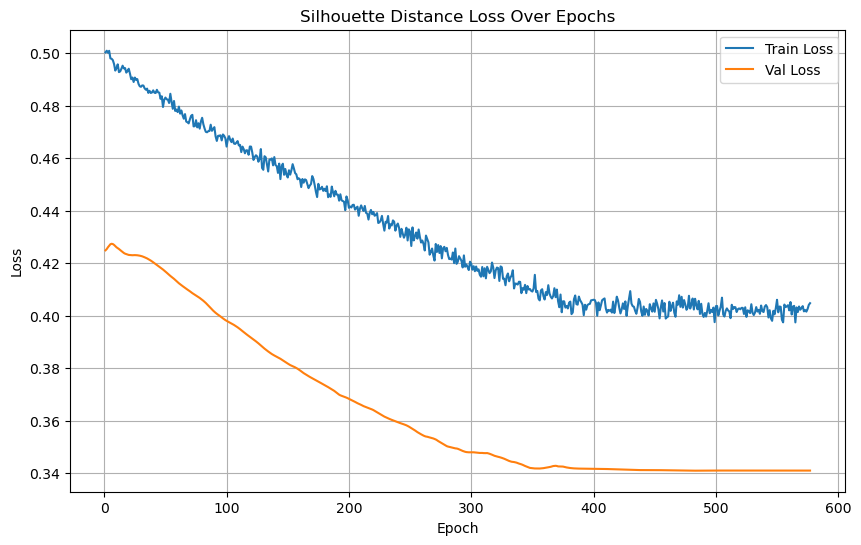

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/154], Loss: 0.2350


Test Batch [20/154], Loss: 0.3501
Test Batch [30/154], Loss: 0.3730


Test Batch [40/154], Loss: 0.3017


Test Batch [50/154], Loss: 0.3851
Test Batch [60/154], Loss: 0.4357


Test Batch [70/154], Loss: 0.3058


Test Batch [80/154], Loss: 0.2470
Test Batch [90/154], Loss: 0.2155
Test Batch [100/154], Loss: 0.1683
Test Batch [110/154], Loss: 0.1972


Test Batch [120/154], Loss: 0.1423


Test Batch [130/154], Loss: 0.2785
Test Batch [140/154], Loss: 0.3488
Test Batch [150/154], Loss: 0.3939



Test Loss: 0.3124


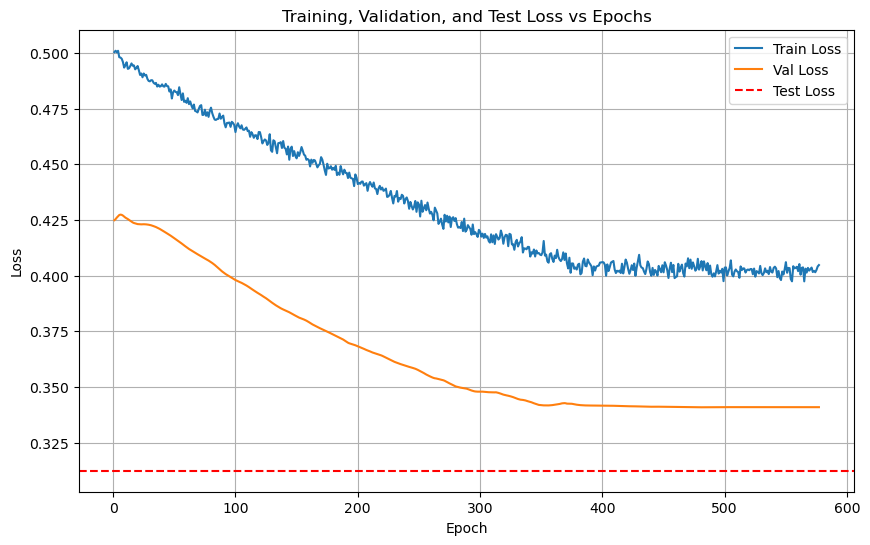

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/154 for test dataset.


  Processed batch 20/154 for test dataset.
  Processed batch 30/154 for test dataset.


  Processed batch 40/154 for test dataset.


  Processed batch 50/154 for test dataset.
  Processed batch 60/154 for test dataset.


  Processed batch 70/154 for test dataset.


  Processed batch 80/154 for test dataset.


  Processed batch 90/154 for test dataset.
  Processed batch 100/154 for test dataset.


  Processed batch 110/154 for test dataset.
  Processed batch 120/154 for test dataset.


  Processed batch 130/154 for test dataset.
  Processed batch 140/154 for test dataset.


  Processed batch 150/154 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 64.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.50      0.20      0.29         5
           2       0.25      0.20      0.22         5
           3       0.50      1.00      0.67         5
           4       0.60      0.60      0.60         5
           5       0.67      0.80      0.73         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       0.00      0.00      0.00         0
           9       0.50      0.60      0.55         5
          10       0.33      0.20      0.25         5
          11       0.33      0.40      0.36         5
          12       1.00      1.00      1.00         5
          13       0.6

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_clas

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (75, 128)
Val labels shape: (75,)
Test reps shape: (9854, 128)
Test labels shape: (9854,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8244  |  Val Loss: 2.8133
Validation loss improved from inf to 2.8133.
[Epoch 2/1000] Train Loss: 2.8015  |  Val Loss: 2.7939
Validation loss improved from 2.8133 to 2.7939.
[Epoch 3/1000] Train Loss: 2.7792  |  Val Loss: 2.7759
Validation loss improved from 2.7939 to 2.7759.
[Epoch 4/1000] Train Loss: 2.7596  |  Val Loss: 2.7585
Validation loss improved from 2.7759 to 2.7585.


[Epoch 5/1000] Train Loss: 2.7400  |  Val Loss: 2.7416
Validation loss improved from 2.7585 to 2.7416.
[Epoch 6/1000] Train Loss: 2.7220  |  Val Loss: 2.7251
Validation loss improved from 2.7416 to 2.7251.
[Epoch 7/1000] Train Loss: 2.7042  |  Val Loss: 2.7094
Validation loss improved from 2.7251 to 2.7094.
[Epoch 8/1000] Train Loss: 2.6873  |  Val Loss: 2.6945
Validation loss improved from 2.7094 to 2.6945.
[Epoch 9/1000] Train Loss: 2.6701  |  Val Loss: 2.6803
Validation loss improved from 2.6945 to 2.6803.
[Epoch 10/1000] Train Loss: 2.6548  |  Val Loss: 2.6662
Validation loss improved from 2.6803 to 2.6662.
[Epoch 11/1000] Train Loss: 2.6388  |  Val Loss: 2.6526
Validation loss improved from 2.6662 to 2.6526.
[Epoch 12/1000] Train Loss: 2.6227  |  Val Loss: 2.6392
Validation loss improved from 2.6526 to 2.6392.
[Epoch 13/1000] Train Loss: 2.6077  |  Val Loss: 2.6257
Validation loss improved from 2.6392 to 2.6257.
[Epoch 14/1000] Train Loss: 2.5923  |  Val Loss: 2.6125
Validation lo

[Epoch 15/1000] Train Loss: 2.5772  |  Val Loss: 2.5993
Validation loss improved from 2.6125 to 2.5993.


[Epoch 16/1000] Train Loss: 2.5617  |  Val Loss: 2.5861
Validation loss improved from 2.5993 to 2.5861.
[Epoch 17/1000] Train Loss: 2.5459  |  Val Loss: 2.5730
Validation loss improved from 2.5861 to 2.5730.
[Epoch 18/1000] Train Loss: 2.5309  |  Val Loss: 2.5598
Validation loss improved from 2.5730 to 2.5598.
[Epoch 19/1000] Train Loss: 2.5154  |  Val Loss: 2.5461
Validation loss improved from 2.5598 to 2.5461.
[Epoch 20/1000] Train Loss: 2.4996  |  Val Loss: 2.5326
Validation loss improved from 2.5461 to 2.5326.


[Epoch 21/1000] Train Loss: 2.4837  |  Val Loss: 2.5189
Validation loss improved from 2.5326 to 2.5189.
[Epoch 22/1000] Train Loss: 2.4671  |  Val Loss: 2.5056
Validation loss improved from 2.5189 to 2.5056.
[Epoch 23/1000] Train Loss: 2.4509  |  Val Loss: 2.4918
Validation loss improved from 2.5056 to 2.4918.
[Epoch 24/1000] Train Loss: 2.4351  |  Val Loss: 2.4777
Validation loss improved from 2.4918 to 2.4777.
[Epoch 25/1000] Train Loss: 2.4178  |  Val Loss: 2.4635
Validation loss improved from 2.4777 to 2.4635.
[Epoch 26/1000] Train Loss: 2.4008  |  Val Loss: 2.4488
Validation loss improved from 2.4635 to 2.4488.
[Epoch 27/1000] Train Loss: 2.3832  |  Val Loss: 2.4338
Validation loss improved from 2.4488 to 2.4338.
[Epoch 28/1000] Train Loss: 2.3654  |  Val Loss: 2.4189
Validation loss improved from 2.4338 to 2.4189.
[Epoch 29/1000] Train Loss: 2.3476  |  Val Loss: 2.4039
Validation loss improved from 2.4189 to 2.4039.
[Epoch 30/1000] Train Loss: 2.3297  |  Val Loss: 2.3882
Validati

[Epoch 34/1000] Train Loss: 2.2553  |  Val Loss: 2.3230
Validation loss improved from 2.3398 to 2.3230.
[Epoch 35/1000] Train Loss: 2.2362  |  Val Loss: 2.3060
Validation loss improved from 2.3230 to 2.3060.
[Epoch 36/1000] Train Loss: 2.2170  |  Val Loss: 2.2890
Validation loss improved from 2.3060 to 2.2890.
[Epoch 37/1000] Train Loss: 2.1975  |  Val Loss: 2.2721
Validation loss improved from 2.2890 to 2.2721.
[Epoch 38/1000] Train Loss: 2.1775  |  Val Loss: 2.2550
Validation loss improved from 2.2721 to 2.2550.


[Epoch 39/1000] Train Loss: 2.1573  |  Val Loss: 2.2377
Validation loss improved from 2.2550 to 2.2377.
[Epoch 40/1000] Train Loss: 2.1373  |  Val Loss: 2.2202
Validation loss improved from 2.2377 to 2.2202.
[Epoch 41/1000] Train Loss: 2.1167  |  Val Loss: 2.2020
Validation loss improved from 2.2202 to 2.2020.
[Epoch 42/1000] Train Loss: 2.0956  |  Val Loss: 2.1843
Validation loss improved from 2.2020 to 2.1843.
[Epoch 43/1000] Train Loss: 2.0746  |  Val Loss: 2.1664
Validation loss improved from 2.1843 to 2.1664.
[Epoch 44/1000] Train Loss: 2.0537  |  Val Loss: 2.1485
Validation loss improved from 2.1664 to 2.1485.
[Epoch 45/1000] Train Loss: 2.0329  |  Val Loss: 2.1310
Validation loss improved from 2.1485 to 2.1310.
[Epoch 46/1000] Train Loss: 2.0120  |  Val Loss: 2.1129
Validation loss improved from 2.1310 to 2.1129.
[Epoch 47/1000] Train Loss: 1.9907  |  Val Loss: 2.0950
Validation loss improved from 2.1129 to 2.0950.
[Epoch 48/1000] Train Loss: 1.9696  |  Val Loss: 2.0768
Validati

[Epoch 53/1000] Train Loss: 1.8613  |  Val Loss: 1.9850
Validation loss improved from 2.0039 to 1.9850.
[Epoch 54/1000] Train Loss: 1.8399  |  Val Loss: 1.9658
Validation loss improved from 1.9850 to 1.9658.
[Epoch 55/1000] Train Loss: 1.8177  |  Val Loss: 1.9472
Validation loss improved from 1.9658 to 1.9472.
[Epoch 56/1000] Train Loss: 1.7962  |  Val Loss: 1.9281
Validation loss improved from 1.9472 to 1.9281.
[Epoch 57/1000] Train Loss: 1.7744  |  Val Loss: 1.9094
Validation loss improved from 1.9281 to 1.9094.
[Epoch 58/1000] Train Loss: 1.7533  |  Val Loss: 1.8905
Validation loss improved from 1.9094 to 1.8905.


[Epoch 59/1000] Train Loss: 1.7315  |  Val Loss: 1.8716
Validation loss improved from 1.8905 to 1.8716.
[Epoch 60/1000] Train Loss: 1.7100  |  Val Loss: 1.8532
Validation loss improved from 1.8716 to 1.8532.
[Epoch 61/1000] Train Loss: 1.6886  |  Val Loss: 1.8353
Validation loss improved from 1.8532 to 1.8353.
[Epoch 62/1000] Train Loss: 1.6680  |  Val Loss: 1.8177
Validation loss improved from 1.8353 to 1.8177.
[Epoch 63/1000] Train Loss: 1.6468  |  Val Loss: 1.7995
Validation loss improved from 1.8177 to 1.7995.
[Epoch 64/1000] Train Loss: 1.6263  |  Val Loss: 1.7816
Validation loss improved from 1.7995 to 1.7816.
[Epoch 65/1000] Train Loss: 1.6058  |  Val Loss: 1.7651
Validation loss improved from 1.7816 to 1.7651.
[Epoch 66/1000] Train Loss: 1.5858  |  Val Loss: 1.7481
Validation loss improved from 1.7651 to 1.7481.
[Epoch 67/1000] Train Loss: 1.5661  |  Val Loss: 1.7319
Validation loss improved from 1.7481 to 1.7319.
[Epoch 68/1000] Train Loss: 1.5459  |  Val Loss: 1.7146
Validati

[Epoch 72/1000] Train Loss: 1.4692  |  Val Loss: 1.6511
Validation loss improved from 1.6665 to 1.6511.
[Epoch 73/1000] Train Loss: 1.4511  |  Val Loss: 1.6357
Validation loss improved from 1.6511 to 1.6357.
[Epoch 74/1000] Train Loss: 1.4328  |  Val Loss: 1.6198
Validation loss improved from 1.6357 to 1.6198.
[Epoch 75/1000] Train Loss: 1.4149  |  Val Loss: 1.6052
Validation loss improved from 1.6198 to 1.6052.


[Epoch 76/1000] Train Loss: 1.3972  |  Val Loss: 1.5916
Validation loss improved from 1.6052 to 1.5916.
[Epoch 77/1000] Train Loss: 1.3801  |  Val Loss: 1.5776
Validation loss improved from 1.5916 to 1.5776.
[Epoch 78/1000] Train Loss: 1.3630  |  Val Loss: 1.5638
Validation loss improved from 1.5776 to 1.5638.
[Epoch 79/1000] Train Loss: 1.3463  |  Val Loss: 1.5513
Validation loss improved from 1.5638 to 1.5513.
[Epoch 80/1000] Train Loss: 1.3301  |  Val Loss: 1.5388
Validation loss improved from 1.5513 to 1.5388.
[Epoch 81/1000] Train Loss: 1.3146  |  Val Loss: 1.5254
Validation loss improved from 1.5388 to 1.5254.
[Epoch 82/1000] Train Loss: 1.2986  |  Val Loss: 1.5130
Validation loss improved from 1.5254 to 1.5130.
[Epoch 83/1000] Train Loss: 1.2832  |  Val Loss: 1.5014
Validation loss improved from 1.5130 to 1.5014.
[Epoch 84/1000] Train Loss: 1.2684  |  Val Loss: 1.4889
Validation loss improved from 1.5014 to 1.4889.
[Epoch 85/1000] Train Loss: 1.2534  |  Val Loss: 1.4792
Validati

[Epoch 93/1000] Train Loss: 1.1470  |  Val Loss: 1.3985
Validation loss improved from 1.4081 to 1.3985.
[Epoch 94/1000] Train Loss: 1.1353  |  Val Loss: 1.3881
Validation loss improved from 1.3985 to 1.3881.
[Epoch 95/1000] Train Loss: 1.1238  |  Val Loss: 1.3780
Validation loss improved from 1.3881 to 1.3780.
[Epoch 96/1000] Train Loss: 1.1120  |  Val Loss: 1.3694
Validation loss improved from 1.3780 to 1.3694.
[Epoch 97/1000] Train Loss: 1.1013  |  Val Loss: 1.3603
Validation loss improved from 1.3694 to 1.3603.
[Epoch 98/1000] Train Loss: 1.0898  |  Val Loss: 1.3518
Validation loss improved from 1.3603 to 1.3518.
[Epoch 99/1000] Train Loss: 1.0795  |  Val Loss: 1.3436
Validation loss improved from 1.3518 to 1.3436.
[Epoch 100/1000] Train Loss: 1.0687  |  Val Loss: 1.3354
Validation loss improved from 1.3436 to 1.3354.
[Epoch 101/1000] Train Loss: 1.0587  |  Val Loss: 1.3273
Validation loss improved from 1.3354 to 1.3273.
[Epoch 102/1000] Train Loss: 1.0488  |  Val Loss: 1.3196
Valid

[Epoch 113/1000] Train Loss: 0.9514  |  Val Loss: 1.2442
Validation loss improved from 1.2500 to 1.2442.
[Epoch 114/1000] Train Loss: 0.9439  |  Val Loss: 1.2387
Validation loss improved from 1.2442 to 1.2387.
[Epoch 115/1000] Train Loss: 0.9366  |  Val Loss: 1.2331
Validation loss improved from 1.2387 to 1.2331.
[Epoch 116/1000] Train Loss: 0.9290  |  Val Loss: 1.2277
Validation loss improved from 1.2331 to 1.2277.
[Epoch 117/1000] Train Loss: 0.9224  |  Val Loss: 1.2220
Validation loss improved from 1.2277 to 1.2220.
[Epoch 118/1000] Train Loss: 0.9156  |  Val Loss: 1.2176
Validation loss improved from 1.2220 to 1.2176.
[Epoch 119/1000] Train Loss: 0.9087  |  Val Loss: 1.2114
Validation loss improved from 1.2176 to 1.2114.
[Epoch 120/1000] Train Loss: 0.9017  |  Val Loss: 1.2065
Validation loss improved from 1.2114 to 1.2065.
[Epoch 121/1000] Train Loss: 0.8955  |  Val Loss: 1.2015
Validation loss improved from 1.2065 to 1.2015.
[Epoch 122/1000] Train Loss: 0.8890  |  Val Loss: 1.197

[Epoch 133/1000] Train Loss: 0.8279  |  Val Loss: 1.1558
Validation loss improved from 1.1575 to 1.1558.
[Epoch 134/1000] Train Loss: 0.8228  |  Val Loss: 1.1530
Validation loss improved from 1.1558 to 1.1530.
[Epoch 135/1000] Train Loss: 0.8182  |  Val Loss: 1.1487
Validation loss improved from 1.1530 to 1.1487.
[Epoch 136/1000] Train Loss: 0.8133  |  Val Loss: 1.1445
Validation loss improved from 1.1487 to 1.1445.
[Epoch 137/1000] Train Loss: 0.8087  |  Val Loss: 1.1410
Validation loss improved from 1.1445 to 1.1410.
[Epoch 138/1000] Train Loss: 0.8043  |  Val Loss: 1.1373
Validation loss improved from 1.1410 to 1.1373.
[Epoch 139/1000] Train Loss: 0.7998  |  Val Loss: 1.1361
Validation loss improved from 1.1373 to 1.1361.
[Epoch 140/1000] Train Loss: 0.7952  |  Val Loss: 1.1327
Validation loss improved from 1.1361 to 1.1327.
[Epoch 141/1000] Train Loss: 0.7908  |  Val Loss: 1.1297
Validation loss improved from 1.1327 to 1.1297.
[Epoch 142/1000] Train Loss: 0.7865  |  Val Loss: 1.127

[Epoch 152/1000] Train Loss: 0.7477  |  Val Loss: 1.1052
Validation loss improved from 1.1063 to 1.1052.
[Epoch 153/1000] Train Loss: 0.7442  |  Val Loss: 1.1011
Validation loss improved from 1.1052 to 1.1011.
[Epoch 154/1000] Train Loss: 0.7405  |  Val Loss: 1.0990
Validation loss improved from 1.1011 to 1.0990.
[Epoch 155/1000] Train Loss: 0.7375  |  Val Loss: 1.0972
Validation loss improved from 1.0990 to 1.0972.
[Epoch 156/1000] Train Loss: 0.7338  |  Val Loss: 1.0960
Validation loss improved from 1.0972 to 1.0960.
[Epoch 157/1000] Train Loss: 0.7308  |  Val Loss: 1.0956
Validation loss improved from 1.0960 to 1.0956.
[Epoch 158/1000] Train Loss: 0.7272  |  Val Loss: 1.0924
Validation loss improved from 1.0956 to 1.0924.
[Epoch 159/1000] Train Loss: 0.7239  |  Val Loss: 1.0925
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 0.7204  |  Val Loss: 1.0917
Validation loss improved from 1.0924 to 1.0917.
[Epoch 161/1000] Train Loss: 0.7175  |  Val Loss:

[Epoch 170/1000] Train Loss: 0.6905  |  Val Loss: 1.0783
Validation loss improved from 1.0790 to 1.0783.
[Epoch 171/1000] Train Loss: 0.6875  |  Val Loss: 1.0761
Validation loss improved from 1.0783 to 1.0761.
[Epoch 172/1000] Train Loss: 0.6848  |  Val Loss: 1.0742
Validation loss improved from 1.0761 to 1.0742.
[Epoch 173/1000] Train Loss: 0.6826  |  Val Loss: 1.0718
Validation loss improved from 1.0742 to 1.0718.
[Epoch 174/1000] Train Loss: 0.6795  |  Val Loss: 1.0720
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 175/1000] Train Loss: 0.6769  |  Val Loss: 1.0728
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 176/1000] Train Loss: 0.6739  |  Val Loss: 1.0714
Validation loss improved from 1.0718 to 1.0714.
[Epoch 177/1000] Train Loss: 0.6713  |  Val Loss: 1.0698
Validation loss improved from 1.0714 to 1.0698.
[Epoch 178/1000] Train Loss: 0.6694  |  Val Loss: 1.0704
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 179/1000] Train Loss: 0.6664  

[Epoch 190/1000] Train Loss: 0.6399  |  Val Loss: 1.0615
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 191/1000] Train Loss: 0.6375  |  Val Loss: 1.0616
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 192/1000] Train Loss: 0.6354  |  Val Loss: 1.0618
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 193/1000] Train Loss: 0.6332  |  Val Loss: 1.0588
Validation loss improved from 1.0610 to 1.0588.
[Epoch 194/1000] Train Loss: 0.6306  |  Val Loss: 1.0576
Validation loss improved from 1.0588 to 1.0576.
[Epoch 195/1000] Train Loss: 0.6290  |  Val Loss: 1.0590
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 196/1000] Train Loss: 0.6268  |  Val Loss: 1.0564
Validation loss improved from 1.0576 to 1.0564.
[Epoch 197/1000] Train Loss: 0.6248  |  Val Loss: 1.0568
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 198/1000] Train Loss: 0.6221  |  Val Loss: 1.0562
Validation loss improved from 1.0564 to 1.0562.
[Epoch 199/1000] Train Lo

[Epoch 207/1000] Train Loss: 0.6046  |  Val Loss: 1.0531
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 0.6026  |  Val Loss: 1.0540
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 0.6007  |  Val Loss: 1.0534
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 210/1000] Train Loss: 0.5986  |  Val Loss: 1.0546
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 211/1000] Train Loss: 0.5971  |  Val Loss: 1.0555
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 212/1000] Train Loss: 0.5955  |  Val Loss: 1.0534
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 213/1000] Train Loss: 0.5937  |  Val Loss: 1.0529
Validation loss improved from 1.0531 to 1.0529.
[Epoch 214/1000] Train Loss: 0.5916  |  Val Loss: 1.0541
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 215/1000] Train Loss: 0.5897  |  Val Loss: 1.0524
Validation loss improved from 1.0529 to 1.0524.
[Epoch 216/10

[Epoch 226/1000] Train Loss: 0.5706  |  Val Loss: 1.0509
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 227/1000] Train Loss: 0.5692  |  Val Loss: 1.0516
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 228/1000] Train Loss: 0.5680  |  Val Loss: 1.0513
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 229/1000] Train Loss: 0.5663  |  Val Loss: 1.0518
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 230/1000] Train Loss: 0.5649  |  Val Loss: 1.0509
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 231/1000] Train Loss: 0.5631  |  Val Loss: 1.0498
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 232/1000] Train Loss: 0.5615  |  Val Loss: 1.0514
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 233/1000] Train Loss: 0.5598  |  Val Loss: 1.0507
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 234/1000] Train Loss: 0.5583  |  Val Loss: 1.0504
!! Validation loss did NOT improve !! Patience: 15

[Epoch 245/1000] Train Loss: 0.5420  |  Val Loss: 1.0519
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 246/1000] Train Loss: 0.5404  |  Val Loss: 1.0524
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 247/1000] Train Loss: 0.5392  |  Val Loss: 1.0514
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 248/1000] Train Loss: 0.5376  |  Val Loss: 1.0500
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 249/1000] Train Loss: 0.5364  |  Val Loss: 1.0520
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 250/1000] Train Loss: 0.5348  |  Val Loss: 1.0501
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 251/1000] Train Loss: 0.5334  |  Val Loss: 1.0490
Validation loss improved from 1.0490 to 1.0490.
[Epoch 252/1000] Train Loss: 0.5320  |  Val Loss: 1.0492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 253/1000] Train Loss: 0.5306  |  Val Loss: 1.0516
!! Validation loss did NOT improve !! Patience: 2/100
[Ep

[Epoch 263/1000] Train Loss: 0.5170  |  Val Loss: 1.0534
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 264/1000] Train Loss: 0.5159  |  Val Loss: 1.0522
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 265/1000] Train Loss: 0.5146  |  Val Loss: 1.0516
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 266/1000] Train Loss: 0.5134  |  Val Loss: 1.0509
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 267/1000] Train Loss: 0.5126  |  Val Loss: 1.0509
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 268/1000] Train Loss: 0.5105  |  Val Loss: 1.0523
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 269/1000] Train Loss: 0.5094  |  Val Loss: 1.0535
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 270/1000] Train Loss: 0.5081  |  Val Loss: 1.0533
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 271/1000] Train Loss: 0.5069  |  Val Loss: 1.0544
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 283/1000] Train Loss: 0.4919  |  Val Loss: 1.0572
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 284/1000] Train Loss: 0.4912  |  Val Loss: 1.0569
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 285/1000] Train Loss: 0.4901  |  Val Loss: 1.0555
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 286/1000] Train Loss: 0.4889  |  Val Loss: 1.0561
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 287/1000] Train Loss: 0.4872  |  Val Loss: 1.0558
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 288/1000] Train Loss: 0.4864  |  Val Loss: 1.0572
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 289/1000] Train Loss: 0.4853  |  Val Loss: 1.0573
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 290/1000] Train Loss: 0.4841  |  Val Loss: 1.0571
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 291/1000] Train Loss: 0.4834  |  Val Loss: 1.0560
!! Validation loss did NOT improve !! Patience:

[Epoch 302/1000] Train Loss: 0.4704  |  Val Loss: 1.0628
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 303/1000] Train Loss: 0.4693  |  Val Loss: 1.0643
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 304/1000] Train Loss: 0.4687  |  Val Loss: 1.0629
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 305/1000] Train Loss: 0.4668  |  Val Loss: 1.0637
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 306/1000] Train Loss: 0.4663  |  Val Loss: 1.0638
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 307/1000] Train Loss: 0.4651  |  Val Loss: 1.0656
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 308/1000] Train Loss: 0.4637  |  Val Loss: 1.0656
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 309/1000] Train Loss: 0.4626  |  Val Loss: 1.0656
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 310/1000] Train Loss: 0.4621  |  Val Loss: 1.0669
!! Validation loss did NOT improve !! Patience:

[Epoch 321/1000] Train Loss: 0.4498  |  Val Loss: 1.0714
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 322/1000] Train Loss: 0.4491  |  Val Loss: 1.0711
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 323/1000] Train Loss: 0.4483  |  Val Loss: 1.0724
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 324/1000] Train Loss: 0.4473  |  Val Loss: 1.0705
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 325/1000] Train Loss: 0.4460  |  Val Loss: 1.0710
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 326/1000] Train Loss: 0.4451  |  Val Loss: 1.0734
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 327/1000] Train Loss: 0.4438  |  Val Loss: 1.0737
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 328/1000] Train Loss: 0.4432  |  Val Loss: 1.0739
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 329/1000] Train Loss: 0.4417  |  Val Loss: 1.0754
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.4321  |  Val Loss: 1.0792
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 340/1000] Train Loss: 0.4310  |  Val Loss: 1.0803
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 341/1000] Train Loss: 0.4305  |  Val Loss: 1.0820
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 342/1000] Train Loss: 0.4297  |  Val Loss: 1.0822
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 343/1000] Train Loss: 0.4285  |  Val Loss: 1.0831
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 344/1000] Train Loss: 0.4274  |  Val Loss: 1.0840
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 345/1000] Train Loss: 0.4262  |  Val Loss: 1.0840
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 346/1000] Train Loss: 0.4256  |  Val Loss: 1.0846
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 347/1000] Train Loss: 0.4245  |  Val Loss: 1.0840
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 0.4153  |  Val Loss: 1.0909
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 359/1000] Train Loss: 0.4142  |  Val Loss: 1.0922
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 360/1000] Train Loss: 0.4130  |  Val Loss: 1.0935
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 360 !!
No improvement for 100 epochs.


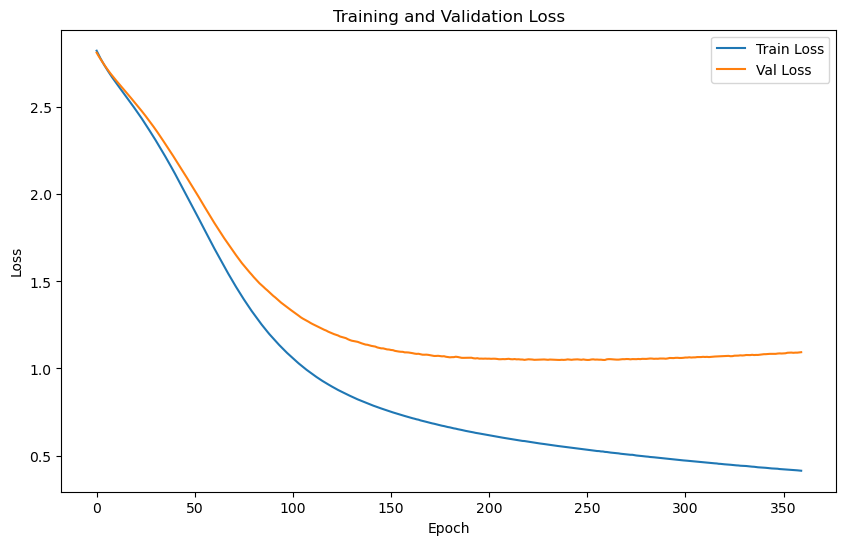

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 1.4469 | Test Accuracy: 51.14%


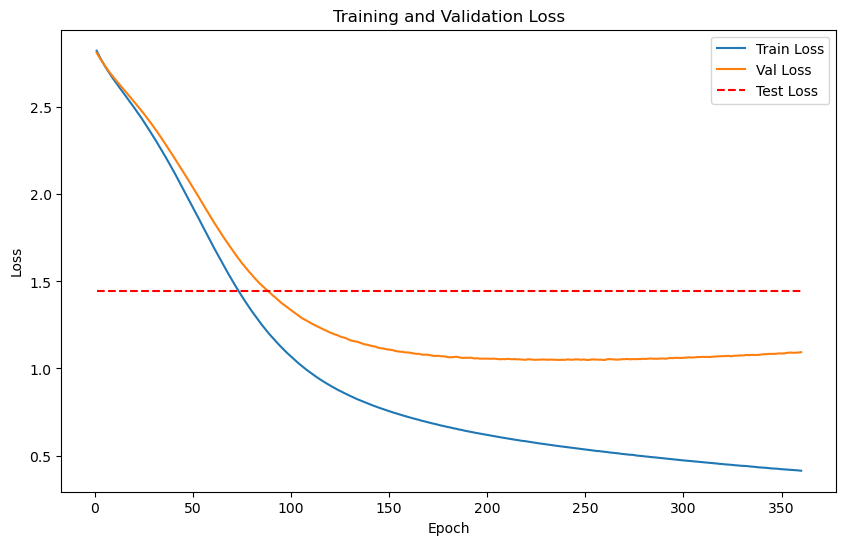

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


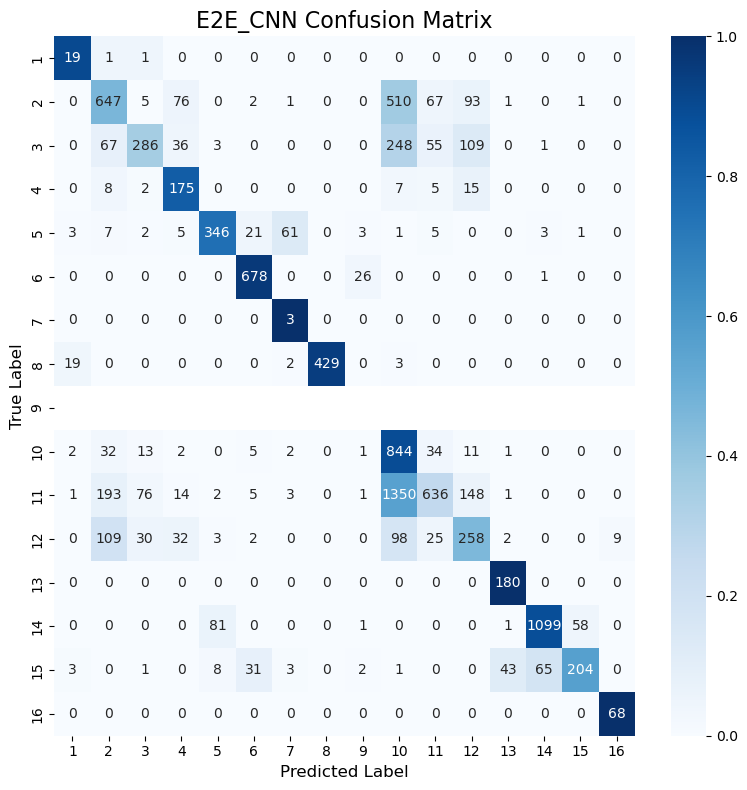

Classification Accuracy: 59.59%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


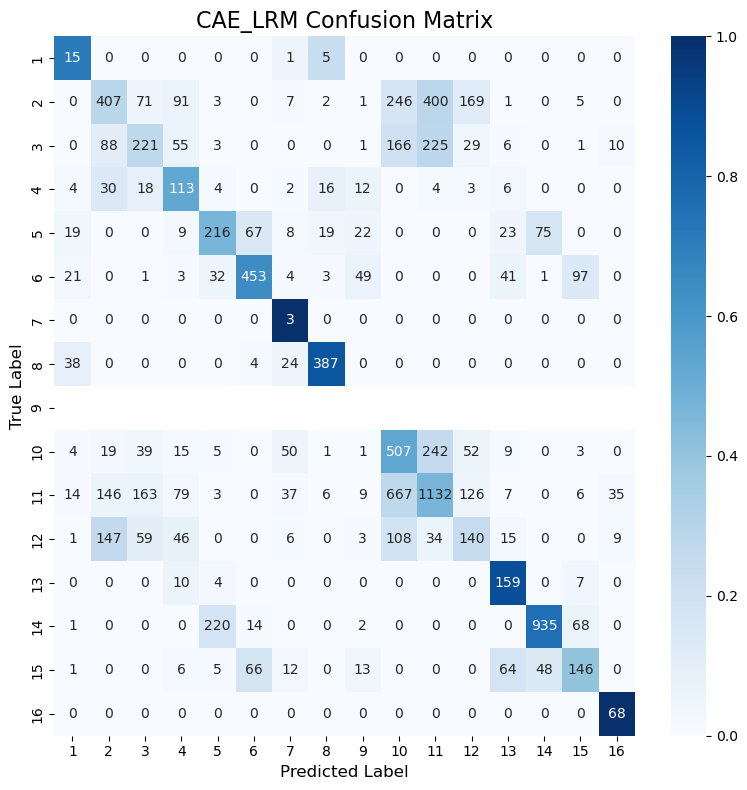

Classification Accuracy: 49.75%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


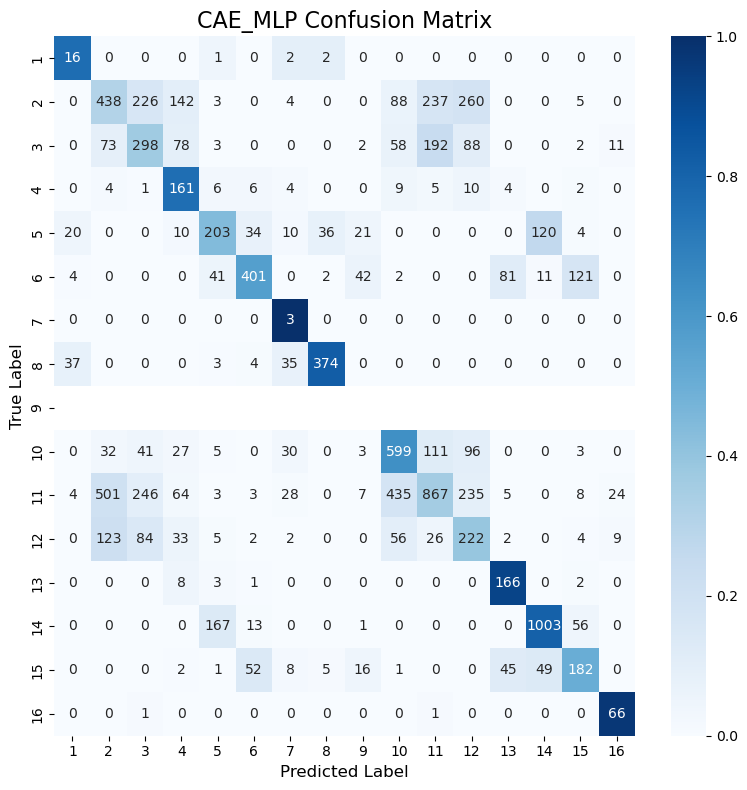

Classification Accuracy: 50.73%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


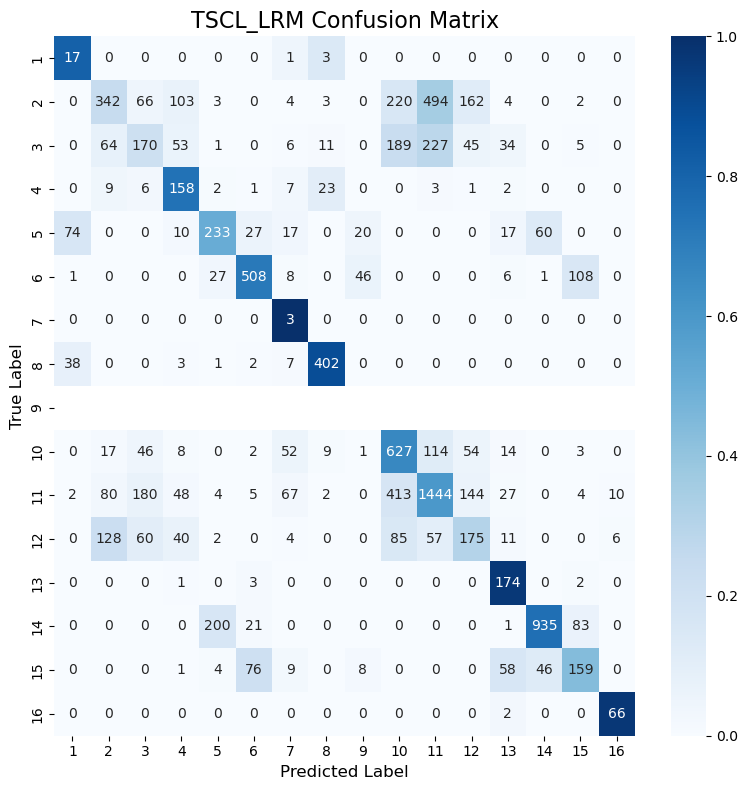

Classification Accuracy: 54.93%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


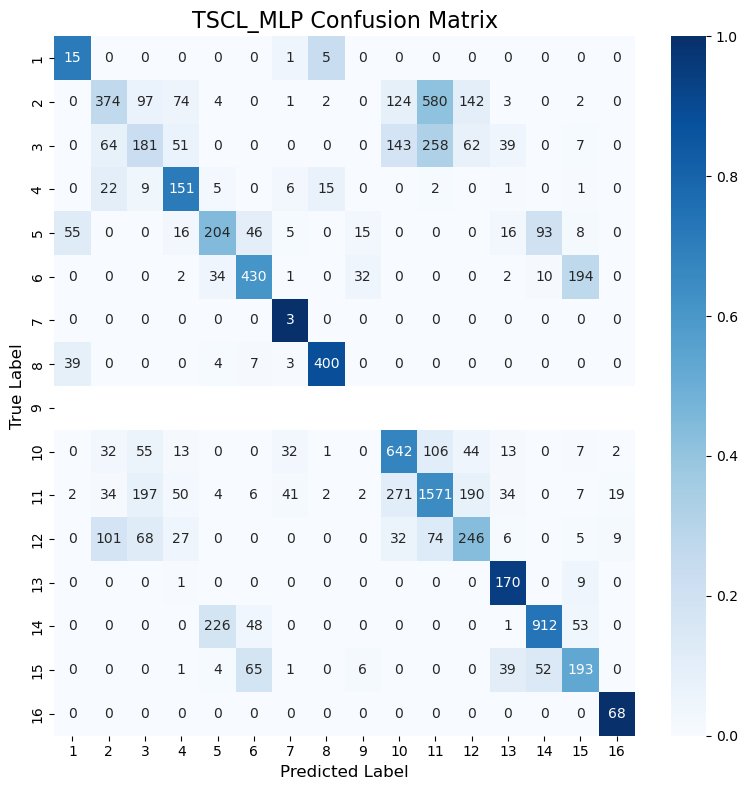

Classification Accuracy: 56.42%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


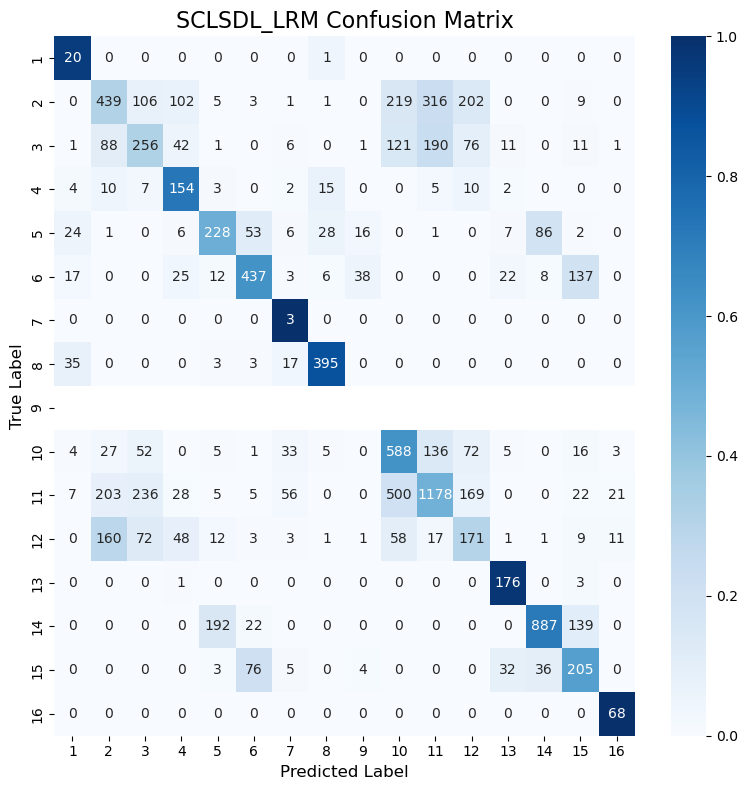

Classification Accuracy: 52.82%


C:\Users\vella\AppData\Local\Temp\ipykernel_20600\2424848340.py:18: RuntimeWarning: invalid value encountered in divide
  conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


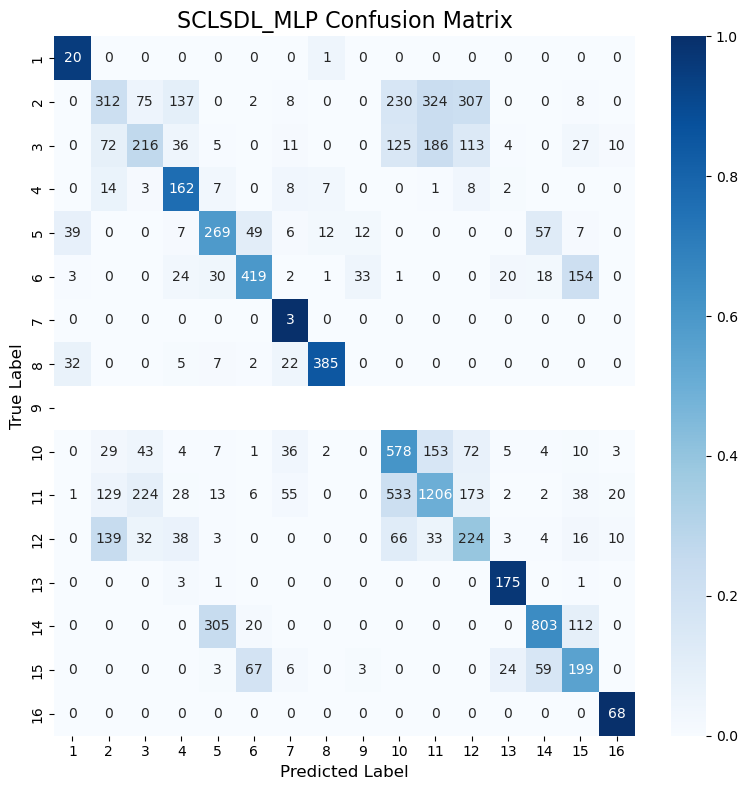

Classification Accuracy: 51.14%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          59.59
1    LRM (CAE)          49.75
2    MLP (CAE)          50.73
3     TSCL LRM          54.93
4     TSCL MLP          56.42
5  SCL_SDL LRM          52.82
6  SCL_SDL MLP          51.14

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          59.59
4     TSCL MLP          56.42
3     TSCL LRM          54.93
5  SCL_SDL LRM          52.82
6  SCL_SDL MLP          51.14
2    MLP (CAE)          50.73
1    LRM (CAE)          49.75
